<a href="https://colab.research.google.com/github/Nak-sha-tra/DL_Assignments/blob/main/DL_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comparative Study of CNN Architectures and Optimized Hyperparameters for CIFAR-10 Image Classification

# Imports and Device setup
We import all necessary libraries and define the device for computation (GPU or CPU)

In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchvision.models as models
import pandas as pd

# Defining the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Data Preparation
We use CIFAR 10 Dataset and it will be divided into 40,000 samples for training, 10,000 for validation, and 10,000 for testing.
We’ll create a function to handle loading and splitting the dataset and apply Data Augmentation on the training set and normalization for both train and test sets.

In [ ]:
# Defining data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Function to load and split dataset
def load_cifar10(batch_size=64):
    # Loading the CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Splitting the training set into train and validation sets
    train_size = 40000
    val_size = 10000
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # Creating data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Number of training samples: {len(train_subset)}")
    print(f"Number of validation samples: {len(val_subset)}")
    print(f"Number of test samples: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

# Loading the data
train_loader, val_loader, test_loader = load_cifar10()


Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


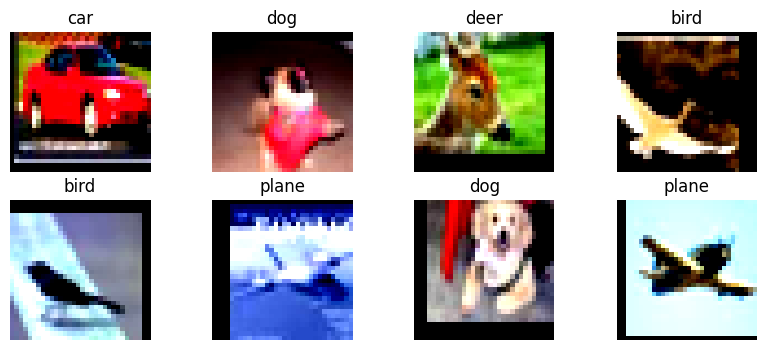

In [ ]:
# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define class names (CIFAR-10 classes)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Show images in a grid
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()


# Building a baseline CNN model


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiating the model
baseline_model = BaselineCNN().to(device)
print(baseline_model)


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


# Defining Helper functions for training, validation and plotting

In [ ]:
# Training function
def train_one_epoch(model, data_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

In [ ]:
# Validation function
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

In [ ]:
# Plotting function
def plot_metrics(train_acc, val_acc, train_loss, val_loss, title_suffix=""):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Training and evaluating the baseline model

100%|██████████| 157/157 [00:02<00:00, 60.48it/s]


Epoch [1/10], Loss: 1.6177, Training Accuracy: 39.92%, Validation Accuracy: 51.36%


100%|██████████| 157/157 [00:02<00:00, 61.33it/s]


Epoch [2/10], Loss: 1.2116, Training Accuracy: 56.12%, Validation Accuracy: 59.13%


100%|██████████| 157/157 [00:02<00:00, 69.00it/s]


Epoch [3/10], Loss: 1.0233, Training Accuracy: 63.48%, Validation Accuracy: 65.64%


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Epoch [4/10], Loss: 0.9255, Training Accuracy: 67.36%, Validation Accuracy: 67.81%


100%|██████████| 157/157 [00:02<00:00, 68.20it/s]


Epoch [5/10], Loss: 0.8475, Training Accuracy: 70.14%, Validation Accuracy: 69.61%


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Epoch [6/10], Loss: 0.7920, Training Accuracy: 72.19%, Validation Accuracy: 70.39%


100%|██████████| 157/157 [00:02<00:00, 66.81it/s]


Epoch [7/10], Loss: 0.7522, Training Accuracy: 73.72%, Validation Accuracy: 72.67%


100%|██████████| 157/157 [00:02<00:00, 70.81it/s]


Epoch [8/10], Loss: 0.7129, Training Accuracy: 75.11%, Validation Accuracy: 73.20%


100%|██████████| 157/157 [00:02<00:00, 69.99it/s]


Epoch [9/10], Loss: 0.6852, Training Accuracy: 75.81%, Validation Accuracy: 74.18%


100%|██████████| 157/157 [00:02<00:00, 69.72it/s]


Epoch [10/10], Loss: 0.6593, Training Accuracy: 76.80%, Validation Accuracy: 74.66%


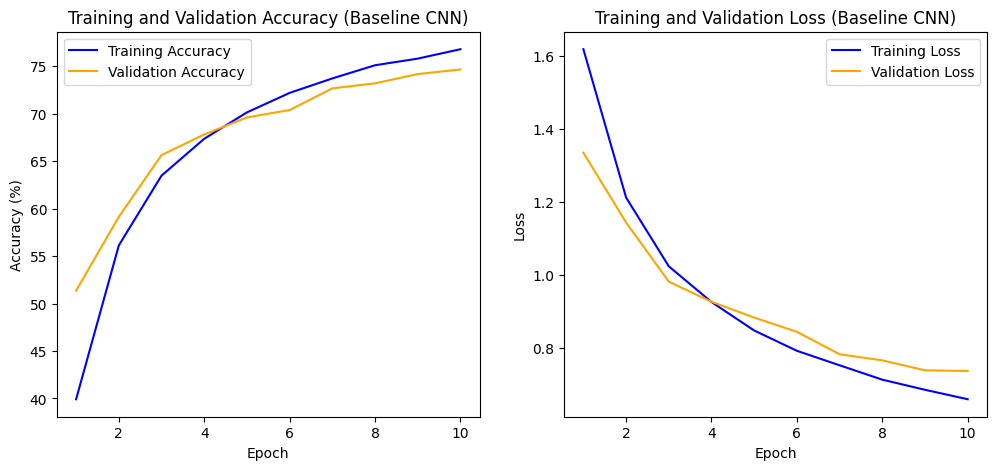

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)

# Lists to store metrics
train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

# Training and validation loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(baseline_model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(baseline_model, val_loader, criterion)

    # Store metrics
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

# Plot metrics
plot_metrics(train_acc_list, val_acc_list, train_loss_list, val_loss_list, title_suffix="(Baseline CNN)")


# Experimenting with classic CNN architectures

In [ ]:
# Load and modify model function
def load_model(model_name):
    if model_name == "vgg16":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
    elif model_name == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "resnet34":
        model = models.resnet34(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "vgg19":
        model = models.vgg19(weights=None)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
    else:
        raise ValueError("Model not supported!")
    return model.to(device)

In [ ]:
# Training function to loop over epochs
def train_and_evaluate_model(model, train_loader, val_loader, optimizer=None, num_epochs=10, learning_rate=0.01):
    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Store metrics for plotting
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, "
              f"Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

# VGG 16

100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


Epoch [1/10], Training Loss: 2.0446, Training Accuracy: 21.27%, Validation Accuracy: 27.72%


100%|██████████| 157/157 [00:02<00:00, 67.96it/s]


Epoch [2/10], Training Loss: 1.6578, Training Accuracy: 36.81%, Validation Accuracy: 46.37%


100%|██████████| 157/157 [00:02<00:00, 68.78it/s]


Epoch [3/10], Training Loss: 1.3649, Training Accuracy: 50.55%, Validation Accuracy: 56.96%


100%|██████████| 157/157 [00:02<00:00, 69.94it/s]


Epoch [4/10], Training Loss: 1.1467, Training Accuracy: 59.03%, Validation Accuracy: 64.60%


100%|██████████| 157/157 [00:02<00:00, 70.02it/s]


Epoch [5/10], Training Loss: 1.0093, Training Accuracy: 64.34%, Validation Accuracy: 67.23%


100%|██████████| 157/157 [00:02<00:00, 68.50it/s]


Epoch [6/10], Training Loss: 0.9013, Training Accuracy: 68.87%, Validation Accuracy: 71.81%


100%|██████████| 157/157 [00:02<00:00, 61.24it/s]


Epoch [7/10], Training Loss: 0.8072, Training Accuracy: 72.39%, Validation Accuracy: 73.70%


100%|██████████| 157/157 [00:02<00:00, 70.53it/s]


Epoch [8/10], Training Loss: 0.7428, Training Accuracy: 74.65%, Validation Accuracy: 75.45%


100%|██████████| 157/157 [00:02<00:00, 68.76it/s]


Epoch [9/10], Training Loss: 0.6795, Training Accuracy: 77.30%, Validation Accuracy: 77.75%


100%|██████████| 157/157 [00:02<00:00, 71.59it/s]


Epoch [10/10], Training Loss: 0.6353, Training Accuracy: 78.63%, Validation Accuracy: 78.28%


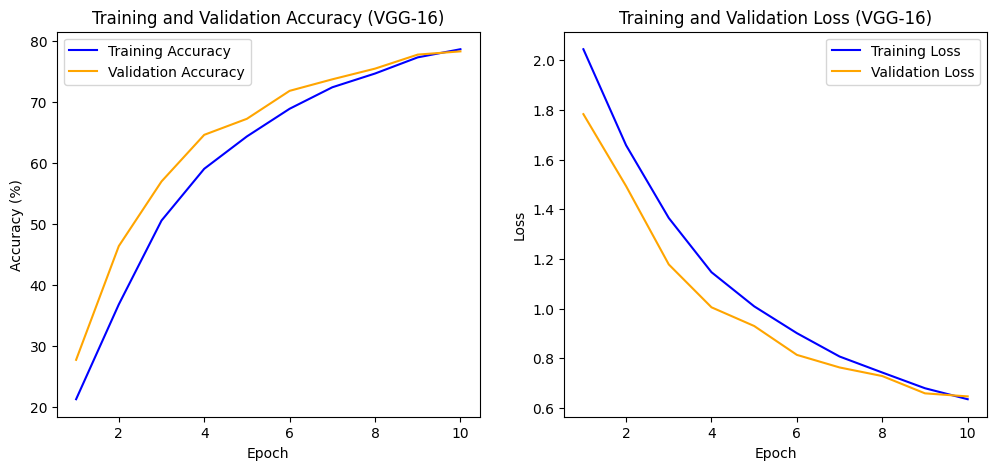

In [ ]:
model_vgg16 = load_model("vgg16")
train_acc_vgg16, val_acc_vgg16, train_loss_vgg16, val_loss_vgg16 = train_and_evaluate_model(
    model_vgg16, train_loader, val_loader, num_epochs=10, learning_rate=0.01
)
plot_metrics(train_acc_vgg16, val_acc_vgg16, train_loss_vgg16, val_loss_vgg16, title_suffix="(VGG-16)")

# VGG 19

In [ ]:
# Load and modify VGG-19 model for CIFAR-10
model_vgg19 = models.vgg19(weights=None)
model_vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=10)  #

model_vgg19 = model_vgg19.to(device)

# Print model summary
print(model_vgg19)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

100%|██████████| 157/157 [00:02<00:00, 65.92it/s]


Epoch [1/10], Training Loss: 2.0600, Training Accuracy: 20.08%, Validation Accuracy: 25.64%


100%|██████████| 157/157 [00:02<00:00, 63.52it/s]


Epoch [2/10], Training Loss: 1.7438, Training Accuracy: 30.54%, Validation Accuracy: 37.34%


100%|██████████| 157/157 [00:02<00:00, 69.45it/s]


Epoch [3/10], Training Loss: 1.5399, Training Accuracy: 41.83%, Validation Accuracy: 49.35%


100%|██████████| 157/157 [00:02<00:00, 68.54it/s]


Epoch [4/10], Training Loss: 1.3021, Training Accuracy: 53.12%, Validation Accuracy: 60.67%


100%|██████████| 157/157 [00:02<00:00, 66.24it/s]


Epoch [5/10], Training Loss: 1.1178, Training Accuracy: 60.57%, Validation Accuracy: 64.07%


100%|██████████| 157/157 [00:02<00:00, 70.09it/s]


Epoch [6/10], Training Loss: 0.9957, Training Accuracy: 65.21%, Validation Accuracy: 68.32%


100%|██████████| 157/157 [00:02<00:00, 70.31it/s]


Epoch [7/10], Training Loss: 0.9049, Training Accuracy: 69.14%, Validation Accuracy: 66.30%


100%|██████████| 157/157 [00:02<00:00, 69.67it/s]


Epoch [8/10], Training Loss: 0.8203, Training Accuracy: 72.52%, Validation Accuracy: 73.55%


100%|██████████| 157/157 [00:02<00:00, 68.29it/s]


Epoch [9/10], Training Loss: 0.7490, Training Accuracy: 75.05%, Validation Accuracy: 75.58%


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch [10/10], Training Loss: 0.7034, Training Accuracy: 76.59%, Validation Accuracy: 76.30%


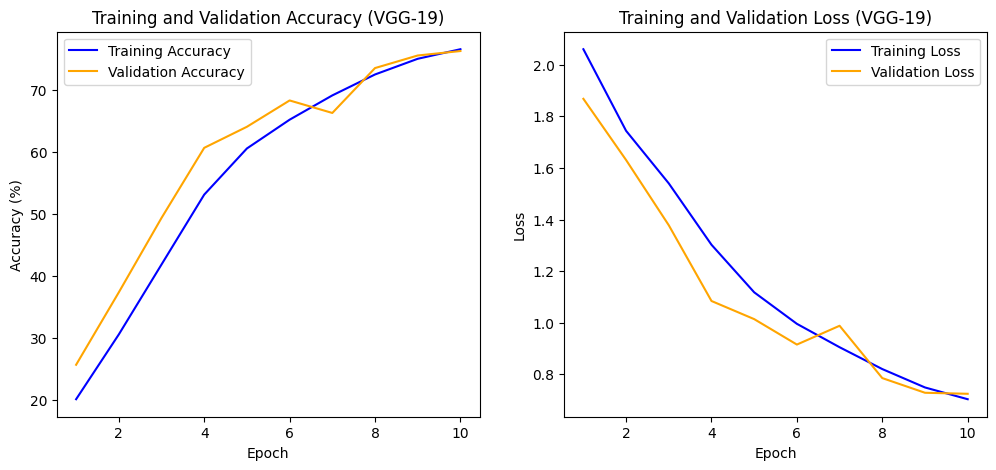

In [ ]:
# Train and evaluate the model with VGG-19 architecture
train_acc_vgg19, val_acc_vgg19, train_loss_vgg19, val_loss_vgg19 = train_and_evaluate_model(
    model_vgg19, train_loader, val_loader, num_epochs=10, learning_rate=0.01
)

# Plot training and validation accuracy/loss
plot_metrics(train_acc_vgg19, val_acc_vgg19, train_loss_vgg19, val_loss_vgg19, title_suffix="(VGG-19)")


# RESNET 18

In [ ]:
# Load ResNet-18 model for CIFAR-10
model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = nn.Linear(in_features=512, out_features=10)

model_resnet18 = model_resnet18.to(device)

print(model_resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 157/157 [00:02<00:00, 70.60it/s]


Epoch [1/10], Training Loss: 1.7935, Training Accuracy: 36.70%, Validation Accuracy: 43.51%


100%|██████████| 157/157 [00:02<00:00, 70.29it/s]


Epoch [2/10], Training Loss: 1.4486, Training Accuracy: 48.46%, Validation Accuracy: 53.59%


100%|██████████| 157/157 [00:02<00:00, 71.99it/s]


Epoch [3/10], Training Loss: 1.2644, Training Accuracy: 55.54%, Validation Accuracy: 57.51%


100%|██████████| 157/157 [00:02<00:00, 70.88it/s]


Epoch [4/10], Training Loss: 1.1500, Training Accuracy: 59.57%, Validation Accuracy: 62.21%


100%|██████████| 157/157 [00:02<00:00, 57.92it/s]


Epoch [5/10], Training Loss: 1.0577, Training Accuracy: 63.17%, Validation Accuracy: 64.99%


100%|██████████| 157/157 [00:02<00:00, 68.77it/s]


Epoch [6/10], Training Loss: 0.9784, Training Accuracy: 65.86%, Validation Accuracy: 66.37%


100%|██████████| 157/157 [00:02<00:00, 71.25it/s]


Epoch [7/10], Training Loss: 0.9048, Training Accuracy: 68.35%, Validation Accuracy: 68.19%


100%|██████████| 157/157 [00:02<00:00, 68.49it/s]


Epoch [8/10], Training Loss: 0.8689, Training Accuracy: 69.77%, Validation Accuracy: 68.81%


100%|██████████| 157/157 [00:02<00:00, 69.42it/s]


Epoch [9/10], Training Loss: 0.8188, Training Accuracy: 71.34%, Validation Accuracy: 69.54%


100%|██████████| 157/157 [00:02<00:00, 71.23it/s]


Epoch [10/10], Training Loss: 0.7808, Training Accuracy: 72.63%, Validation Accuracy: 71.11%


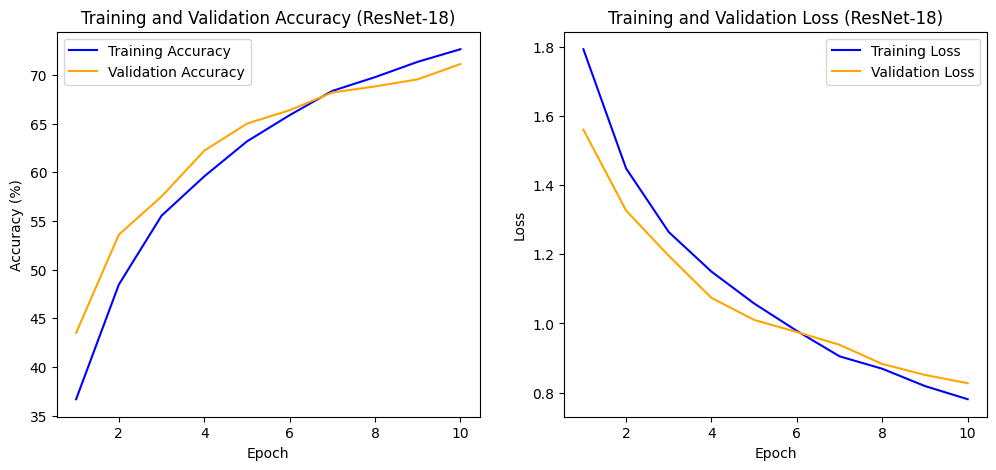

In [ ]:
# Train and evaluate the model with ResNet-18 architecture
train_acc_resnet18, val_acc_resnet18, train_loss_resnet18, val_loss_resnet18 = train_and_evaluate_model(
    model_resnet18, train_loader, val_loader, num_epochs=10, learning_rate=0.01
)

# Plot training and validation accuracy/loss
plot_metrics(train_acc_resnet18, val_acc_resnet18, train_loss_resnet18, val_loss_resnet18, title_suffix="(ResNet-18)")


# RESNET 34

In [ ]:
# Load ResNet-34 model for CIFAR-10
model_resnet34 = models.resnet34(weights=None)
model_resnet34.fc = nn.Linear(in_features=512, out_features=10)

model_resnet34 = model_resnet34.to(device)

print(model_resnet34)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 157/157 [00:02<00:00, 71.12it/s]


Epoch [1/10], Training Loss: 1.9681, Training Accuracy: 32.20%, Validation Accuracy: 34.35%


100%|██████████| 157/157 [00:02<00:00, 65.41it/s]


Epoch [2/10], Training Loss: 1.6771, Training Accuracy: 41.23%, Validation Accuracy: 45.08%


100%|██████████| 157/157 [00:02<00:00, 71.40it/s]


Epoch [3/10], Training Loss: 1.5385, Training Accuracy: 45.55%, Validation Accuracy: 46.22%


100%|██████████| 157/157 [00:02<00:00, 69.63it/s]


Epoch [4/10], Training Loss: 1.4277, Training Accuracy: 49.25%, Validation Accuracy: 49.77%


100%|██████████| 157/157 [00:02<00:00, 70.82it/s]


Epoch [5/10], Training Loss: 1.3752, Training Accuracy: 51.50%, Validation Accuracy: 54.17%


100%|██████████| 157/157 [00:02<00:00, 69.75it/s]


Epoch [6/10], Training Loss: 1.2727, Training Accuracy: 55.42%, Validation Accuracy: 58.31%


100%|██████████| 157/157 [00:02<00:00, 67.74it/s]


Epoch [7/10], Training Loss: 1.1626, Training Accuracy: 59.21%, Validation Accuracy: 58.20%


100%|██████████| 157/157 [00:02<00:00, 70.97it/s]


Epoch [8/10], Training Loss: 1.1122, Training Accuracy: 61.28%, Validation Accuracy: 62.35%


100%|██████████| 157/157 [00:02<00:00, 70.13it/s]


Epoch [9/10], Training Loss: 1.0201, Training Accuracy: 64.16%, Validation Accuracy: 63.85%


100%|██████████| 157/157 [00:02<00:00, 69.99it/s]


Epoch [10/10], Training Loss: 0.9732, Training Accuracy: 66.05%, Validation Accuracy: 66.27%


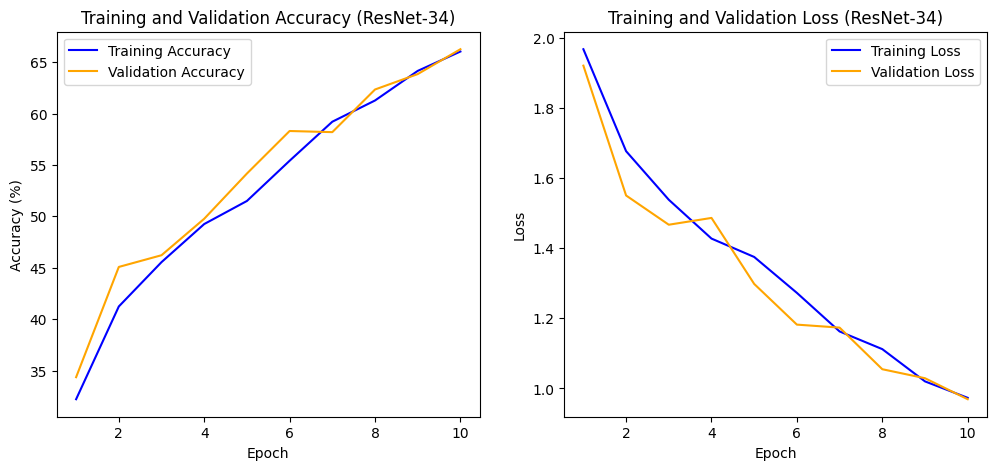

In [ ]:
# Train and evaluate the model with ResNet-34 architecture
train_acc_resnet34, val_acc_resnet34, train_loss_resnet34, val_loss_resnet34 = train_and_evaluate_model(
    model_resnet34, train_loader, val_loader, num_epochs=10, learning_rate=0.01
)

# Plot training and validation accuracy/loss
plot_metrics(train_acc_resnet34, val_acc_resnet34, train_loss_resnet34, val_loss_resnet34, title_suffix="(ResNet-34)")


# RESNET 50

In [ ]:
# Load ResNet-50 model for CIFAR-10
model_resnet50 = models.resnet50(weights=None)
model_resnet50.fc = nn.Linear(in_features=2048, out_features=10)

model_resnet50 = model_resnet50.to(device)

print(model_resnet50)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

100%|██████████| 157/157 [00:02<00:00, 69.72it/s]


Epoch [1/10], Training Loss: 3.1439, Training Accuracy: 22.23%, Validation Accuracy: 25.83%


100%|██████████| 157/157 [00:02<00:00, 67.76it/s]


Epoch [2/10], Training Loss: 2.2791, Training Accuracy: 28.93%, Validation Accuracy: 27.70%


100%|██████████| 157/157 [00:02<00:00, 70.00it/s]


Epoch [3/10], Training Loss: 2.0766, Training Accuracy: 32.44%, Validation Accuracy: 35.57%


100%|██████████| 157/157 [00:02<00:00, 67.10it/s]


Epoch [4/10], Training Loss: 1.9412, Training Accuracy: 36.29%, Validation Accuracy: 40.69%


100%|██████████| 157/157 [00:02<00:00, 69.79it/s]


Epoch [5/10], Training Loss: 1.7941, Training Accuracy: 40.34%, Validation Accuracy: 42.77%


100%|██████████| 157/157 [00:02<00:00, 70.18it/s]


Epoch [6/10], Training Loss: 1.7032, Training Accuracy: 43.16%, Validation Accuracy: 44.42%


100%|██████████| 157/157 [00:02<00:00, 66.19it/s]


Epoch [7/10], Training Loss: 1.6129, Training Accuracy: 45.24%, Validation Accuracy: 47.75%


100%|██████████| 157/157 [00:02<00:00, 70.63it/s]


Epoch [8/10], Training Loss: 1.5336, Training Accuracy: 47.75%, Validation Accuracy: 49.80%


100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Epoch [9/10], Training Loss: 1.4938, Training Accuracy: 49.54%, Validation Accuracy: 51.56%


100%|██████████| 157/157 [00:02<00:00, 69.78it/s]


Epoch [10/10], Training Loss: 1.4371, Training Accuracy: 51.05%, Validation Accuracy: 53.37%


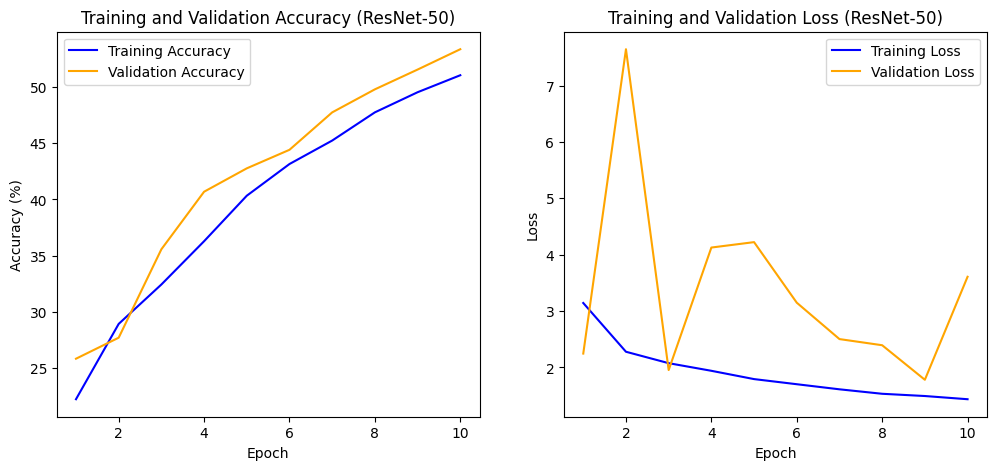

In [ ]:
# Train and evaluate the model with ResNet-50 architecture
train_acc_resnet50, val_acc_resnet50, train_loss_resnet50, val_loss_resnet50 = train_and_evaluate_model(
    model_resnet50, train_loader, val_loader, num_epochs=10, learning_rate=0.01
)

# Plot training and validation accuracy/loss
plot_metrics(train_acc_resnet50, val_acc_resnet50, train_loss_resnet50, val_loss_resnet50, title_suffix="(ResNet-50)")


# Experimenting with different learning rates on different architectures


--- Experimenting with Model: BaselineCNN ---

Training BaselineCNN with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 71.77it/s]


Epoch [1/10], Training Loss: 1.9932, Training Accuracy: 23.90%, Validation Accuracy: 29.15%


100%|██████████| 157/157 [00:02<00:00, 68.49it/s]


Epoch [2/10], Training Loss: 1.8653, Training Accuracy: 30.50%, Validation Accuracy: 30.10%


100%|██████████| 157/157 [00:02<00:00, 69.87it/s]


Epoch [3/10], Training Loss: 1.8639, Training Accuracy: 31.19%, Validation Accuracy: 32.28%


100%|██████████| 157/157 [00:02<00:00, 68.72it/s]


Epoch [4/10], Training Loss: 1.8802, Training Accuracy: 30.80%, Validation Accuracy: 34.79%


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


Epoch [5/10], Training Loss: 1.9170, Training Accuracy: 29.03%, Validation Accuracy: 30.42%


100%|██████████| 157/157 [00:02<00:00, 70.94it/s]


Epoch [6/10], Training Loss: 1.9065, Training Accuracy: 30.24%, Validation Accuracy: 27.27%


100%|██████████| 157/157 [00:02<00:00, 70.32it/s]


Epoch [7/10], Training Loss: 1.9491, Training Accuracy: 27.96%, Validation Accuracy: 28.05%


100%|██████████| 157/157 [00:02<00:00, 63.45it/s]


Epoch [8/10], Training Loss: 1.9526, Training Accuracy: 27.27%, Validation Accuracy: 29.64%


100%|██████████| 157/157 [00:02<00:00, 69.46it/s]


Epoch [9/10], Training Loss: 1.9504, Training Accuracy: 27.33%, Validation Accuracy: 28.90%


100%|██████████| 157/157 [00:02<00:00, 70.21it/s]


Epoch [10/10], Training Loss: 1.9607, Training Accuracy: 26.76%, Validation Accuracy: 30.16%


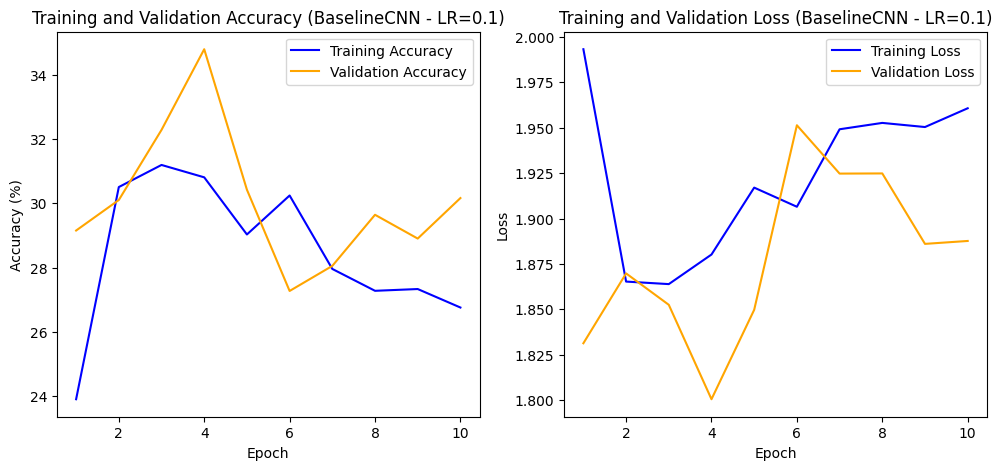


Training BaselineCNN with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 68.17it/s]


Epoch [1/10], Training Loss: 1.8774, Training Accuracy: 30.69%, Validation Accuracy: 43.70%


100%|██████████| 157/157 [00:02<00:00, 68.04it/s]


Epoch [2/10], Training Loss: 1.4124, Training Accuracy: 48.27%, Validation Accuracy: 54.35%


100%|██████████| 157/157 [00:02<00:00, 70.06it/s]


Epoch [3/10], Training Loss: 1.1742, Training Accuracy: 57.88%, Validation Accuracy: 59.99%


100%|██████████| 157/157 [00:02<00:00, 70.15it/s]


Epoch [4/10], Training Loss: 1.0374, Training Accuracy: 63.28%, Validation Accuracy: 65.04%


100%|██████████| 157/157 [00:02<00:00, 69.39it/s]


Epoch [5/10], Training Loss: 0.9393, Training Accuracy: 67.08%, Validation Accuracy: 67.02%


100%|██████████| 157/157 [00:02<00:00, 69.44it/s]


Epoch [6/10], Training Loss: 0.8679, Training Accuracy: 69.49%, Validation Accuracy: 69.51%


100%|██████████| 157/157 [00:02<00:00, 68.97it/s]


Epoch [7/10], Training Loss: 0.8062, Training Accuracy: 71.78%, Validation Accuracy: 72.70%


100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


Epoch [8/10], Training Loss: 0.7544, Training Accuracy: 73.59%, Validation Accuracy: 73.47%


100%|██████████| 157/157 [00:02<00:00, 65.77it/s]


Epoch [9/10], Training Loss: 0.7218, Training Accuracy: 74.88%, Validation Accuracy: 72.84%


100%|██████████| 157/157 [00:02<00:00, 68.62it/s]


Epoch [10/10], Training Loss: 0.6962, Training Accuracy: 75.57%, Validation Accuracy: 73.47%


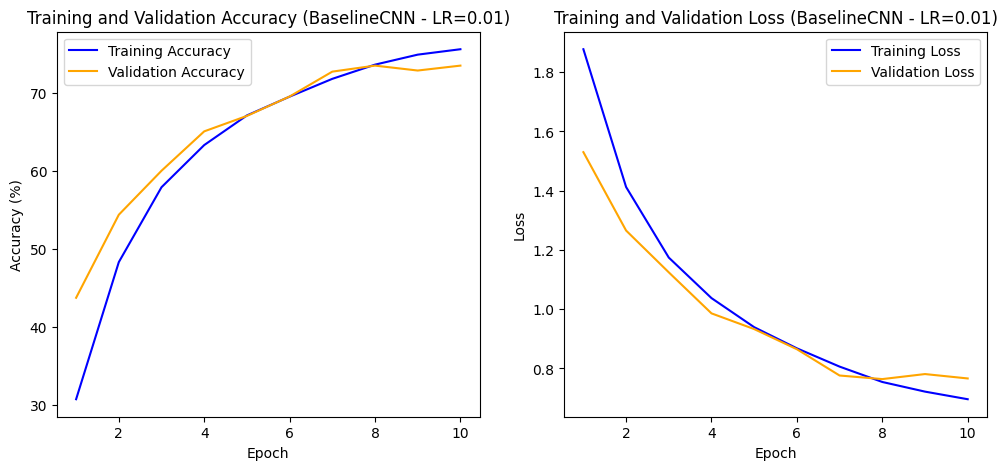


Training BaselineCNN with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 69.69it/s]


Epoch [1/10], Training Loss: 2.2862, Training Accuracy: 15.45%, Validation Accuracy: 19.26%


100%|██████████| 157/157 [00:02<00:00, 68.58it/s]


Epoch [2/10], Training Loss: 2.0637, Training Accuracy: 25.08%, Validation Accuracy: 30.13%


100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


Epoch [3/10], Training Loss: 1.8424, Training Accuracy: 32.67%, Validation Accuracy: 34.49%


100%|██████████| 157/157 [00:02<00:00, 69.71it/s]


Epoch [4/10], Training Loss: 1.6876, Training Accuracy: 37.82%, Validation Accuracy: 40.80%


100%|██████████| 157/157 [00:02<00:00, 71.92it/s]


Epoch [5/10], Training Loss: 1.5855, Training Accuracy: 41.71%, Validation Accuracy: 41.19%


100%|██████████| 157/157 [00:02<00:00, 71.77it/s]


Epoch [6/10], Training Loss: 1.5011, Training Accuracy: 45.11%, Validation Accuracy: 46.09%


100%|██████████| 157/157 [00:02<00:00, 67.85it/s]


Epoch [7/10], Training Loss: 1.4436, Training Accuracy: 47.36%, Validation Accuracy: 49.37%


100%|██████████| 157/157 [00:02<00:00, 63.41it/s]


Epoch [8/10], Training Loss: 1.3893, Training Accuracy: 49.55%, Validation Accuracy: 49.84%


100%|██████████| 157/157 [00:02<00:00, 71.33it/s]


Epoch [9/10], Training Loss: 1.3331, Training Accuracy: 51.80%, Validation Accuracy: 53.06%


100%|██████████| 157/157 [00:02<00:00, 70.97it/s]


Epoch [10/10], Training Loss: 1.2973, Training Accuracy: 53.19%, Validation Accuracy: 49.80%


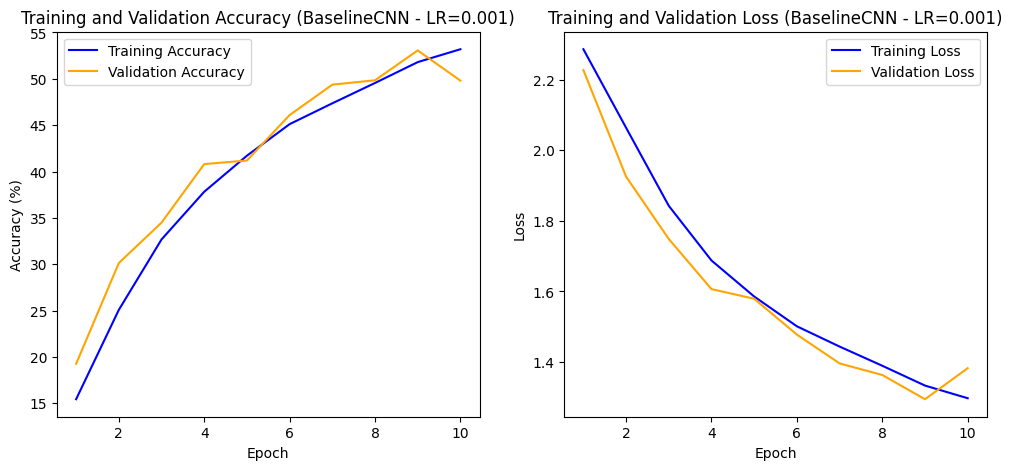


Training BaselineCNN with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 69.90it/s]


Epoch [1/10], Training Loss: 2.3027, Training Accuracy: 10.01%, Validation Accuracy: 9.97%


100%|██████████| 157/157 [00:02<00:00, 69.82it/s]


Epoch [2/10], Training Loss: 2.3005, Training Accuracy: 10.01%, Validation Accuracy: 9.97%


100%|██████████| 157/157 [00:02<00:00, 71.14it/s]


Epoch [3/10], Training Loss: 2.2981, Training Accuracy: 10.07%, Validation Accuracy: 10.32%


100%|██████████| 157/157 [00:02<00:00, 69.69it/s]


Epoch [4/10], Training Loss: 2.2952, Training Accuracy: 11.49%, Validation Accuracy: 12.46%


100%|██████████| 157/157 [00:02<00:00, 68.57it/s]


Epoch [5/10], Training Loss: 2.2915, Training Accuracy: 15.02%, Validation Accuracy: 17.33%


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch [6/10], Training Loss: 2.2864, Training Accuracy: 18.91%, Validation Accuracy: 19.48%


100%|██████████| 157/157 [00:02<00:00, 70.54it/s]


Epoch [7/10], Training Loss: 2.2786, Training Accuracy: 19.48%, Validation Accuracy: 19.23%


100%|██████████| 157/157 [00:02<00:00, 69.38it/s]


Epoch [8/10], Training Loss: 2.2657, Training Accuracy: 19.39%, Validation Accuracy: 20.96%


100%|██████████| 157/157 [00:02<00:00, 70.71it/s]


Epoch [9/10], Training Loss: 2.2439, Training Accuracy: 21.84%, Validation Accuracy: 22.12%


100%|██████████| 157/157 [00:02<00:00, 68.45it/s]


Epoch [10/10], Training Loss: 2.2093, Training Accuracy: 23.11%, Validation Accuracy: 23.45%


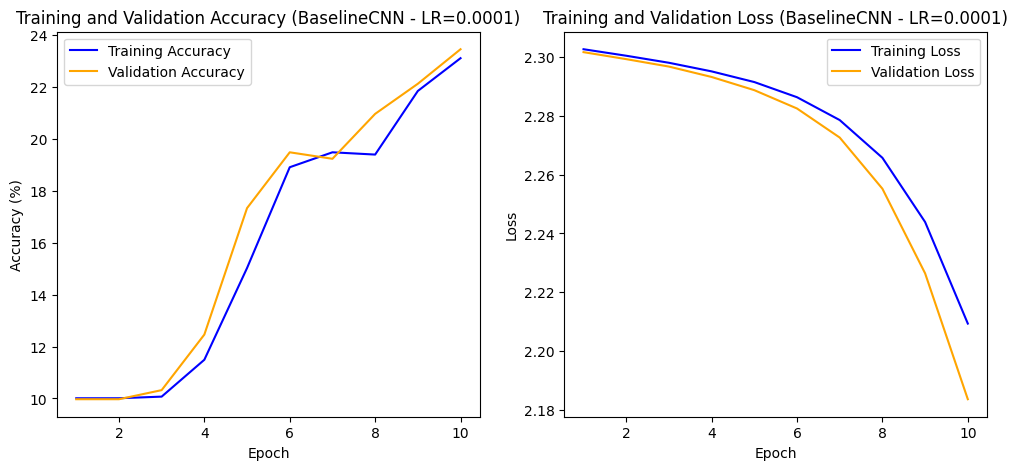


--- Experimenting with Model: ResNet18 ---

Training ResNet18 with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 67.83it/s]


Epoch [1/10], Training Loss: 2.1532, Training Accuracy: 26.17%, Validation Accuracy: 32.25%


100%|██████████| 157/157 [00:02<00:00, 68.61it/s]


Epoch [2/10], Training Loss: 1.6387, Training Accuracy: 38.97%, Validation Accuracy: 46.87%


100%|██████████| 157/157 [00:02<00:00, 71.50it/s]


Epoch [3/10], Training Loss: 1.4642, Training Accuracy: 46.82%, Validation Accuracy: 47.68%


100%|██████████| 157/157 [00:02<00:00, 68.35it/s]


Epoch [4/10], Training Loss: 1.3335, Training Accuracy: 52.13%, Validation Accuracy: 53.98%


100%|██████████| 157/157 [00:02<00:00, 63.07it/s]


Epoch [5/10], Training Loss: 1.2267, Training Accuracy: 56.26%, Validation Accuracy: 57.38%


100%|██████████| 157/157 [00:02<00:00, 60.10it/s]


Epoch [6/10], Training Loss: 1.1564, Training Accuracy: 58.88%, Validation Accuracy: 59.63%


100%|██████████| 157/157 [00:02<00:00, 69.05it/s]


Epoch [7/10], Training Loss: 1.0915, Training Accuracy: 61.40%, Validation Accuracy: 59.99%


100%|██████████| 157/157 [00:02<00:00, 66.89it/s]


Epoch [8/10], Training Loss: 1.0298, Training Accuracy: 63.81%, Validation Accuracy: 61.94%


100%|██████████| 157/157 [00:02<00:00, 60.89it/s]


Epoch [9/10], Training Loss: 0.9854, Training Accuracy: 65.49%, Validation Accuracy: 66.73%


100%|██████████| 157/157 [00:02<00:00, 63.65it/s]


Epoch [10/10], Training Loss: 0.9416, Training Accuracy: 67.36%, Validation Accuracy: 65.32%


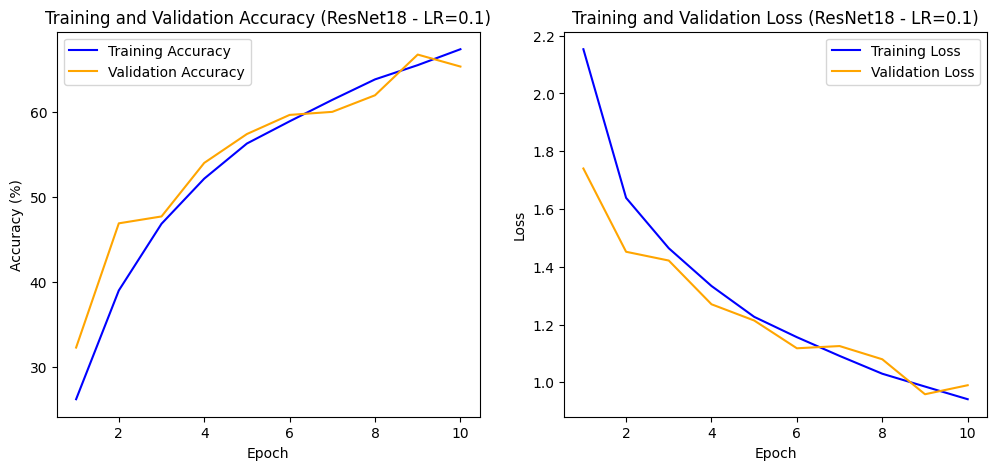


Training ResNet18 with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 63.48it/s]


Epoch [1/10], Training Loss: 1.8536, Training Accuracy: 35.32%, Validation Accuracy: 42.75%


100%|██████████| 157/157 [00:02<00:00, 63.85it/s]


Epoch [2/10], Training Loss: 1.4578, Training Accuracy: 47.91%, Validation Accuracy: 49.55%


100%|██████████| 157/157 [00:02<00:00, 69.55it/s]


Epoch [3/10], Training Loss: 1.2893, Training Accuracy: 53.96%, Validation Accuracy: 58.04%


100%|██████████| 157/157 [00:02<00:00, 69.95it/s]


Epoch [4/10], Training Loss: 1.1438, Training Accuracy: 59.40%, Validation Accuracy: 61.13%


100%|██████████| 157/157 [00:02<00:00, 70.16it/s]


Epoch [5/10], Training Loss: 1.0560, Training Accuracy: 62.79%, Validation Accuracy: 64.32%


100%|██████████| 157/157 [00:02<00:00, 69.37it/s]


Epoch [6/10], Training Loss: 0.9667, Training Accuracy: 65.99%, Validation Accuracy: 65.13%


100%|██████████| 157/157 [00:02<00:00, 68.66it/s]


Epoch [7/10], Training Loss: 0.9071, Training Accuracy: 68.38%, Validation Accuracy: 69.01%


100%|██████████| 157/157 [00:02<00:00, 69.38it/s]


Epoch [8/10], Training Loss: 0.8627, Training Accuracy: 69.75%, Validation Accuracy: 69.74%


100%|██████████| 157/157 [00:02<00:00, 70.27it/s]


Epoch [9/10], Training Loss: 0.8168, Training Accuracy: 71.27%, Validation Accuracy: 69.77%


100%|██████████| 157/157 [00:02<00:00, 67.61it/s]


Epoch [10/10], Training Loss: 0.7777, Training Accuracy: 72.79%, Validation Accuracy: 71.94%


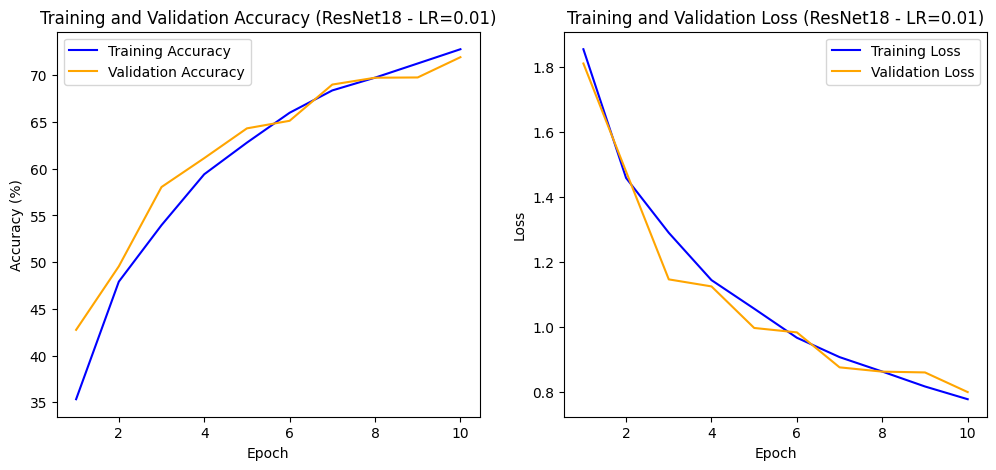


Training ResNet18 with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 68.56it/s]


Epoch [1/10], Training Loss: 1.9280, Training Accuracy: 33.34%, Validation Accuracy: 42.52%


100%|██████████| 157/157 [00:02<00:00, 71.28it/s]


Epoch [2/10], Training Loss: 1.5105, Training Accuracy: 44.60%, Validation Accuracy: 47.40%


100%|██████████| 157/157 [00:02<00:00, 67.73it/s]


Epoch [3/10], Training Loss: 1.3816, Training Accuracy: 50.10%, Validation Accuracy: 52.74%


100%|██████████| 157/157 [00:02<00:00, 69.65it/s]


Epoch [4/10], Training Loss: 1.2812, Training Accuracy: 53.69%, Validation Accuracy: 55.83%


100%|██████████| 157/157 [00:02<00:00, 65.42it/s]


Epoch [5/10], Training Loss: 1.1983, Training Accuracy: 57.02%, Validation Accuracy: 57.78%


100%|██████████| 157/157 [00:02<00:00, 69.43it/s]


Epoch [6/10], Training Loss: 1.1344, Training Accuracy: 59.28%, Validation Accuracy: 60.62%


100%|██████████| 157/157 [00:02<00:00, 69.94it/s]


Epoch [7/10], Training Loss: 1.0804, Training Accuracy: 61.40%, Validation Accuracy: 61.80%


100%|██████████| 157/157 [00:02<00:00, 64.16it/s]


Epoch [8/10], Training Loss: 1.0275, Training Accuracy: 63.34%, Validation Accuracy: 62.99%


100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


Epoch [9/10], Training Loss: 1.0014, Training Accuracy: 64.12%, Validation Accuracy: 64.40%


100%|██████████| 157/157 [00:02<00:00, 68.25it/s]


Epoch [10/10], Training Loss: 0.9661, Training Accuracy: 65.58%, Validation Accuracy: 66.25%


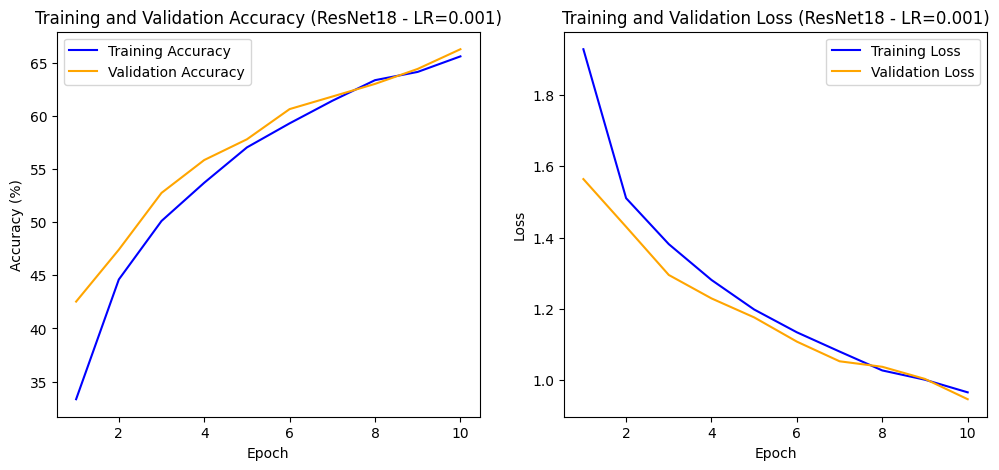


Training ResNet18 with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 68.26it/s]


Epoch [1/10], Training Loss: 2.8758, Training Accuracy: 22.32%, Validation Accuracy: 30.60%


100%|██████████| 157/157 [00:02<00:00, 65.24it/s]


Epoch [2/10], Training Loss: 1.8369, Training Accuracy: 33.15%, Validation Accuracy: 36.98%


100%|██████████| 157/157 [00:02<00:00, 68.22it/s]


Epoch [3/10], Training Loss: 1.7030, Training Accuracy: 37.64%, Validation Accuracy: 39.55%


100%|██████████| 157/157 [00:02<00:00, 65.39it/s]


Epoch [4/10], Training Loss: 1.6347, Training Accuracy: 40.05%, Validation Accuracy: 41.68%


100%|██████████| 157/157 [00:02<00:00, 60.45it/s]


Epoch [5/10], Training Loss: 1.5787, Training Accuracy: 42.16%, Validation Accuracy: 43.17%


100%|██████████| 157/157 [00:02<00:00, 69.54it/s]


Epoch [6/10], Training Loss: 1.5395, Training Accuracy: 43.75%, Validation Accuracy: 45.67%


100%|██████████| 157/157 [00:02<00:00, 68.96it/s]


Epoch [7/10], Training Loss: 1.4963, Training Accuracy: 45.45%, Validation Accuracy: 46.77%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [8/10], Training Loss: 1.4653, Training Accuracy: 46.68%, Validation Accuracy: 48.00%


100%|██████████| 157/157 [00:02<00:00, 59.11it/s]


Epoch [9/10], Training Loss: 1.4328, Training Accuracy: 47.86%, Validation Accuracy: 48.99%


100%|██████████| 157/157 [00:02<00:00, 61.62it/s]


Epoch [10/10], Training Loss: 1.4027, Training Accuracy: 49.01%, Validation Accuracy: 50.19%


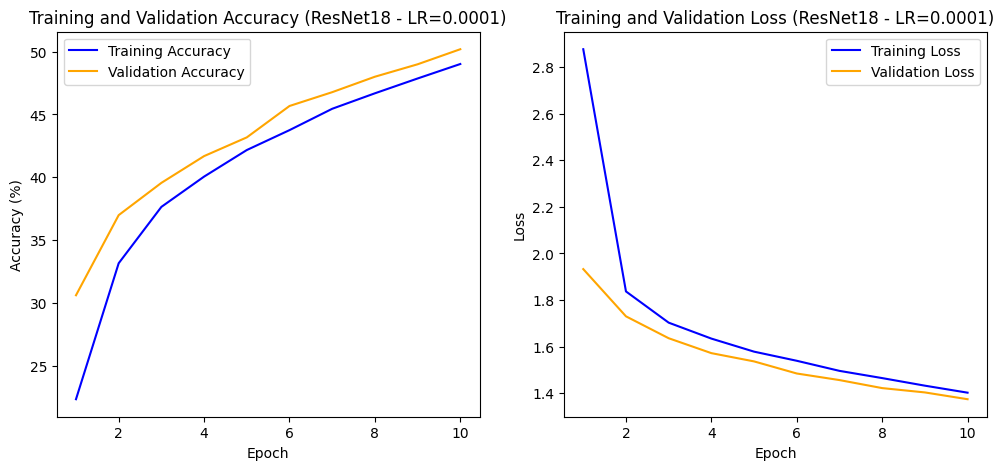


--- Experimenting with Model: ResNet34 ---

Training ResNet34 with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch [1/10], Training Loss: 2.4853, Training Accuracy: 20.66%, Validation Accuracy: 26.45%


100%|██████████| 157/157 [00:02<00:00, 67.37it/s]


Epoch [2/10], Training Loss: 1.8353, Training Accuracy: 31.51%, Validation Accuracy: 33.00%


100%|██████████| 157/157 [00:02<00:00, 65.35it/s]


Epoch [3/10], Training Loss: 1.7754, Training Accuracy: 33.94%, Validation Accuracy: 38.88%


100%|██████████| 157/157 [00:02<00:00, 70.96it/s]


Epoch [4/10], Training Loss: 1.6406, Training Accuracy: 39.32%, Validation Accuracy: 41.97%


100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


Epoch [5/10], Training Loss: 1.5327, Training Accuracy: 43.64%, Validation Accuracy: 45.02%


100%|██████████| 157/157 [00:02<00:00, 68.20it/s]


Epoch [6/10], Training Loss: 1.4535, Training Accuracy: 47.35%, Validation Accuracy: 47.98%


100%|██████████| 157/157 [00:02<00:00, 67.63it/s]


Epoch [7/10], Training Loss: 1.3965, Training Accuracy: 49.36%, Validation Accuracy: 52.58%


100%|██████████| 157/157 [00:02<00:00, 67.41it/s]


Epoch [8/10], Training Loss: 1.3363, Training Accuracy: 52.02%, Validation Accuracy: 53.97%


100%|██████████| 157/157 [00:02<00:00, 71.18it/s]


Epoch [9/10], Training Loss: 1.2576, Training Accuracy: 55.07%, Validation Accuracy: 56.46%


100%|██████████| 157/157 [00:02<00:00, 67.94it/s]


Epoch [10/10], Training Loss: 1.1969, Training Accuracy: 57.42%, Validation Accuracy: 56.00%


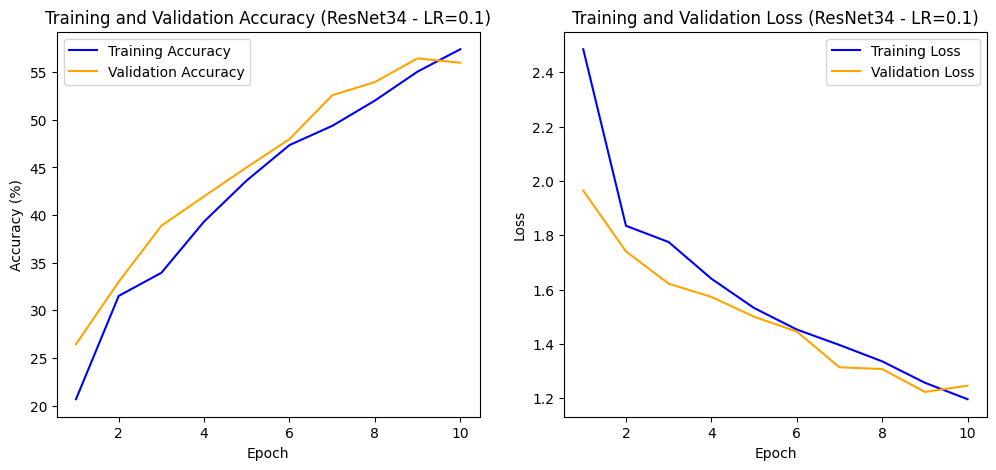


Training ResNet34 with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 66.82it/s]


Epoch [1/10], Training Loss: 1.9573, Training Accuracy: 32.79%, Validation Accuracy: 40.74%


100%|██████████| 157/157 [00:02<00:00, 67.16it/s]


Epoch [2/10], Training Loss: 1.5859, Training Accuracy: 43.73%, Validation Accuracy: 42.36%


100%|██████████| 157/157 [00:02<00:00, 66.69it/s]


Epoch [3/10], Training Loss: 1.4366, Training Accuracy: 48.85%, Validation Accuracy: 52.04%


100%|██████████| 157/157 [00:02<00:00, 68.82it/s]


Epoch [4/10], Training Loss: 1.3247, Training Accuracy: 53.33%, Validation Accuracy: 51.96%


100%|██████████| 157/157 [00:02<00:00, 66.74it/s]


Epoch [5/10], Training Loss: 1.1968, Training Accuracy: 57.62%, Validation Accuracy: 59.62%


100%|██████████| 157/157 [00:02<00:00, 64.87it/s]


Epoch [6/10], Training Loss: 1.1395, Training Accuracy: 59.90%, Validation Accuracy: 60.58%


100%|██████████| 157/157 [00:02<00:00, 70.49it/s]


Epoch [7/10], Training Loss: 1.0534, Training Accuracy: 63.23%, Validation Accuracy: 65.13%


100%|██████████| 157/157 [00:02<00:00, 69.73it/s]


Epoch [8/10], Training Loss: 0.9749, Training Accuracy: 65.70%, Validation Accuracy: 66.77%


100%|██████████| 157/157 [00:02<00:00, 70.18it/s]


Epoch [9/10], Training Loss: 0.9212, Training Accuracy: 67.70%, Validation Accuracy: 69.48%


100%|██████████| 157/157 [00:02<00:00, 65.46it/s]


Epoch [10/10], Training Loss: 0.8816, Training Accuracy: 69.42%, Validation Accuracy: 69.51%


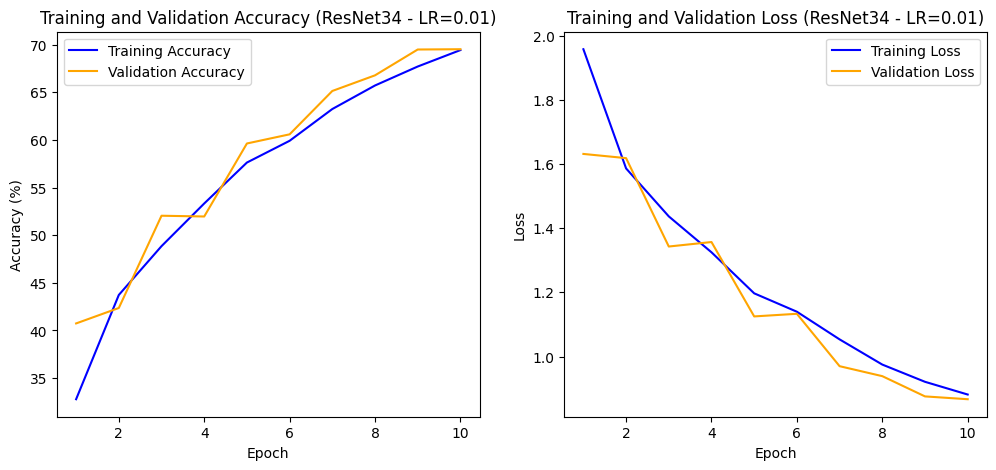


Training ResNet34 with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 66.72it/s]


Epoch [1/10], Training Loss: 1.9979, Training Accuracy: 30.75%, Validation Accuracy: 38.38%


100%|██████████| 157/157 [00:02<00:00, 67.98it/s]


Epoch [2/10], Training Loss: 1.6035, Training Accuracy: 40.91%, Validation Accuracy: 44.25%


100%|██████████| 157/157 [00:02<00:00, 66.47it/s]


Epoch [3/10], Training Loss: 1.4672, Training Accuracy: 46.36%, Validation Accuracy: 49.07%


100%|██████████| 157/157 [00:02<00:00, 66.73it/s]


Epoch [4/10], Training Loss: 1.3734, Training Accuracy: 49.84%, Validation Accuracy: 51.70%


100%|██████████| 157/157 [00:02<00:00, 69.68it/s]


Epoch [5/10], Training Loss: 1.3040, Training Accuracy: 52.63%, Validation Accuracy: 54.28%


100%|██████████| 157/157 [00:02<00:00, 68.81it/s]


Epoch [6/10], Training Loss: 1.2280, Training Accuracy: 55.72%, Validation Accuracy: 55.81%


100%|██████████| 157/157 [00:02<00:00, 66.37it/s]


Epoch [7/10], Training Loss: 1.1784, Training Accuracy: 57.62%, Validation Accuracy: 57.37%


100%|██████████| 157/157 [00:02<00:00, 69.45it/s]


Epoch [8/10], Training Loss: 1.1314, Training Accuracy: 59.39%, Validation Accuracy: 59.72%


100%|██████████| 157/157 [00:02<00:00, 67.74it/s]


Epoch [9/10], Training Loss: 1.0924, Training Accuracy: 60.91%, Validation Accuracy: 60.43%


100%|██████████| 157/157 [00:02<00:00, 69.21it/s]


Epoch [10/10], Training Loss: 1.0503, Training Accuracy: 62.38%, Validation Accuracy: 62.30%


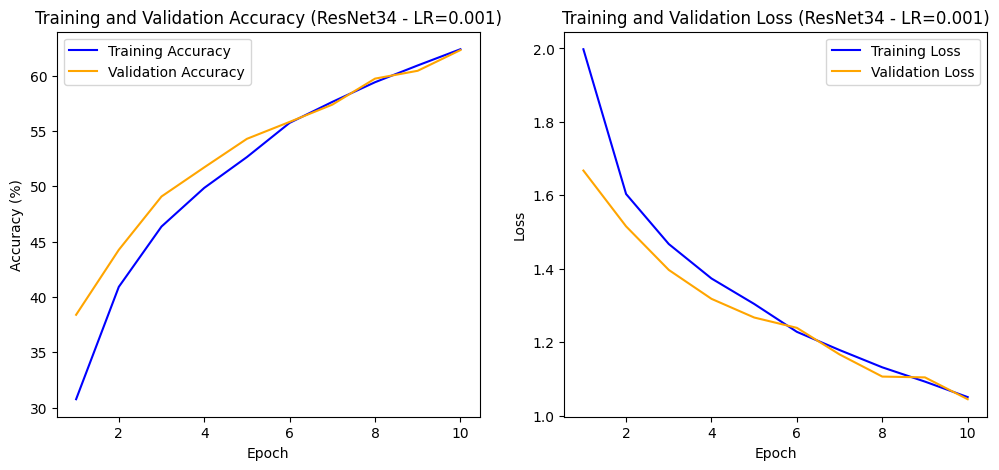


Training ResNet34 with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 65.44it/s]


Epoch [1/10], Training Loss: 2.7256, Training Accuracy: 20.01%, Validation Accuracy: 27.00%


100%|██████████| 157/157 [00:02<00:00, 68.65it/s]


Epoch [2/10], Training Loss: 1.9243, Training Accuracy: 29.76%, Validation Accuracy: 32.13%


100%|██████████| 157/157 [00:02<00:00, 66.04it/s]


Epoch [3/10], Training Loss: 1.8075, Training Accuracy: 33.45%, Validation Accuracy: 35.68%


100%|██████████| 157/157 [00:02<00:00, 69.07it/s]


Epoch [4/10], Training Loss: 1.7219, Training Accuracy: 36.58%, Validation Accuracy: 38.73%


100%|██████████| 157/157 [00:02<00:00, 66.98it/s]


Epoch [5/10], Training Loss: 1.6725, Training Accuracy: 37.99%, Validation Accuracy: 40.68%


100%|██████████| 157/157 [00:02<00:00, 66.95it/s]


Epoch [6/10], Training Loss: 1.6263, Training Accuracy: 40.39%, Validation Accuracy: 41.60%


100%|██████████| 157/157 [00:02<00:00, 67.27it/s]


Epoch [7/10], Training Loss: 1.5866, Training Accuracy: 41.85%, Validation Accuracy: 43.09%


100%|██████████| 157/157 [00:02<00:00, 70.01it/s]


Epoch [8/10], Training Loss: 1.5515, Training Accuracy: 42.90%, Validation Accuracy: 43.53%


100%|██████████| 157/157 [00:02<00:00, 67.14it/s]


Epoch [9/10], Training Loss: 1.5217, Training Accuracy: 44.24%, Validation Accuracy: 46.42%


100%|██████████| 157/157 [00:02<00:00, 68.03it/s]


Epoch [10/10], Training Loss: 1.4929, Training Accuracy: 45.19%, Validation Accuracy: 46.14%


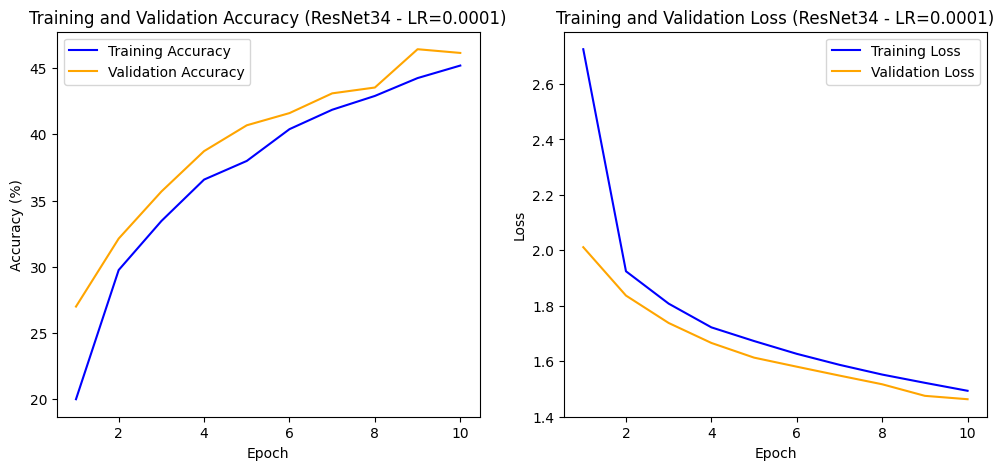


--- Experimenting with Model: ResNet50 ---

Training ResNet50 with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 65.80it/s]


Epoch [1/10], Training Loss: 4.1107, Training Accuracy: 11.81%, Validation Accuracy: 15.73%


100%|██████████| 157/157 [00:02<00:00, 67.59it/s]


Epoch [2/10], Training Loss: 2.0966, Training Accuracy: 19.00%, Validation Accuracy: 23.92%


100%|██████████| 157/157 [00:02<00:00, 69.21it/s]


Epoch [3/10], Training Loss: 1.9279, Training Accuracy: 26.33%, Validation Accuracy: 29.90%


100%|██████████| 157/157 [00:02<00:00, 69.28it/s]


Epoch [4/10], Training Loss: 1.8416, Training Accuracy: 30.06%, Validation Accuracy: 29.68%


100%|██████████| 157/157 [00:02<00:00, 68.20it/s]


Epoch [5/10], Training Loss: 1.7806, Training Accuracy: 32.77%, Validation Accuracy: 34.16%


100%|██████████| 157/157 [00:02<00:00, 67.82it/s]


Epoch [6/10], Training Loss: 1.7180, Training Accuracy: 35.82%, Validation Accuracy: 37.80%


100%|██████████| 157/157 [00:02<00:00, 67.06it/s]


Epoch [7/10], Training Loss: 1.6821, Training Accuracy: 37.80%, Validation Accuracy: 39.24%


100%|██████████| 157/157 [00:02<00:00, 68.06it/s]


Epoch [8/10], Training Loss: 1.6407, Training Accuracy: 39.12%, Validation Accuracy: 40.47%


100%|██████████| 157/157 [00:02<00:00, 66.96it/s]


Epoch [9/10], Training Loss: 1.5851, Training Accuracy: 41.47%, Validation Accuracy: 41.77%


100%|██████████| 157/157 [00:02<00:00, 67.35it/s]


Epoch [10/10], Training Loss: 1.5449, Training Accuracy: 43.45%, Validation Accuracy: 43.99%


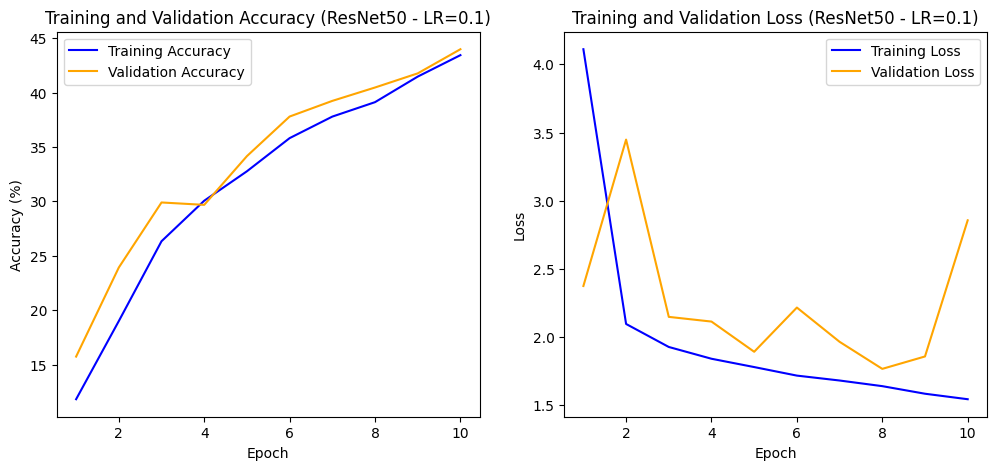


Training ResNet50 with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 68.50it/s]


Epoch [1/10], Training Loss: 3.2879, Training Accuracy: 24.88%, Validation Accuracy: 29.95%


100%|██████████| 157/157 [00:02<00:00, 69.27it/s]


Epoch [2/10], Training Loss: 2.4768, Training Accuracy: 28.69%, Validation Accuracy: 32.19%


100%|██████████| 157/157 [00:02<00:00, 68.11it/s]


Epoch [3/10], Training Loss: 2.1273, Training Accuracy: 35.90%, Validation Accuracy: 40.25%


100%|██████████| 157/157 [00:02<00:00, 67.69it/s]


Epoch [4/10], Training Loss: 1.9626, Training Accuracy: 39.83%, Validation Accuracy: 42.53%


100%|██████████| 157/157 [00:02<00:00, 68.59it/s]


Epoch [5/10], Training Loss: 1.8609, Training Accuracy: 42.20%, Validation Accuracy: 45.14%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [6/10], Training Loss: 1.7017, Training Accuracy: 45.45%, Validation Accuracy: 44.74%


100%|██████████| 157/157 [00:02<00:00, 67.77it/s]


Epoch [7/10], Training Loss: 1.6895, Training Accuracy: 47.11%, Validation Accuracy: 49.33%


100%|██████████| 157/157 [00:02<00:00, 68.18it/s]


Epoch [8/10], Training Loss: 1.6528, Training Accuracy: 47.02%, Validation Accuracy: 48.44%


100%|██████████| 157/157 [00:02<00:00, 66.55it/s]


Epoch [9/10], Training Loss: 1.6323, Training Accuracy: 47.70%, Validation Accuracy: 49.27%


100%|██████████| 157/157 [00:02<00:00, 66.15it/s]


Epoch [10/10], Training Loss: 1.6257, Training Accuracy: 49.06%, Validation Accuracy: 47.56%


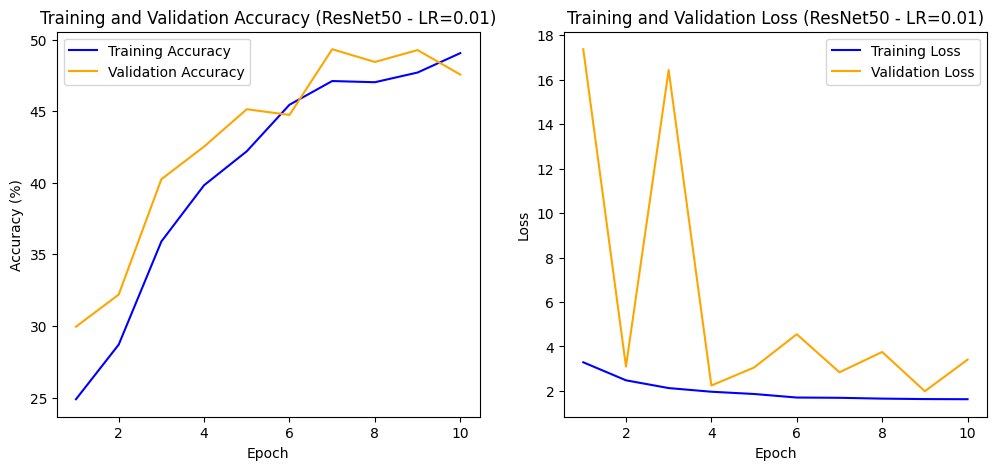


Training ResNet50 with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 68.82it/s]


Epoch [1/10], Training Loss: 2.2954, Training Accuracy: 21.27%, Validation Accuracy: 26.74%


100%|██████████| 157/157 [00:02<00:00, 65.52it/s]


Epoch [2/10], Training Loss: 1.9552, Training Accuracy: 30.33%, Validation Accuracy: 35.66%


100%|██████████| 157/157 [00:02<00:00, 67.77it/s]


Epoch [3/10], Training Loss: 1.8044, Training Accuracy: 35.05%, Validation Accuracy: 38.17%


100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch [4/10], Training Loss: 1.7112, Training Accuracy: 38.25%, Validation Accuracy: 40.67%


100%|██████████| 157/157 [00:02<00:00, 67.71it/s]


Epoch [5/10], Training Loss: 1.6364, Training Accuracy: 40.96%, Validation Accuracy: 43.22%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [6/10], Training Loss: 1.5797, Training Accuracy: 42.81%, Validation Accuracy: 44.42%


100%|██████████| 157/157 [00:02<00:00, 67.43it/s]


Epoch [7/10], Training Loss: 1.5348, Training Accuracy: 44.59%, Validation Accuracy: 46.61%


100%|██████████| 157/157 [00:02<00:00, 67.69it/s]


Epoch [8/10], Training Loss: 1.4854, Training Accuracy: 46.51%, Validation Accuracy: 47.21%


100%|██████████| 157/157 [00:02<00:00, 67.18it/s]


Epoch [9/10], Training Loss: 1.4530, Training Accuracy: 47.96%, Validation Accuracy: 49.20%


100%|██████████| 157/157 [00:02<00:00, 65.06it/s]


Epoch [10/10], Training Loss: 1.4174, Training Accuracy: 48.98%, Validation Accuracy: 50.58%


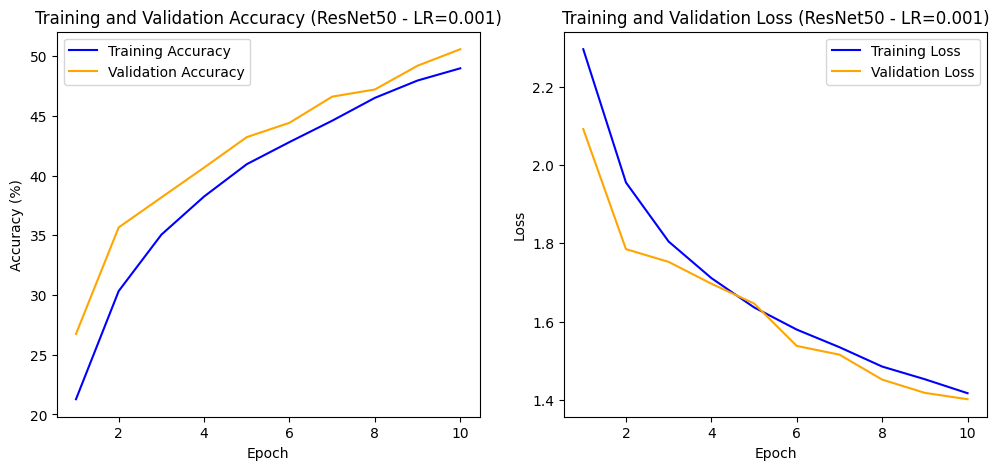


Training ResNet50 with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 67.25it/s]


Epoch [1/10], Training Loss: 2.6001, Training Accuracy: 12.58%, Validation Accuracy: 14.32%


100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


Epoch [2/10], Training Loss: 2.2914, Training Accuracy: 15.64%, Validation Accuracy: 17.24%


100%|██████████| 157/157 [00:02<00:00, 67.70it/s]


Epoch [3/10], Training Loss: 2.1912, Training Accuracy: 18.74%, Validation Accuracy: 21.09%


100%|██████████| 157/157 [00:02<00:00, 68.78it/s]


Epoch [4/10], Training Loss: 2.1065, Training Accuracy: 21.51%, Validation Accuracy: 23.66%


100%|██████████| 157/157 [00:02<00:00, 66.08it/s]


Epoch [5/10], Training Loss: 2.0603, Training Accuracy: 23.36%, Validation Accuracy: 24.82%


100%|██████████| 157/157 [00:02<00:00, 67.68it/s]


Epoch [6/10], Training Loss: 2.0267, Training Accuracy: 25.05%, Validation Accuracy: 27.12%


100%|██████████| 157/157 [00:02<00:00, 66.24it/s]


Epoch [7/10], Training Loss: 1.9727, Training Accuracy: 26.49%, Validation Accuracy: 28.69%


100%|██████████| 157/157 [00:02<00:00, 66.76it/s]


Epoch [8/10], Training Loss: 1.9307, Training Accuracy: 28.61%, Validation Accuracy: 29.89%


100%|██████████| 157/157 [00:02<00:00, 68.38it/s]


Epoch [9/10], Training Loss: 1.8906, Training Accuracy: 29.87%, Validation Accuracy: 31.54%


100%|██████████| 157/157 [00:02<00:00, 67.42it/s]


Epoch [10/10], Training Loss: 1.8574, Training Accuracy: 30.96%, Validation Accuracy: 32.25%


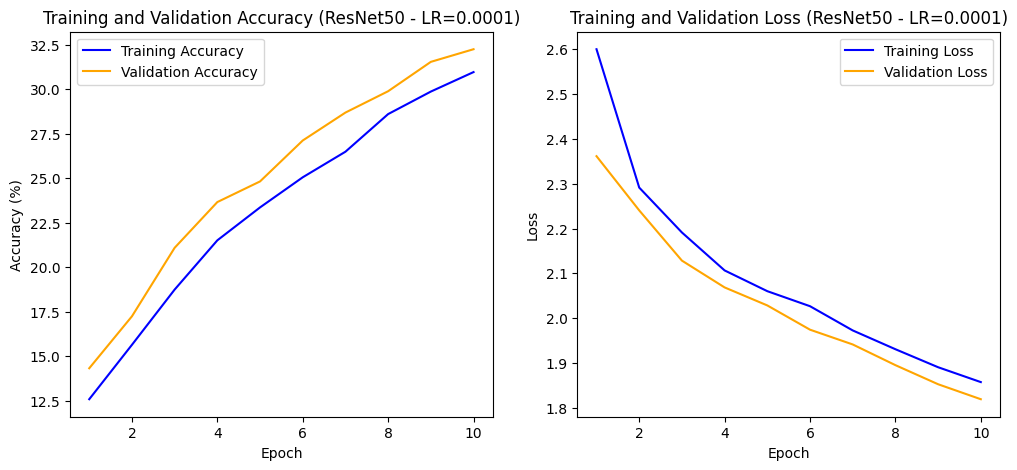


--- Experimenting with Model: VGG16 ---

Training VGG16 with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 67.29it/s]


Epoch [1/10], Training Loss: nan, Training Accuracy: 9.94%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 65.24it/s]


Epoch [2/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 69.73it/s]


Epoch [3/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 66.98it/s]


Epoch [4/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.76it/s]


Epoch [5/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.29it/s]


Epoch [6/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 66.78it/s]


Epoch [7/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 67.83it/s]


Epoch [8/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.10it/s]


Epoch [9/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 67.27it/s]


Epoch [10/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


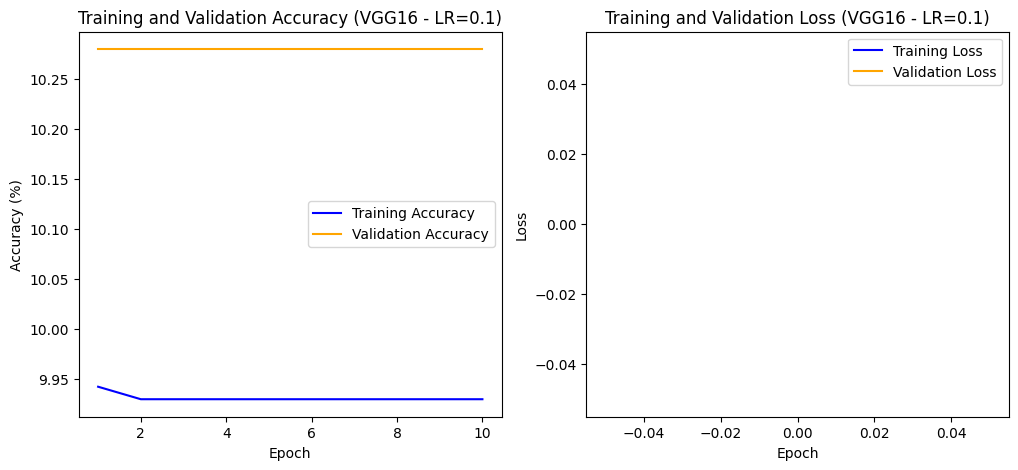


Training VGG16 with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 65.92it/s]


Epoch [1/10], Training Loss: 2.5699, Training Accuracy: 15.32%, Validation Accuracy: 21.09%


100%|██████████| 157/157 [00:02<00:00, 69.30it/s]


Epoch [2/10], Training Loss: 1.8810, Training Accuracy: 27.67%, Validation Accuracy: 31.98%


100%|██████████| 157/157 [00:02<00:00, 68.42it/s]


Epoch [3/10], Training Loss: 1.6693, Training Accuracy: 36.74%, Validation Accuracy: 40.28%


100%|██████████| 157/157 [00:02<00:00, 62.58it/s]


Epoch [4/10], Training Loss: 1.4965, Training Accuracy: 45.26%, Validation Accuracy: 49.47%


100%|██████████| 157/157 [00:02<00:00, 68.67it/s]


Epoch [5/10], Training Loss: 1.3026, Training Accuracy: 53.22%, Validation Accuracy: 58.54%


100%|██████████| 157/157 [00:02<00:00, 64.84it/s]


Epoch [6/10], Training Loss: 1.1512, Training Accuracy: 59.61%, Validation Accuracy: 61.22%


100%|██████████| 157/157 [00:02<00:00, 68.01it/s]


Epoch [7/10], Training Loss: 1.0136, Training Accuracy: 64.90%, Validation Accuracy: 64.87%


100%|██████████| 157/157 [00:02<00:00, 67.48it/s]


Epoch [8/10], Training Loss: 0.9278, Training Accuracy: 68.19%, Validation Accuracy: 71.36%


100%|██████████| 157/157 [00:02<00:00, 70.14it/s]


Epoch [9/10], Training Loss: 0.8386, Training Accuracy: 71.42%, Validation Accuracy: 72.84%


100%|██████████| 157/157 [00:02<00:00, 68.51it/s]


Epoch [10/10], Training Loss: 0.7795, Training Accuracy: 73.67%, Validation Accuracy: 71.44%


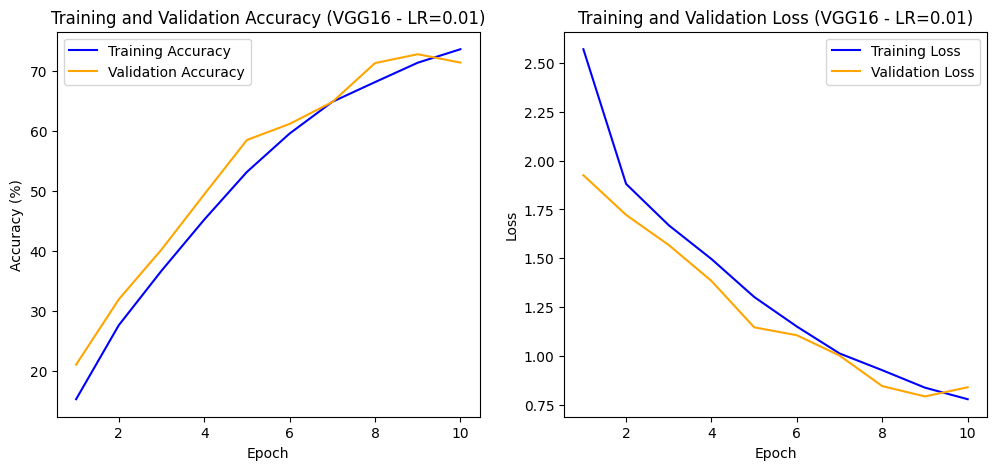


Training VGG16 with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 67.44it/s]


Epoch [1/10], Training Loss: 2.5030, Training Accuracy: 13.02%, Validation Accuracy: 22.54%


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


Epoch [2/10], Training Loss: 1.9177, Training Accuracy: 24.91%, Validation Accuracy: 29.37%


100%|██████████| 157/157 [00:02<00:00, 66.37it/s]


Epoch [3/10], Training Loss: 1.7023, Training Accuracy: 34.73%, Validation Accuracy: 40.34%


100%|██████████| 157/157 [00:02<00:00, 68.64it/s]


Epoch [4/10], Training Loss: 1.5335, Training Accuracy: 42.00%, Validation Accuracy: 47.09%


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


Epoch [5/10], Training Loss: 1.3965, Training Accuracy: 48.25%, Validation Accuracy: 50.89%


100%|██████████| 157/157 [00:02<00:00, 67.81it/s]


Epoch [6/10], Training Loss: 1.2566, Training Accuracy: 53.99%, Validation Accuracy: 56.94%


100%|██████████| 157/157 [00:02<00:00, 68.88it/s]


Epoch [7/10], Training Loss: 1.1529, Training Accuracy: 58.27%, Validation Accuracy: 62.14%


100%|██████████| 157/157 [00:02<00:00, 67.63it/s]


Epoch [8/10], Training Loss: 1.0700, Training Accuracy: 61.40%, Validation Accuracy: 64.43%


100%|██████████| 157/157 [00:02<00:00, 68.41it/s]


Epoch [9/10], Training Loss: 1.0063, Training Accuracy: 63.70%, Validation Accuracy: 65.35%


100%|██████████| 157/157 [00:02<00:00, 67.73it/s]


Epoch [10/10], Training Loss: 0.9400, Training Accuracy: 66.45%, Validation Accuracy: 68.70%


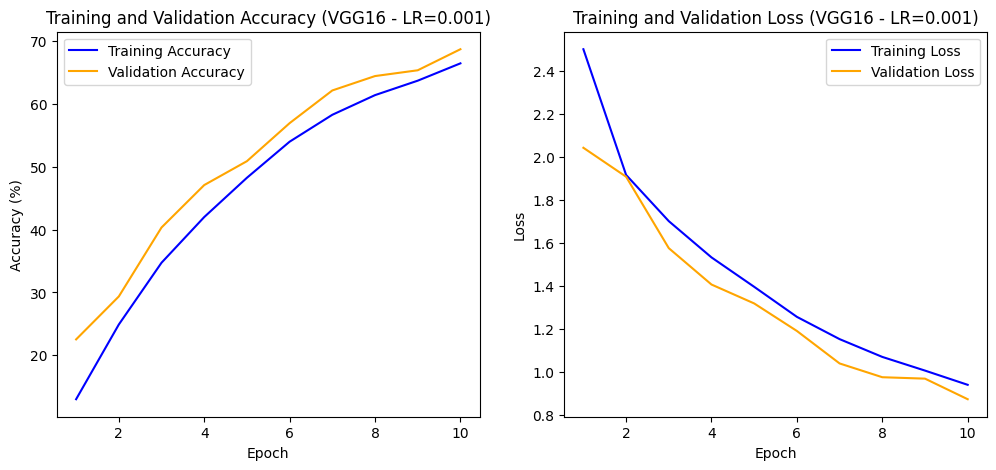


Training VGG16 with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


Epoch [1/10], Training Loss: 3.2550, Training Accuracy: 9.26%, Validation Accuracy: 10.15%


100%|██████████| 157/157 [00:02<00:00, 62.84it/s]


Epoch [2/10], Training Loss: 2.3777, Training Accuracy: 11.09%, Validation Accuracy: 17.18%


100%|██████████| 157/157 [00:02<00:00, 65.96it/s]


Epoch [3/10], Training Loss: 2.2629, Training Accuracy: 15.28%, Validation Accuracy: 20.85%


100%|██████████| 157/157 [00:02<00:00, 66.76it/s]


Epoch [4/10], Training Loss: 2.1295, Training Accuracy: 19.70%, Validation Accuracy: 21.86%


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch [5/10], Training Loss: 2.0376, Training Accuracy: 22.49%, Validation Accuracy: 28.50%


100%|██████████| 157/157 [00:02<00:00, 67.35it/s]


Epoch [6/10], Training Loss: 1.9403, Training Accuracy: 25.79%, Validation Accuracy: 29.44%


100%|██████████| 157/157 [00:02<00:00, 68.70it/s]


Epoch [7/10], Training Loss: 1.8844, Training Accuracy: 27.74%, Validation Accuracy: 30.74%


100%|██████████| 157/157 [00:02<00:00, 66.42it/s]


Epoch [8/10], Training Loss: 1.8327, Training Accuracy: 30.08%, Validation Accuracy: 33.77%


100%|██████████| 157/157 [00:02<00:00, 64.34it/s]


Epoch [9/10], Training Loss: 1.7777, Training Accuracy: 32.32%, Validation Accuracy: 35.08%


100%|██████████| 157/157 [00:02<00:00, 66.30it/s]


Epoch [10/10], Training Loss: 1.7347, Training Accuracy: 33.84%, Validation Accuracy: 36.18%


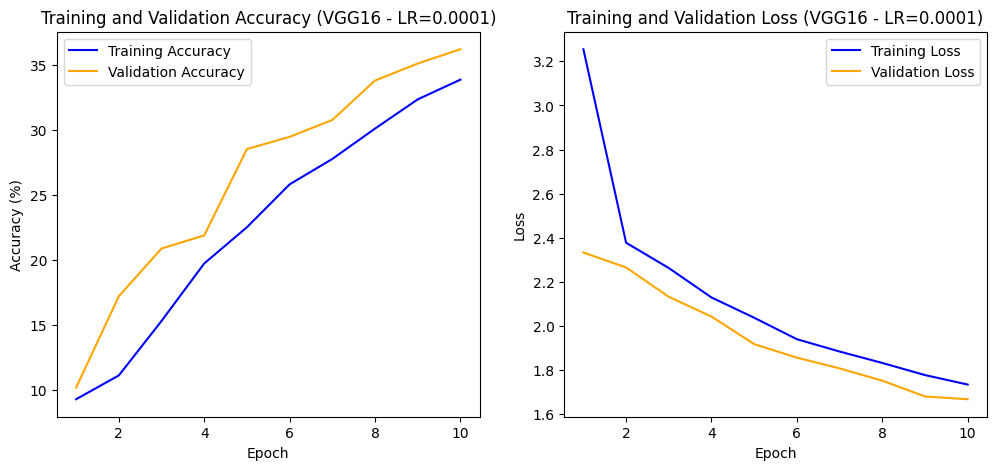


--- Experimenting with Model: VGG19 ---

Training VGG19 with Learning Rate: 0.1


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


Epoch [1/10], Training Loss: nan, Training Accuracy: 9.92%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.88it/s]


Epoch [2/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 70.65it/s]


Epoch [3/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 67.88it/s]


Epoch [4/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.58it/s]


Epoch [5/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


Epoch [6/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 67.87it/s]


Epoch [7/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 63.11it/s]


Epoch [8/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 68.70it/s]


Epoch [9/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


100%|██████████| 157/157 [00:02<00:00, 69.30it/s]


Epoch [10/10], Training Loss: nan, Training Accuracy: 9.93%, Validation Accuracy: 10.28%


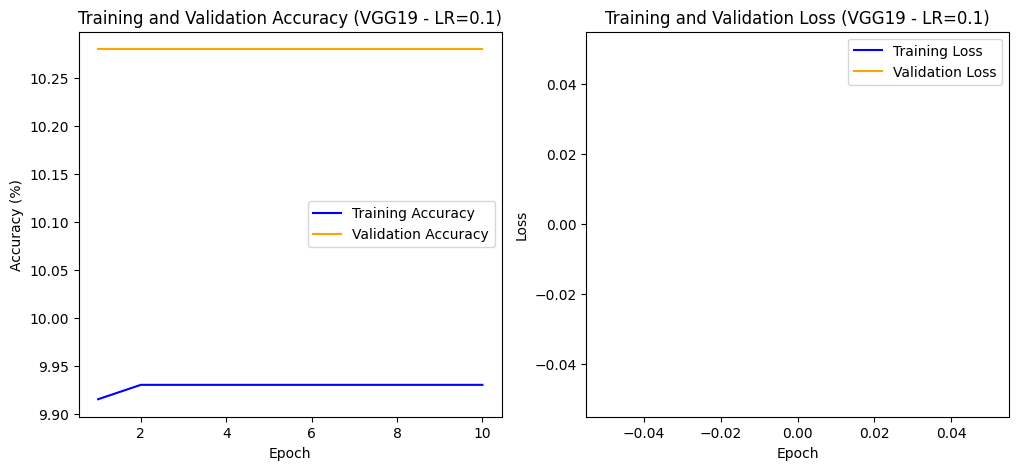


Training VGG19 with Learning Rate: 0.01


100%|██████████| 157/157 [00:02<00:00, 64.53it/s]


Epoch [1/10], Training Loss: 2.6779, Training Accuracy: 9.78%, Validation Accuracy: 9.92%


100%|██████████| 157/157 [00:02<00:00, 68.94it/s]


Epoch [2/10], Training Loss: 2.3402, Training Accuracy: 9.83%, Validation Accuracy: 9.87%


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Epoch [3/10], Training Loss: 2.3290, Training Accuracy: 10.16%, Validation Accuracy: 9.77%


100%|██████████| 157/157 [00:02<00:00, 66.14it/s]


Epoch [4/10], Training Loss: 2.0028, Training Accuracy: 19.84%, Validation Accuracy: 22.70%


100%|██████████| 157/157 [00:02<00:00, 65.64it/s]


Epoch [5/10], Training Loss: 1.8681, Training Accuracy: 24.96%, Validation Accuracy: 29.74%


100%|██████████| 157/157 [00:02<00:00, 63.87it/s]


Epoch [6/10], Training Loss: 1.6874, Training Accuracy: 34.27%, Validation Accuracy: 39.11%


100%|██████████| 157/157 [00:02<00:00, 66.15it/s]


Epoch [7/10], Training Loss: 1.4809, Training Accuracy: 44.29%, Validation Accuracy: 53.52%


100%|██████████| 157/157 [00:02<00:00, 65.93it/s]


Epoch [8/10], Training Loss: 1.2926, Training Accuracy: 53.30%, Validation Accuracy: 60.94%


100%|██████████| 157/157 [00:02<00:00, 68.23it/s]


Epoch [9/10], Training Loss: 1.1117, Training Accuracy: 61.22%, Validation Accuracy: 64.48%


100%|██████████| 157/157 [00:02<00:00, 66.61it/s]


Epoch [10/10], Training Loss: 0.9991, Training Accuracy: 65.61%, Validation Accuracy: 64.09%


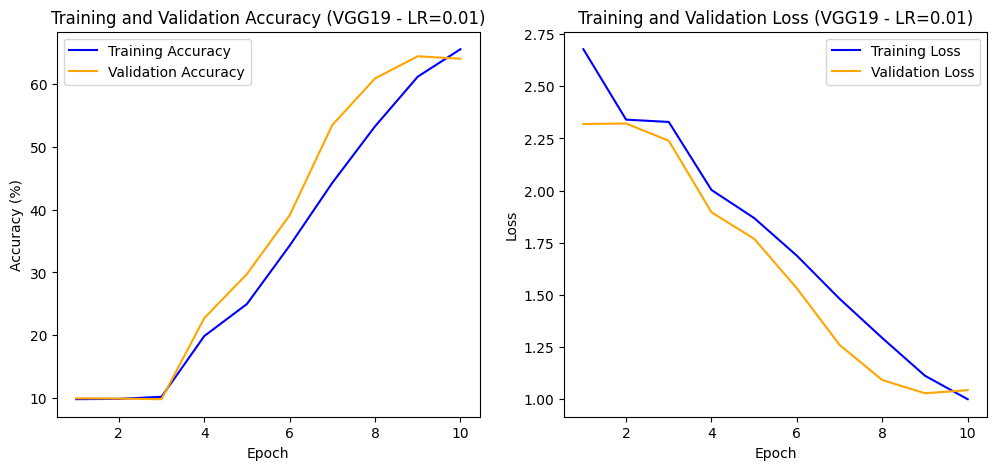


Training VGG19 with Learning Rate: 0.001


100%|██████████| 157/157 [00:02<00:00, 66.58it/s]


Epoch [1/10], Training Loss: 2.6150, Training Accuracy: 11.88%, Validation Accuracy: 20.09%


100%|██████████| 157/157 [00:02<00:00, 66.52it/s]


Epoch [2/10], Training Loss: 1.9851, Training Accuracy: 20.59%, Validation Accuracy: 26.84%


100%|██████████| 157/157 [00:02<00:00, 67.83it/s]


Epoch [3/10], Training Loss: 1.8228, Training Accuracy: 27.47%, Validation Accuracy: 35.82%


100%|██████████| 157/157 [00:02<00:00, 66.98it/s]


Epoch [4/10], Training Loss: 1.6439, Training Accuracy: 36.19%, Validation Accuracy: 41.30%


100%|██████████| 157/157 [00:02<00:00, 60.91it/s]


Epoch [5/10], Training Loss: 1.5116, Training Accuracy: 42.35%, Validation Accuracy: 48.30%


100%|██████████| 157/157 [00:02<00:00, 68.27it/s]


Epoch [6/10], Training Loss: 1.3726, Training Accuracy: 48.55%, Validation Accuracy: 51.84%


100%|██████████| 157/157 [00:02<00:00, 68.18it/s]


Epoch [7/10], Training Loss: 1.2709, Training Accuracy: 53.21%, Validation Accuracy: 57.77%


100%|██████████| 157/157 [00:02<00:00, 66.34it/s]


Epoch [8/10], Training Loss: 1.1658, Training Accuracy: 57.43%, Validation Accuracy: 60.72%


100%|██████████| 157/157 [00:02<00:00, 66.45it/s]


Epoch [9/10], Training Loss: 1.0832, Training Accuracy: 61.08%, Validation Accuracy: 63.31%


100%|██████████| 157/157 [00:02<00:00, 66.14it/s]


Epoch [10/10], Training Loss: 1.0182, Training Accuracy: 63.52%, Validation Accuracy: 65.55%


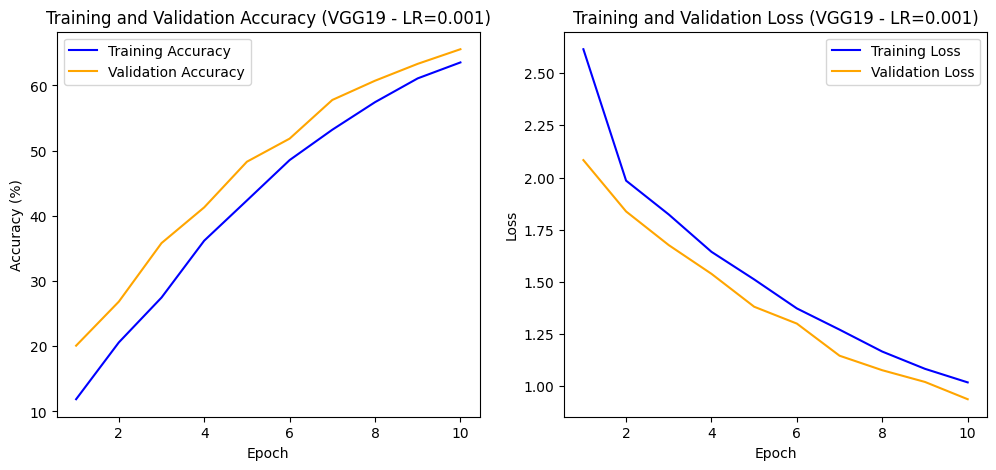


Training VGG19 with Learning Rate: 0.0001


100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


Epoch [1/10], Training Loss: 3.8001, Training Accuracy: 8.84%, Validation Accuracy: 9.91%


100%|██████████| 157/157 [00:02<00:00, 66.93it/s]


Epoch [2/10], Training Loss: 2.4029, Training Accuracy: 9.87%, Validation Accuracy: 9.84%


100%|██████████| 157/157 [00:02<00:00, 69.82it/s]


Epoch [3/10], Training Loss: 2.3669, Training Accuracy: 10.39%, Validation Accuracy: 13.72%


100%|██████████| 157/157 [00:02<00:00, 68.75it/s]


Epoch [4/10], Training Loss: 2.3447, Training Accuracy: 10.74%, Validation Accuracy: 15.29%


100%|██████████| 157/157 [00:02<00:00, 68.52it/s]


Epoch [5/10], Training Loss: 2.3148, Training Accuracy: 11.57%, Validation Accuracy: 15.58%


100%|██████████| 157/157 [00:02<00:00, 68.27it/s]


Epoch [6/10], Training Loss: 2.2079, Training Accuracy: 16.08%, Validation Accuracy: 23.47%


100%|██████████| 157/157 [00:02<00:00, 68.53it/s]


Epoch [7/10], Training Loss: 2.0496, Training Accuracy: 20.87%, Validation Accuracy: 25.77%


100%|██████████| 157/157 [00:02<00:00, 68.36it/s]


Epoch [8/10], Training Loss: 1.9550, Training Accuracy: 24.19%, Validation Accuracy: 28.68%


100%|██████████| 157/157 [00:02<00:00, 69.59it/s]


Epoch [9/10], Training Loss: 1.8777, Training Accuracy: 27.37%, Validation Accuracy: 31.09%


100%|██████████| 157/157 [00:02<00:00, 67.03it/s]


Epoch [10/10], Training Loss: 1.8269, Training Accuracy: 29.89%, Validation Accuracy: 31.92%


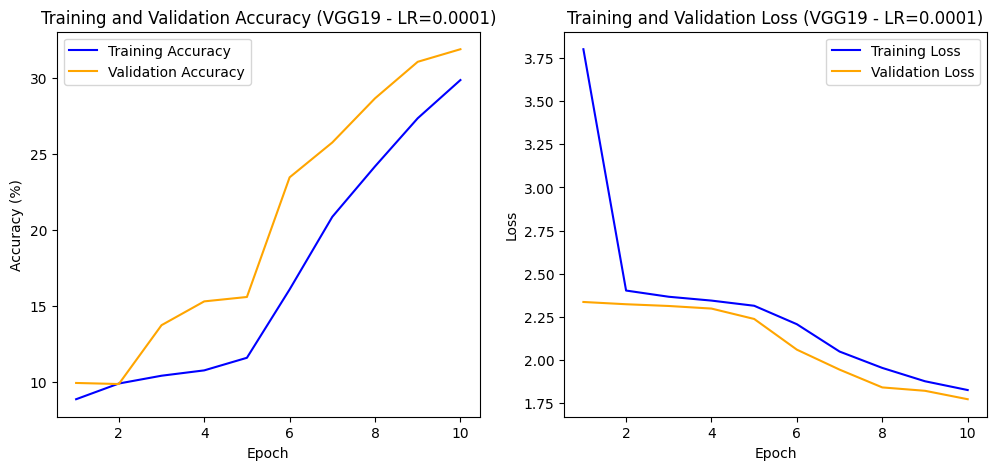

In [ ]:
# Experimenting with different learning rates on different architectures
# List of models and their names for tracking results
model_classes = [
    ("BaselineCNN", BaselineCNN),
    ("ResNet18", models.resnet18),
    ("ResNet34", models.resnet34),
    ("ResNet50", models.resnet50),
    ("VGG16", models.vgg16),
    ("VGG19", models.vgg19)
]

# Define learning rates to test
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Dictionary to store results
all_results = {}

for model_name, ModelClass in model_classes:
    print(f"\n--- Experimenting with Model: {model_name} ---")
    model_results = {}

    for lr in learning_rates:
        print(f"\nTraining {model_name} with Learning Rate: {lr}")

        # Initialize the model
        model = ModelClass().to(device)

        # Define the optimizer with the current learning rate
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        # Train and evaluate the model
        train_acc, val_acc, train_loss, val_loss = train_and_evaluate_model(
            model, train_loader, val_loader, num_epochs=10, learning_rate=lr
        )

        # Store the results for this learning rate
        model_results[lr] = {
            "train_acc": train_acc,
            "val_acc": val_acc,
            "train_loss": train_loss,
            "val_loss": val_loss
        }

        # Plot metrics for this learning rate
        plot_metrics(train_acc, val_acc, train_loss, val_loss, title_suffix=f"({model_name} - LR={lr})")

    # Store the model's results in the main results dictionary
    all_results[model_name] = model_results

# Create a summary table for each model and learning rate
summary_data = {
    "Model": [],
    "Learning Rate": [],
    "Final Training Accuracy": [],
    "Final Validation Accuracy": [],
    "Final Training Loss": [],
    "Final Validation Loss": []
}

for model_name, model_results in all_results.items():
    for lr, result in model_results.items():
        summary_data["Model"].append(model_name)
        summary_data["Learning Rate"].append(lr)
        summary_data["Final Training Accuracy"].append(result["train_acc"][-1])
        summary_data["Final Validation Accuracy"].append(result["val_acc"][-1])
        summary_data["Final Training Loss"].append(result["train_loss"][-1])
        summary_data["Final Validation Loss"].append(result["val_loss"][-1])




In [ ]:
#Summary of learnnig rate tuning results for all models
summary_df = pd.DataFrame(summary_data)
print("\nSummary of Learning Rate Tuning Results for All Models:")
print(summary_df)


Summary of Learning Rate Tuning Results for All Models:
          Model  Learning Rate  Final Training Accuracy  \
0   BaselineCNN         0.1000                  26.7550   
1   BaselineCNN         0.0100                  75.5725   
2   BaselineCNN         0.0010                  53.1900   
3   BaselineCNN         0.0001                  23.1050   
4      ResNet18         0.1000                  67.3600   
5      ResNet18         0.0100                  72.7925   
6      ResNet18         0.0010                  65.5775   
7      ResNet18         0.0001                  49.0125   
8      ResNet34         0.1000                  57.4175   
9      ResNet34         0.0100                  69.4200   
10     ResNet34         0.0010                  62.3775   
11     ResNet34         0.0001                  45.1875   
12     ResNet50         0.1000                  43.4450   
13     ResNet50         0.0100                  49.0575   
14     ResNet50         0.0010                  48.9825   

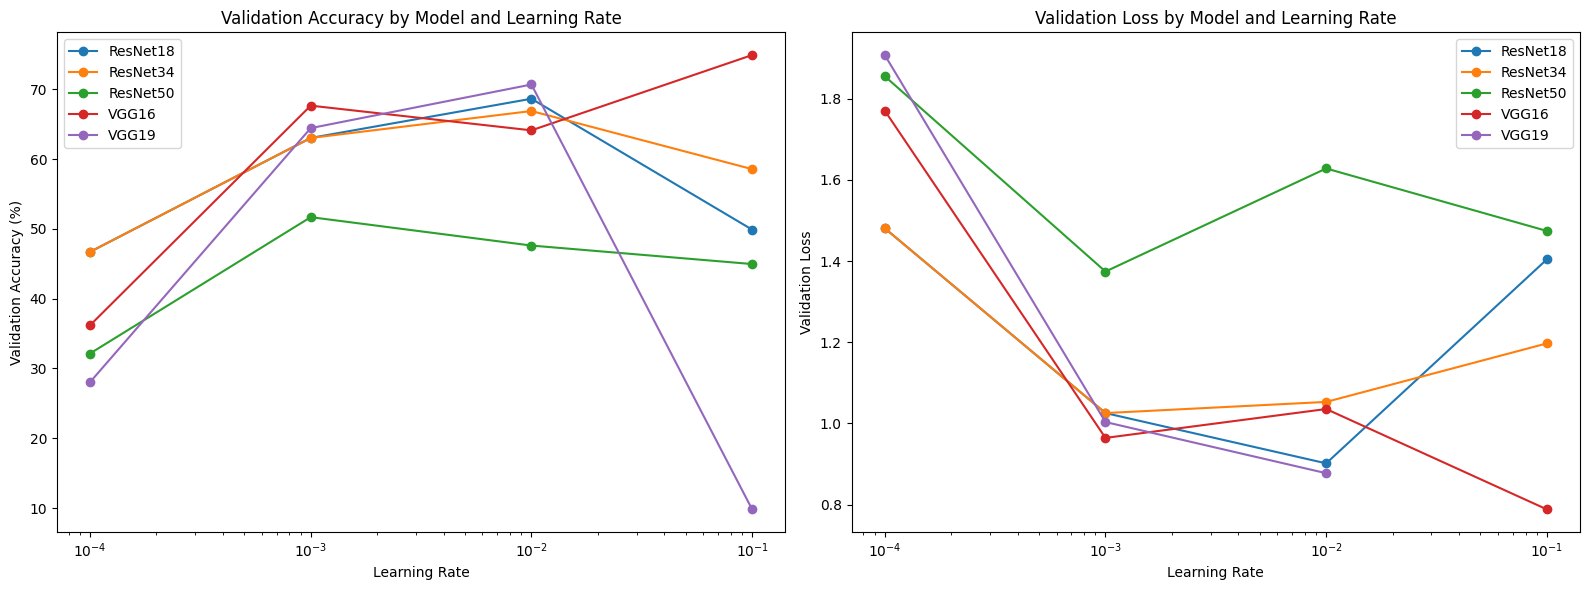

In [ ]:
#Visualizing the validation accuracies and losses for each model
comparison_data = {
    "Model": [
        "ResNet18", "ResNet18", "ResNet18", "ResNet18",
        "ResNet34", "ResNet34", "ResNet34", "ResNet34",
        "ResNet50", "ResNet50", "ResNet50", "ResNet50",
        "VGG16", "VGG16", "VGG16", "VGG16",
        "VGG19", "VGG19", "VGG19", "VGG19"
    ],
    "Learning Rate": [0.1, 0.01, 0.001, 0.0001] * 5,
    "Training Loss (Final Epoch)": [
        1.4043, 0.9016, 1.0255, 1.4809,
        1.1972, 1.0530, 1.0255, 1.4809,
        1.4743, 1.6283, 1.3743, 1.8557,
        0.7881, 1.0355, 0.9643, 1.7708,
        np.nan, 0.8773, 1.0034, 1.9078
    ],
    "Training Accuracy (Final Epoch)": [
        49.08, 68.20, 63.46, 45.61,
        57.27, 63.06, 63.46, 45.61,
        46.48, 47.09, 50.39, 31.48,
        73.46, 65.18, 65.55, 32.09,
        10.05, 70.46, 63.86, 23.52
    ],
    "Validation Loss (Final Epoch)": [
        1.4043, 0.9016, 1.0255, 1.4809,
        1.1972, 1.0530, 1.0255, 1.4809,
        1.4743, 1.6283, 1.3743, 1.8557,
        0.7881, 1.0355, 0.9643, 1.7708,
        np.nan, 0.8773, 1.0034, 1.9078
    ],
    "Validation Accuracy (Final Epoch)": [
        49.89, 68.65, 63.03, 46.70,
        58.56, 66.89, 63.03, 46.70,
        44.96, 47.61, 51.68, 32.14,
        74.91, 64.12, 67.66, 36.18,
        9.80, 70.69, 64.44, 28.03
    ]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df = comparison_df.replace({np.nan: None})

comparison_df

# Plotting Accuracy and Loss across different models and learning rates
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy Plot
for model in comparison_df["Model"].unique():
    subset = comparison_df[comparison_df["Model"] == model]
    axes[0].plot(subset["Learning Rate"], subset["Validation Accuracy (Final Epoch)"], marker='o', label=model)
axes[0].set_title("Validation Accuracy by Model and Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Validation Accuracy (%)")
axes[0].legend()
axes[0].set_xscale('log')

# Loss Plot
for model in comparison_df["Model"].unique():
    subset = comparison_df[comparison_df["Model"] == model]
    axes[1].plot(subset["Learning Rate"], subset["Validation Loss (Final Epoch)"], marker='o', label=model)
axes[1].set_title("Validation Loss by Model and Learning Rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Validation Loss")
axes[1].legend()
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()


# Experimenting with different optimizers by using the optimal learning rate for different architectures found from the previous analysis

In [ ]:
def get_optimizers(model, learning_rate):

    optimizers = {
        "SGD": optim.SGD(model.parameters(), lr=learning_rate),
        "SGD_with_momentum": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        "Adam": optim.Adam(model.parameters(), lr=learning_rate)
    }
    return optimizers


In [ ]:
# Get the best learning rate for a specific model from Experiment 1
# Dictionary of models and their best learning rates from Experiment 1
models_and_learning_rates = {
    "BaselineCNN": (BaselineCNN().to(device), 0.01),
    "ResNet18": (models.resnet18().to(device), 0.01),
    "ResNet34": (models.resnet34().to(device), 0.001),
    "ResNet50": (models.resnet50().to(device), 0.001),
    "VGG16": (models.vgg16().to(device), 0.01),
    "VGG19": (models.vgg19().to(device), 0.01)
}


Starting training for BaselineCNN with learning rate 0.01...

Training BaselineCNN with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 67.09it/s]


Epoch [1/10], Training Loss: 1.8395, Training Accuracy: 31.37%, Validation Accuracy: 43.83%


100%|██████████| 157/157 [00:02<00:00, 66.12it/s]


Epoch [2/10], Training Loss: 1.4297, Training Accuracy: 47.69%, Validation Accuracy: 53.24%


100%|██████████| 157/157 [00:02<00:00, 60.20it/s]


Epoch [3/10], Training Loss: 1.2074, Training Accuracy: 56.45%, Validation Accuracy: 57.45%


100%|██████████| 157/157 [00:02<00:00, 68.18it/s]


Epoch [4/10], Training Loss: 1.0553, Training Accuracy: 62.53%, Validation Accuracy: 64.06%


100%|██████████| 157/157 [00:02<00:00, 68.62it/s]


Epoch [5/10], Training Loss: 0.9466, Training Accuracy: 66.71%, Validation Accuracy: 69.10%


100%|██████████| 157/157 [00:02<00:00, 64.29it/s]


Epoch [6/10], Training Loss: 0.8691, Training Accuracy: 69.50%, Validation Accuracy: 69.15%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [7/10], Training Loss: 0.8013, Training Accuracy: 71.63%, Validation Accuracy: 69.20%


100%|██████████| 157/157 [00:02<00:00, 68.63it/s]


Epoch [8/10], Training Loss: 0.7637, Training Accuracy: 73.45%, Validation Accuracy: 74.20%


100%|██████████| 157/157 [00:02<00:00, 64.19it/s]


Epoch [9/10], Training Loss: 0.7233, Training Accuracy: 74.56%, Validation Accuracy: 73.48%


100%|██████████| 157/157 [00:02<00:00, 66.74it/s]


Epoch [10/10], Training Loss: 0.6876, Training Accuracy: 75.95%, Validation Accuracy: 74.60%


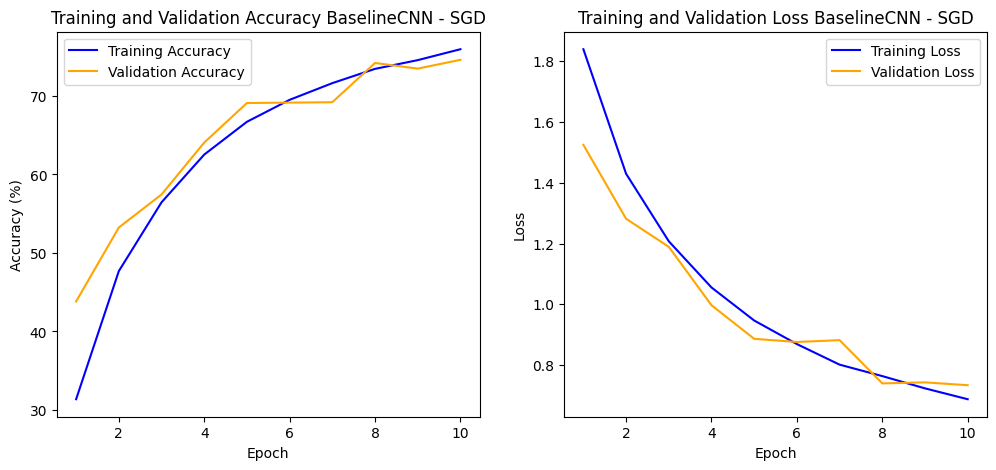


Training BaselineCNN with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 62.98it/s]


Epoch [1/10], Training Loss: 0.6667, Training Accuracy: 76.80%, Validation Accuracy: 76.16%


100%|██████████| 157/157 [00:02<00:00, 67.86it/s]


Epoch [2/10], Training Loss: 0.6398, Training Accuracy: 77.72%, Validation Accuracy: 76.52%


100%|██████████| 157/157 [00:02<00:00, 64.23it/s]


Epoch [3/10], Training Loss: 0.6139, Training Accuracy: 78.55%, Validation Accuracy: 76.88%


100%|██████████| 157/157 [00:02<00:00, 67.60it/s]


Epoch [4/10], Training Loss: 0.5933, Training Accuracy: 79.38%, Validation Accuracy: 76.66%


100%|██████████| 157/157 [00:02<00:00, 64.55it/s]


Epoch [5/10], Training Loss: 0.5726, Training Accuracy: 80.10%, Validation Accuracy: 77.01%


100%|██████████| 157/157 [00:02<00:00, 64.59it/s]


Epoch [6/10], Training Loss: 0.5551, Training Accuracy: 80.64%, Validation Accuracy: 77.74%


100%|██████████| 157/157 [00:02<00:00, 65.01it/s]


Epoch [7/10], Training Loss: 0.5368, Training Accuracy: 80.99%, Validation Accuracy: 78.35%


100%|██████████| 157/157 [00:02<00:00, 65.99it/s]


Epoch [8/10], Training Loss: 0.5174, Training Accuracy: 81.66%, Validation Accuracy: 78.50%


100%|██████████| 157/157 [00:02<00:00, 65.67it/s]


Epoch [9/10], Training Loss: 0.5183, Training Accuracy: 81.90%, Validation Accuracy: 79.14%


100%|██████████| 157/157 [00:02<00:00, 67.89it/s]


Epoch [10/10], Training Loss: 0.5022, Training Accuracy: 82.39%, Validation Accuracy: 78.44%


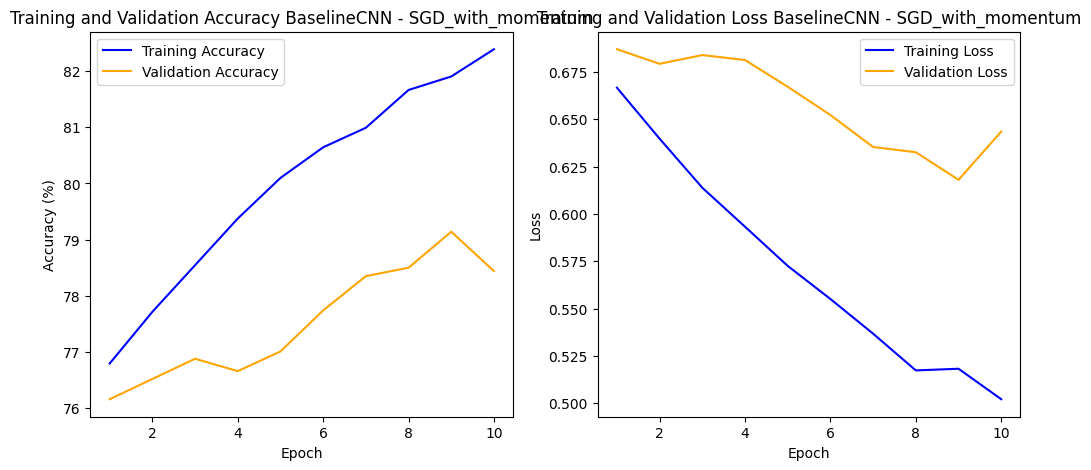


Training BaselineCNN with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 60.33it/s]


Epoch [1/10], Training Loss: 0.4875, Training Accuracy: 82.91%, Validation Accuracy: 78.88%


100%|██████████| 157/157 [00:02<00:00, 62.81it/s]


Epoch [2/10], Training Loss: 0.4778, Training Accuracy: 83.32%, Validation Accuracy: 78.62%


100%|██████████| 157/157 [00:02<00:00, 63.95it/s]


Epoch [3/10], Training Loss: 0.4652, Training Accuracy: 83.75%, Validation Accuracy: 78.49%


100%|██████████| 157/157 [00:02<00:00, 68.03it/s]


Epoch [4/10], Training Loss: 0.4641, Training Accuracy: 83.75%, Validation Accuracy: 79.57%


100%|██████████| 157/157 [00:02<00:00, 66.51it/s]


Epoch [5/10], Training Loss: 0.4489, Training Accuracy: 84.29%, Validation Accuracy: 79.25%


100%|██████████| 157/157 [00:02<00:00, 66.65it/s]


Epoch [6/10], Training Loss: 0.4391, Training Accuracy: 84.64%, Validation Accuracy: 79.85%


100%|██████████| 157/157 [00:02<00:00, 65.91it/s]


Epoch [7/10], Training Loss: 0.4334, Training Accuracy: 84.65%, Validation Accuracy: 80.40%


100%|██████████| 157/157 [00:02<00:00, 66.00it/s]


Epoch [8/10], Training Loss: 0.4234, Training Accuracy: 85.15%, Validation Accuracy: 79.58%


100%|██████████| 157/157 [00:02<00:00, 67.19it/s]


Epoch [9/10], Training Loss: 0.4141, Training Accuracy: 85.37%, Validation Accuracy: 79.13%


100%|██████████| 157/157 [00:02<00:00, 65.92it/s]


Epoch [10/10], Training Loss: 0.4073, Training Accuracy: 85.58%, Validation Accuracy: 80.92%


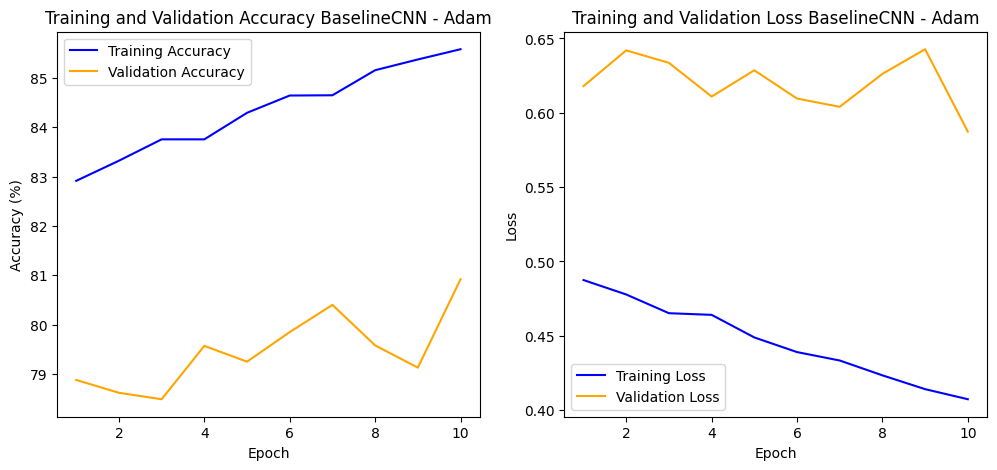


Starting training for ResNet18 with learning rate 0.01...

Training ResNet18 with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 67.21it/s]


Epoch [1/10], Training Loss: 1.8135, Training Accuracy: 36.06%, Validation Accuracy: 43.26%


100%|██████████| 157/157 [00:02<00:00, 67.67it/s]


Epoch [2/10], Training Loss: 1.4450, Training Accuracy: 48.68%, Validation Accuracy: 55.07%


100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


Epoch [3/10], Training Loss: 1.2492, Training Accuracy: 55.53%, Validation Accuracy: 58.13%


100%|██████████| 157/157 [00:02<00:00, 69.15it/s]


Epoch [4/10], Training Loss: 1.1175, Training Accuracy: 60.64%, Validation Accuracy: 61.91%


100%|██████████| 157/157 [00:02<00:00, 64.63it/s]


Epoch [5/10], Training Loss: 1.0157, Training Accuracy: 63.93%, Validation Accuracy: 64.27%


100%|██████████| 157/157 [00:02<00:00, 66.31it/s]


Epoch [6/10], Training Loss: 0.9551, Training Accuracy: 66.36%, Validation Accuracy: 65.39%


100%|██████████| 157/157 [00:02<00:00, 67.31it/s]


Epoch [7/10], Training Loss: 0.8997, Training Accuracy: 68.47%, Validation Accuracy: 66.41%


100%|██████████| 157/157 [00:02<00:00, 65.40it/s]


Epoch [8/10], Training Loss: 0.8507, Training Accuracy: 70.17%, Validation Accuracy: 68.47%


100%|██████████| 157/157 [00:02<00:00, 66.34it/s]


Epoch [9/10], Training Loss: 0.8110, Training Accuracy: 71.60%, Validation Accuracy: 68.84%


100%|██████████| 157/157 [00:02<00:00, 66.17it/s]


Epoch [10/10], Training Loss: 0.7692, Training Accuracy: 73.06%, Validation Accuracy: 71.04%


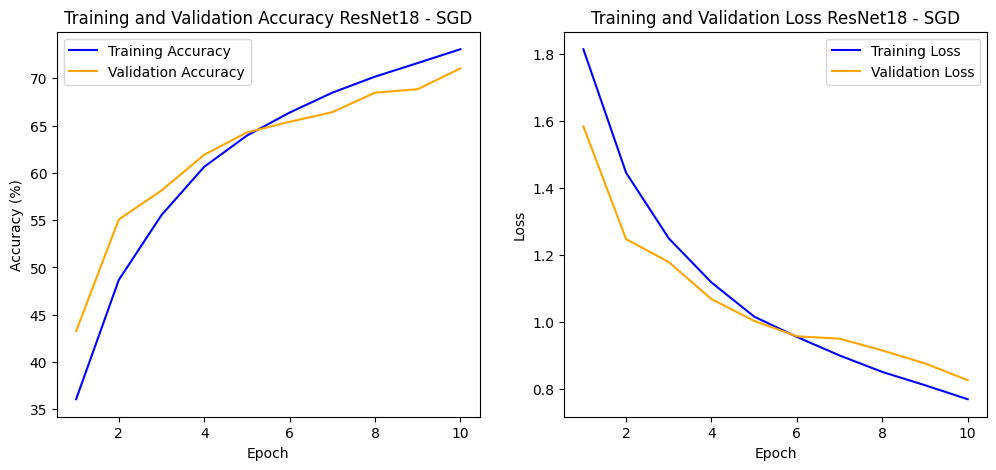


Training ResNet18 with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 66.71it/s]


Epoch [1/10], Training Loss: 0.7428, Training Accuracy: 74.06%, Validation Accuracy: 72.08%


100%|██████████| 157/157 [00:02<00:00, 68.38it/s]


Epoch [2/10], Training Loss: 0.7187, Training Accuracy: 75.01%, Validation Accuracy: 72.79%


100%|██████████| 157/157 [00:02<00:00, 68.93it/s]


Epoch [3/10], Training Loss: 0.6917, Training Accuracy: 75.69%, Validation Accuracy: 74.59%


100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Epoch [4/10], Training Loss: 0.6644, Training Accuracy: 76.88%, Validation Accuracy: 74.66%


100%|██████████| 157/157 [00:02<00:00, 67.50it/s]


Epoch [5/10], Training Loss: 0.6378, Training Accuracy: 77.63%, Validation Accuracy: 74.54%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [6/10], Training Loss: 0.6240, Training Accuracy: 78.23%, Validation Accuracy: 75.84%


100%|██████████| 157/157 [00:02<00:00, 66.52it/s]


Epoch [7/10], Training Loss: 0.6078, Training Accuracy: 78.67%, Validation Accuracy: 75.78%


100%|██████████| 157/157 [00:02<00:00, 69.16it/s]


Epoch [8/10], Training Loss: 0.5931, Training Accuracy: 79.27%, Validation Accuracy: 76.79%


100%|██████████| 157/157 [00:02<00:00, 65.15it/s]


Epoch [9/10], Training Loss: 0.5763, Training Accuracy: 79.88%, Validation Accuracy: 76.64%


100%|██████████| 157/157 [00:02<00:00, 66.84it/s]


Epoch [10/10], Training Loss: 0.5550, Training Accuracy: 80.60%, Validation Accuracy: 76.61%


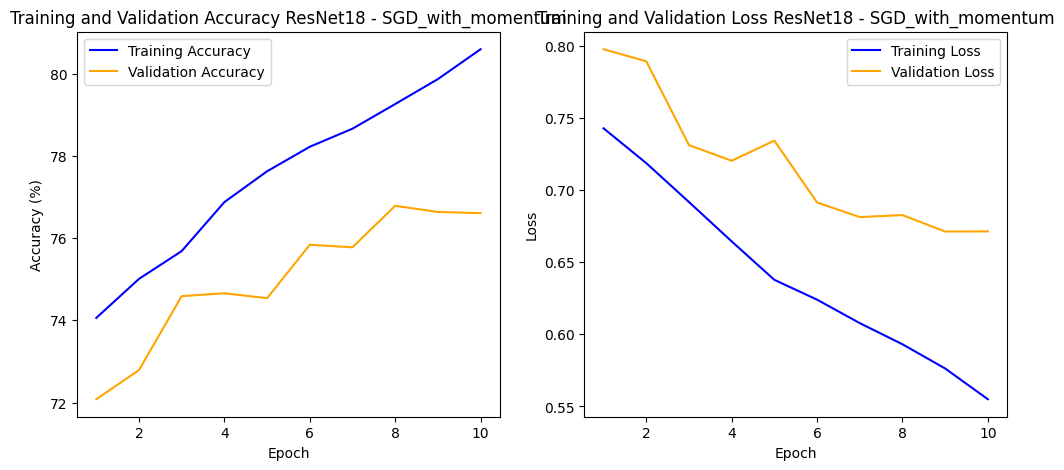


Training ResNet18 with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 68.39it/s]


Epoch [1/10], Training Loss: 0.5378, Training Accuracy: 81.19%, Validation Accuracy: 76.31%


100%|██████████| 157/157 [00:02<00:00, 64.62it/s]


Epoch [2/10], Training Loss: 0.5333, Training Accuracy: 81.38%, Validation Accuracy: 77.45%


100%|██████████| 157/157 [00:02<00:00, 66.93it/s]


Epoch [3/10], Training Loss: 0.5184, Training Accuracy: 81.82%, Validation Accuracy: 77.09%


100%|██████████| 157/157 [00:02<00:00, 68.00it/s]


Epoch [4/10], Training Loss: 0.5057, Training Accuracy: 82.25%, Validation Accuracy: 77.82%


100%|██████████| 157/157 [00:02<00:00, 67.46it/s]


Epoch [5/10], Training Loss: 0.4955, Training Accuracy: 82.56%, Validation Accuracy: 78.26%


100%|██████████| 157/157 [00:02<00:00, 62.59it/s]


Epoch [6/10], Training Loss: 0.4760, Training Accuracy: 83.25%, Validation Accuracy: 77.69%


100%|██████████| 157/157 [00:02<00:00, 66.81it/s]


Epoch [7/10], Training Loss: 0.4715, Training Accuracy: 83.52%, Validation Accuracy: 78.20%


100%|██████████| 157/157 [00:02<00:00, 62.75it/s]


Epoch [8/10], Training Loss: 0.4581, Training Accuracy: 83.97%, Validation Accuracy: 78.03%


100%|██████████| 157/157 [00:02<00:00, 61.11it/s]


Epoch [9/10], Training Loss: 0.4485, Training Accuracy: 84.06%, Validation Accuracy: 77.33%


100%|██████████| 157/157 [00:02<00:00, 65.41it/s]


Epoch [10/10], Training Loss: 0.4403, Training Accuracy: 84.39%, Validation Accuracy: 79.21%


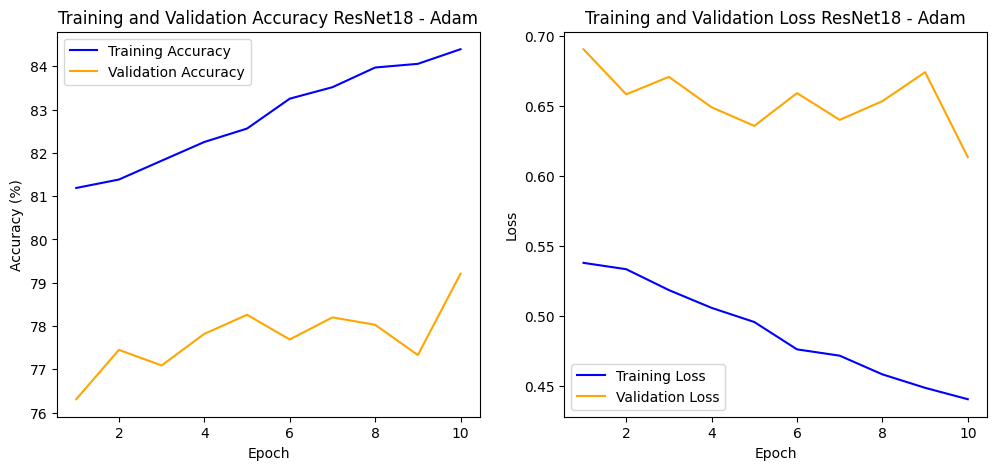


Starting training for ResNet34 with learning rate 0.001...

Training ResNet34 with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 68.47it/s]


Epoch [1/10], Training Loss: 1.9769, Training Accuracy: 30.89%, Validation Accuracy: 39.82%


100%|██████████| 157/157 [00:02<00:00, 66.51it/s]


Epoch [2/10], Training Loss: 1.5837, Training Accuracy: 41.77%, Validation Accuracy: 44.39%


100%|██████████| 157/157 [00:02<00:00, 64.87it/s]


Epoch [3/10], Training Loss: 1.4634, Training Accuracy: 46.47%, Validation Accuracy: 49.25%


100%|██████████| 157/157 [00:02<00:00, 67.25it/s]


Epoch [4/10], Training Loss: 1.3828, Training Accuracy: 49.62%, Validation Accuracy: 51.07%


100%|██████████| 157/157 [00:02<00:00, 67.29it/s]


Epoch [5/10], Training Loss: 1.3137, Training Accuracy: 52.20%, Validation Accuracy: 54.14%


100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Epoch [6/10], Training Loss: 1.2538, Training Accuracy: 54.60%, Validation Accuracy: 55.67%


100%|██████████| 157/157 [00:02<00:00, 68.05it/s]


Epoch [7/10], Training Loss: 1.2003, Training Accuracy: 56.92%, Validation Accuracy: 58.26%


100%|██████████| 157/157 [00:02<00:00, 66.77it/s]


Epoch [8/10], Training Loss: 1.1445, Training Accuracy: 59.10%, Validation Accuracy: 58.36%


100%|██████████| 157/157 [00:02<00:00, 67.07it/s]


Epoch [9/10], Training Loss: 1.1013, Training Accuracy: 60.42%, Validation Accuracy: 59.91%


100%|██████████| 157/157 [00:02<00:00, 67.27it/s]


Epoch [10/10], Training Loss: 1.0632, Training Accuracy: 62.04%, Validation Accuracy: 61.01%


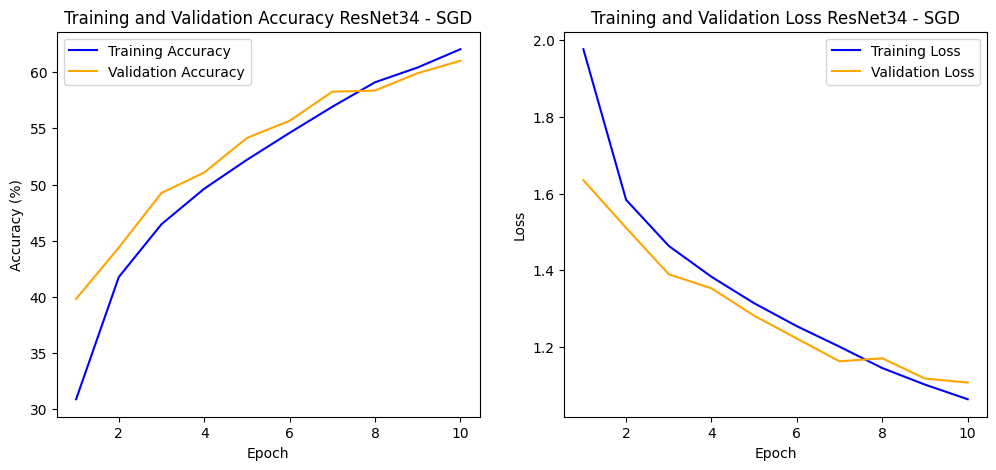


Training ResNet34 with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 61.93it/s]


Epoch [1/10], Training Loss: 1.0196, Training Accuracy: 63.41%, Validation Accuracy: 63.38%


100%|██████████| 157/157 [00:02<00:00, 66.40it/s]


Epoch [2/10], Training Loss: 0.9942, Training Accuracy: 64.65%, Validation Accuracy: 63.70%


100%|██████████| 157/157 [00:02<00:00, 66.73it/s]


Epoch [3/10], Training Loss: 0.9580, Training Accuracy: 65.72%, Validation Accuracy: 64.61%


100%|██████████| 157/157 [00:02<00:00, 64.66it/s]


Epoch [4/10], Training Loss: 0.9341, Training Accuracy: 66.68%, Validation Accuracy: 65.75%


100%|██████████| 157/157 [00:02<00:00, 69.25it/s]


Epoch [5/10], Training Loss: 0.9041, Training Accuracy: 67.77%, Validation Accuracy: 67.48%


100%|██████████| 157/157 [00:02<00:00, 68.46it/s]


Epoch [6/10], Training Loss: 0.8879, Training Accuracy: 68.40%, Validation Accuracy: 67.13%


100%|██████████| 157/157 [00:02<00:00, 68.41it/s]


Epoch [7/10], Training Loss: 0.8584, Training Accuracy: 69.45%, Validation Accuracy: 66.56%


100%|██████████| 157/157 [00:02<00:00, 69.14it/s]


Epoch [8/10], Training Loss: 0.8418, Training Accuracy: 70.12%, Validation Accuracy: 68.51%


100%|██████████| 157/157 [00:02<00:00, 66.62it/s]


Epoch [9/10], Training Loss: 0.8226, Training Accuracy: 70.78%, Validation Accuracy: 68.38%


100%|██████████| 157/157 [00:02<00:00, 65.43it/s]


Epoch [10/10], Training Loss: 0.8044, Training Accuracy: 71.44%, Validation Accuracy: 69.17%


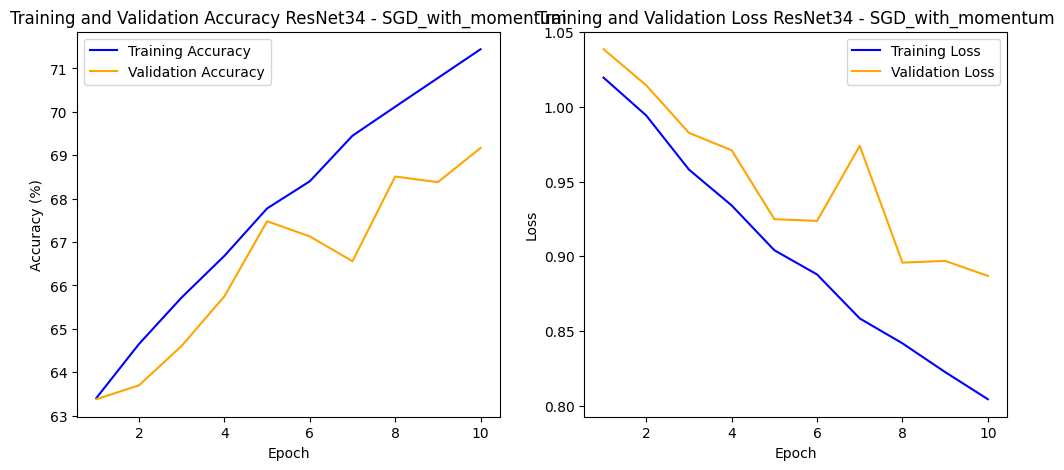


Training ResNet34 with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 67.30it/s]


Epoch [1/10], Training Loss: 0.7875, Training Accuracy: 71.98%, Validation Accuracy: 68.22%


100%|██████████| 157/157 [00:02<00:00, 65.29it/s]


Epoch [2/10], Training Loss: 0.7668, Training Accuracy: 72.77%, Validation Accuracy: 70.33%


100%|██████████| 157/157 [00:02<00:00, 63.99it/s]


Epoch [3/10], Training Loss: 0.7507, Training Accuracy: 73.35%, Validation Accuracy: 68.16%


100%|██████████| 157/157 [00:02<00:00, 63.62it/s]


Epoch [4/10], Training Loss: 0.7366, Training Accuracy: 73.97%, Validation Accuracy: 68.94%


100%|██████████| 157/157 [00:02<00:00, 66.15it/s]


Epoch [5/10], Training Loss: 0.7225, Training Accuracy: 74.28%, Validation Accuracy: 70.84%


100%|██████████| 157/157 [00:02<00:00, 66.99it/s]


Epoch [6/10], Training Loss: 0.7072, Training Accuracy: 74.72%, Validation Accuracy: 71.38%


100%|██████████| 157/157 [00:02<00:00, 67.61it/s]


Epoch [7/10], Training Loss: 0.6947, Training Accuracy: 75.38%, Validation Accuracy: 70.36%


100%|██████████| 157/157 [00:02<00:00, 64.45it/s]


Epoch [8/10], Training Loss: 0.6927, Training Accuracy: 75.34%, Validation Accuracy: 72.45%


100%|██████████| 157/157 [00:02<00:00, 66.35it/s]


Epoch [9/10], Training Loss: 0.6707, Training Accuracy: 75.91%, Validation Accuracy: 72.28%


100%|██████████| 157/157 [00:02<00:00, 67.76it/s]


Epoch [10/10], Training Loss: 0.6597, Training Accuracy: 76.51%, Validation Accuracy: 71.56%


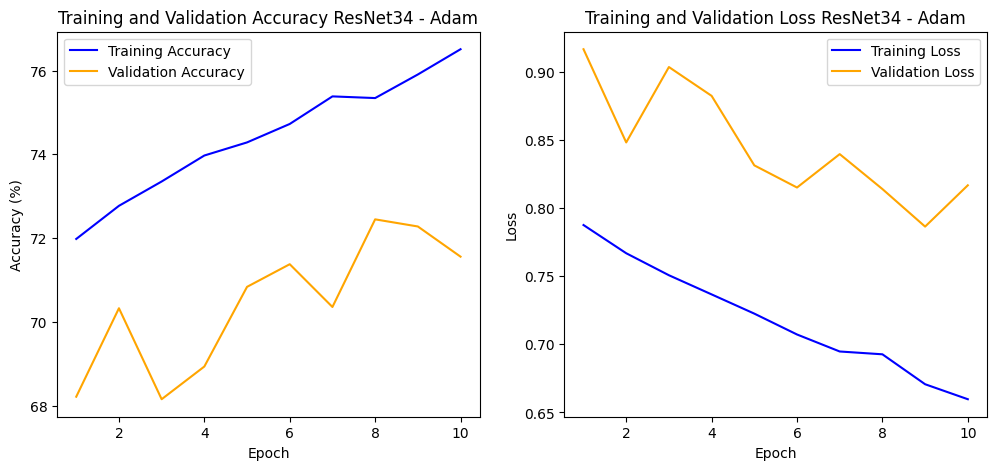


Starting training for ResNet50 with learning rate 0.001...

Training ResNet50 with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 65.72it/s]


Epoch [1/10], Training Loss: 2.2812, Training Accuracy: 21.18%, Validation Accuracy: 29.18%


100%|██████████| 157/157 [00:02<00:00, 65.78it/s]


Epoch [2/10], Training Loss: 1.9545, Training Accuracy: 30.40%, Validation Accuracy: 33.77%


100%|██████████| 157/157 [00:02<00:00, 67.04it/s]


Epoch [3/10], Training Loss: 1.8108, Training Accuracy: 34.91%, Validation Accuracy: 38.05%


100%|██████████| 157/157 [00:02<00:00, 69.02it/s]


Epoch [4/10], Training Loss: 1.7156, Training Accuracy: 38.12%, Validation Accuracy: 41.89%


100%|██████████| 157/157 [00:02<00:00, 66.30it/s]


Epoch [5/10], Training Loss: 1.6505, Training Accuracy: 40.49%, Validation Accuracy: 42.61%


100%|██████████| 157/157 [00:02<00:00, 67.96it/s]


Epoch [6/10], Training Loss: 1.5744, Training Accuracy: 42.91%, Validation Accuracy: 42.25%


100%|██████████| 157/157 [00:02<00:00, 66.88it/s]


Epoch [7/10], Training Loss: 1.5307, Training Accuracy: 44.68%, Validation Accuracy: 46.65%


100%|██████████| 157/157 [00:02<00:00, 65.48it/s]


Epoch [8/10], Training Loss: 1.4854, Training Accuracy: 46.25%, Validation Accuracy: 47.78%


100%|██████████| 157/157 [00:02<00:00, 67.99it/s]


Epoch [9/10], Training Loss: 1.4479, Training Accuracy: 47.70%, Validation Accuracy: 49.05%


100%|██████████| 157/157 [00:02<00:00, 67.90it/s]


Epoch [10/10], Training Loss: 1.4057, Training Accuracy: 48.99%, Validation Accuracy: 49.35%


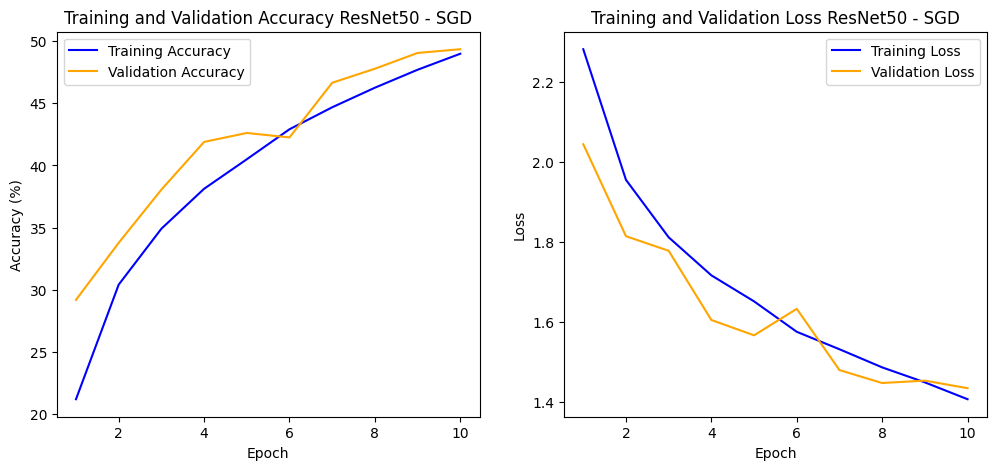


Training ResNet50 with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 66.41it/s]


Epoch [1/10], Training Loss: 1.3754, Training Accuracy: 50.59%, Validation Accuracy: 50.93%


100%|██████████| 157/157 [00:02<00:00, 66.12it/s]


Epoch [2/10], Training Loss: 1.3526, Training Accuracy: 51.61%, Validation Accuracy: 49.66%


100%|██████████| 157/157 [00:02<00:00, 66.34it/s]


Epoch [3/10], Training Loss: 1.3212, Training Accuracy: 52.52%, Validation Accuracy: 51.20%


100%|██████████| 157/157 [00:02<00:00, 66.97it/s]


Epoch [4/10], Training Loss: 1.2885, Training Accuracy: 53.80%, Validation Accuracy: 53.10%


100%|██████████| 157/157 [00:02<00:00, 66.00it/s]


Epoch [5/10], Training Loss: 1.2772, Training Accuracy: 54.55%, Validation Accuracy: 52.84%


100%|██████████| 157/157 [00:02<00:00, 66.59it/s]


Epoch [6/10], Training Loss: 1.2462, Training Accuracy: 55.45%, Validation Accuracy: 54.11%


100%|██████████| 157/157 [00:02<00:00, 64.91it/s]


Epoch [7/10], Training Loss: 1.2160, Training Accuracy: 56.56%, Validation Accuracy: 55.30%


100%|██████████| 157/157 [00:02<00:00, 65.39it/s]


Epoch [8/10], Training Loss: 1.1956, Training Accuracy: 57.20%, Validation Accuracy: 56.62%


100%|██████████| 157/157 [00:02<00:00, 65.61it/s]


Epoch [9/10], Training Loss: 1.1737, Training Accuracy: 58.22%, Validation Accuracy: 56.13%


100%|██████████| 157/157 [00:02<00:00, 65.54it/s]


Epoch [10/10], Training Loss: 1.1517, Training Accuracy: 59.09%, Validation Accuracy: 57.46%


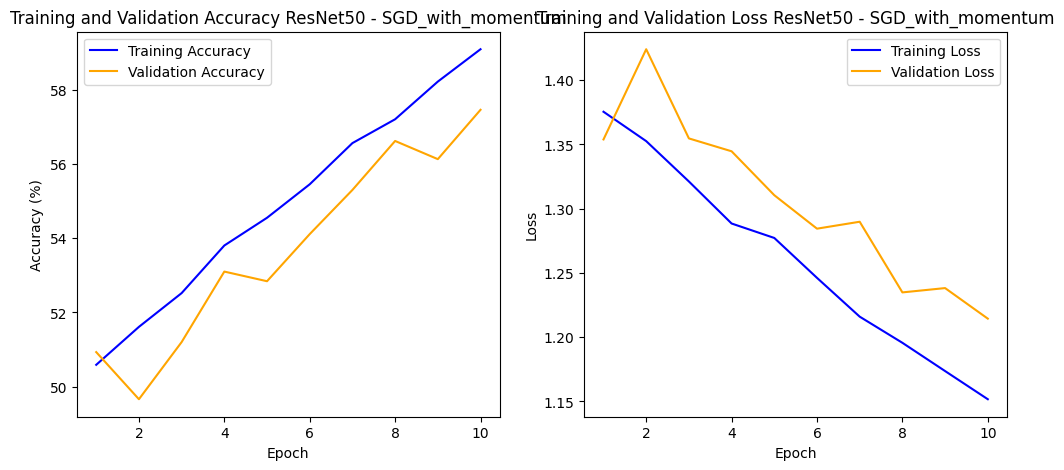


Training ResNet50 with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 67.03it/s]


Epoch [1/10], Training Loss: 1.1393, Training Accuracy: 59.59%, Validation Accuracy: 57.85%


100%|██████████| 157/157 [00:02<00:00, 67.21it/s]


Epoch [2/10], Training Loss: 1.1220, Training Accuracy: 59.84%, Validation Accuracy: 59.73%


100%|██████████| 157/157 [00:02<00:00, 65.16it/s]


Epoch [3/10], Training Loss: 1.0957, Training Accuracy: 61.03%, Validation Accuracy: 59.33%


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch [4/10], Training Loss: 1.0759, Training Accuracy: 61.61%, Validation Accuracy: 59.90%


100%|██████████| 157/157 [00:02<00:00, 62.28it/s]


Epoch [5/10], Training Loss: 1.0648, Training Accuracy: 62.30%, Validation Accuracy: 59.59%


100%|██████████| 157/157 [00:02<00:00, 63.91it/s]


Epoch [6/10], Training Loss: 1.0360, Training Accuracy: 63.32%, Validation Accuracy: 60.47%


100%|██████████| 157/157 [00:02<00:00, 66.74it/s]


Epoch [7/10], Training Loss: 1.0172, Training Accuracy: 63.80%, Validation Accuracy: 61.34%


100%|██████████| 157/157 [00:02<00:00, 67.94it/s]


Epoch [8/10], Training Loss: 1.0003, Training Accuracy: 64.16%, Validation Accuracy: 61.66%


100%|██████████| 157/157 [00:02<00:00, 67.19it/s]


Epoch [9/10], Training Loss: 0.9836, Training Accuracy: 65.19%, Validation Accuracy: 62.86%


100%|██████████| 157/157 [00:02<00:00, 65.89it/s]


Epoch [10/10], Training Loss: 0.9716, Training Accuracy: 65.61%, Validation Accuracy: 61.92%


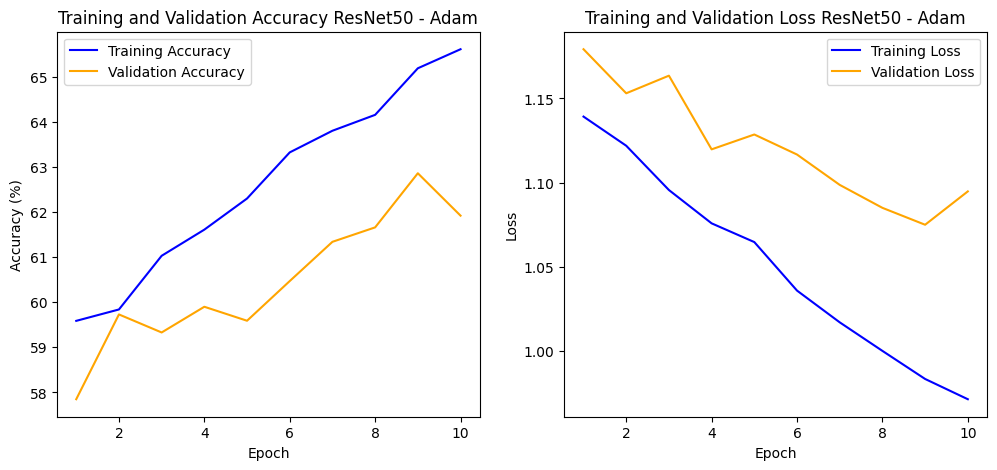


Starting training for VGG16 with learning rate 0.01...

Training VGG16 with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 65.42it/s]


Epoch [1/10], Training Loss: 2.4181, Training Accuracy: 16.77%, Validation Accuracy: 26.32%


100%|██████████| 157/157 [00:02<00:00, 66.58it/s]


Epoch [2/10], Training Loss: 1.7827, Training Accuracy: 31.94%, Validation Accuracy: 38.40%


100%|██████████| 157/157 [00:02<00:00, 64.94it/s]


Epoch [3/10], Training Loss: 1.5456, Training Accuracy: 42.72%, Validation Accuracy: 48.01%


100%|██████████| 157/157 [00:02<00:00, 66.03it/s]


Epoch [4/10], Training Loss: 1.3446, Training Accuracy: 51.33%, Validation Accuracy: 53.97%


100%|██████████| 157/157 [00:02<00:00, 68.68it/s]


Epoch [5/10], Training Loss: 1.1439, Training Accuracy: 59.59%, Validation Accuracy: 64.33%


100%|██████████| 157/157 [00:02<00:00, 66.02it/s]


Epoch [6/10], Training Loss: 1.0095, Training Accuracy: 64.98%, Validation Accuracy: 69.11%


100%|██████████| 157/157 [00:02<00:00, 66.09it/s]


Epoch [7/10], Training Loss: 0.9081, Training Accuracy: 68.74%, Validation Accuracy: 69.35%


100%|██████████| 157/157 [00:02<00:00, 67.16it/s]


Epoch [8/10], Training Loss: 0.8228, Training Accuracy: 72.05%, Validation Accuracy: 73.64%


100%|██████████| 157/157 [00:02<00:00, 62.41it/s]


Epoch [9/10], Training Loss: 0.7559, Training Accuracy: 74.47%, Validation Accuracy: 72.30%


100%|██████████| 157/157 [00:02<00:00, 66.55it/s]


Epoch [10/10], Training Loss: 0.6951, Training Accuracy: 76.80%, Validation Accuracy: 77.28%


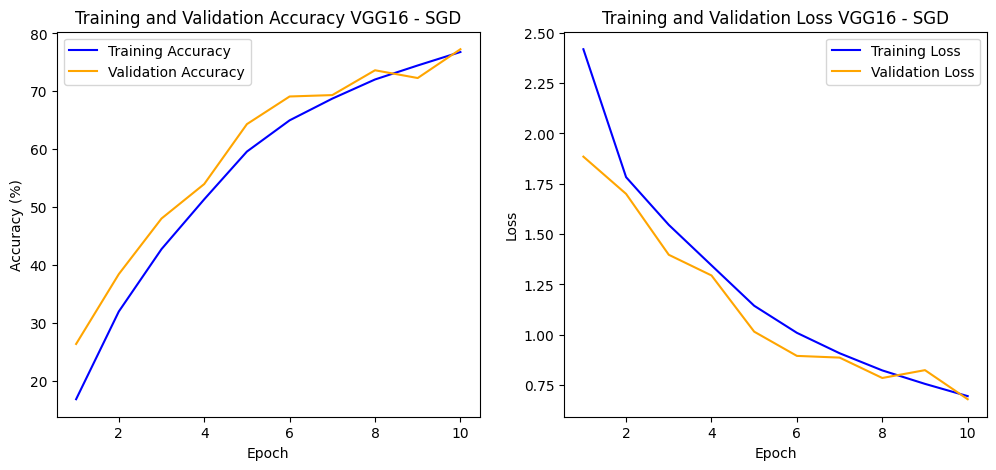


Training VGG16 with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 64.75it/s]


Epoch [1/10], Training Loss: 0.6463, Training Accuracy: 78.44%, Validation Accuracy: 75.74%


100%|██████████| 157/157 [00:02<00:00, 66.41it/s]


Epoch [2/10], Training Loss: 0.6156, Training Accuracy: 79.36%, Validation Accuracy: 78.36%


100%|██████████| 157/157 [00:02<00:00, 64.85it/s]


Epoch [3/10], Training Loss: 0.5775, Training Accuracy: 80.88%, Validation Accuracy: 79.69%


100%|██████████| 157/157 [00:02<00:00, 65.64it/s]


Epoch [4/10], Training Loss: 0.5400, Training Accuracy: 82.09%, Validation Accuracy: 79.36%


100%|██████████| 157/157 [00:02<00:00, 64.86it/s]


Epoch [5/10], Training Loss: 0.5178, Training Accuracy: 82.88%, Validation Accuracy: 80.04%


100%|██████████| 157/157 [00:02<00:00, 66.42it/s]


Epoch [6/10], Training Loss: 0.4906, Training Accuracy: 83.63%, Validation Accuracy: 81.39%


100%|██████████| 157/157 [00:02<00:00, 66.41it/s]


Epoch [7/10], Training Loss: 0.4665, Training Accuracy: 84.54%, Validation Accuracy: 80.99%


100%|██████████| 157/157 [00:02<00:00, 66.67it/s]


Epoch [8/10], Training Loss: 0.4470, Training Accuracy: 85.18%, Validation Accuracy: 82.33%


100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


Epoch [9/10], Training Loss: 0.4196, Training Accuracy: 86.08%, Validation Accuracy: 82.12%


100%|██████████| 157/157 [00:02<00:00, 65.26it/s]


Epoch [10/10], Training Loss: 0.4064, Training Accuracy: 86.61%, Validation Accuracy: 83.62%


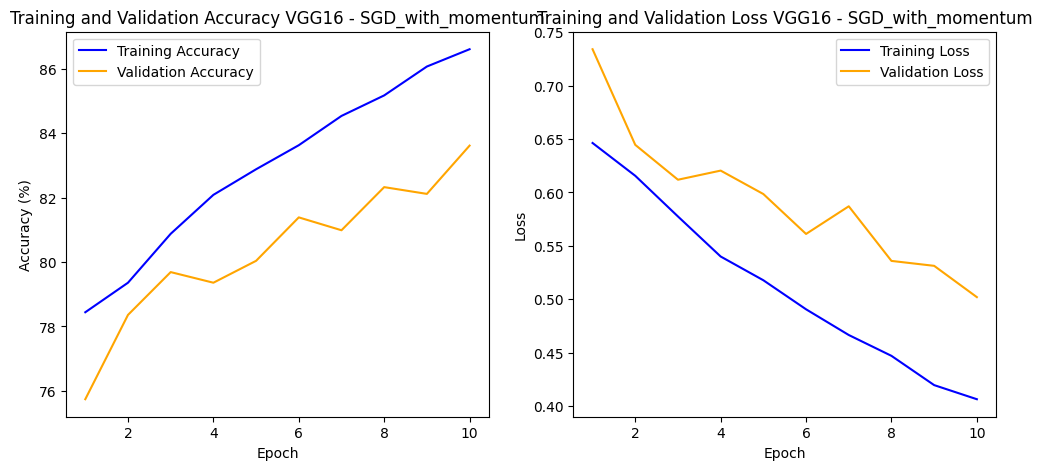


Training VGG16 with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 62.44it/s]


Epoch [1/10], Training Loss: 0.3878, Training Accuracy: 87.16%, Validation Accuracy: 83.42%


100%|██████████| 157/157 [00:02<00:00, 66.36it/s]


Epoch [2/10], Training Loss: 0.3699, Training Accuracy: 87.54%, Validation Accuracy: 83.53%


100%|██████████| 157/157 [00:02<00:00, 65.65it/s]


Epoch [3/10], Training Loss: 0.3642, Training Accuracy: 87.78%, Validation Accuracy: 83.21%


100%|██████████| 157/157 [00:02<00:00, 61.69it/s]


Epoch [4/10], Training Loss: 0.3466, Training Accuracy: 88.51%, Validation Accuracy: 83.01%


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]


Epoch [5/10], Training Loss: 0.3336, Training Accuracy: 88.83%, Validation Accuracy: 84.98%


100%|██████████| 157/157 [00:02<00:00, 62.22it/s]


Epoch [6/10], Training Loss: 0.3192, Training Accuracy: 89.35%, Validation Accuracy: 84.76%


100%|██████████| 157/157 [00:02<00:00, 65.67it/s]


Epoch [7/10], Training Loss: 0.3130, Training Accuracy: 89.53%, Validation Accuracy: 82.98%


100%|██████████| 157/157 [00:02<00:00, 64.72it/s]


Epoch [8/10], Training Loss: 0.3012, Training Accuracy: 90.04%, Validation Accuracy: 84.76%


100%|██████████| 157/157 [00:02<00:00, 65.98it/s]


Epoch [9/10], Training Loss: 0.2889, Training Accuracy: 90.31%, Validation Accuracy: 84.94%


100%|██████████| 157/157 [00:02<00:00, 65.15it/s]


Epoch [10/10], Training Loss: 0.2748, Training Accuracy: 90.83%, Validation Accuracy: 85.35%


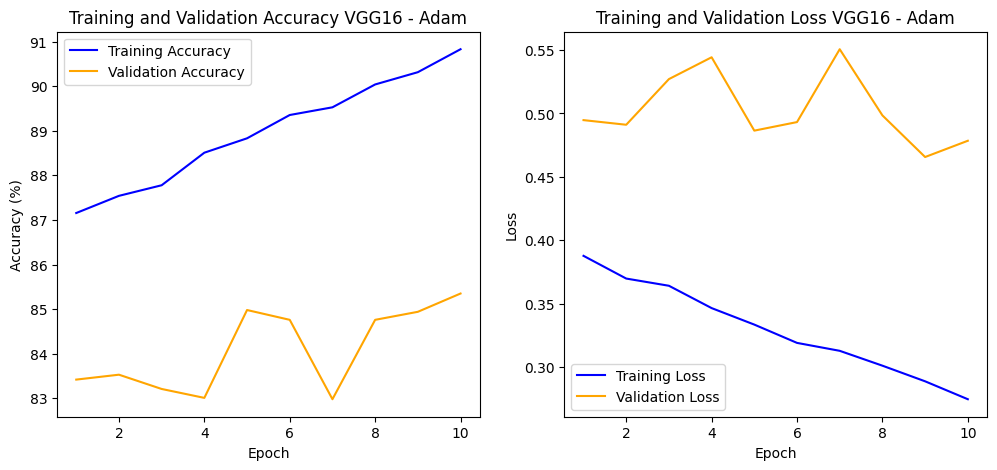


Starting training for VGG19 with learning rate 0.01...

Training VGG19 with SGD optimizer...


100%|██████████| 157/157 [00:02<00:00, 59.14it/s]


Epoch [1/10], Training Loss: 2.8629, Training Accuracy: 9.76%, Validation Accuracy: 10.06%


100%|██████████| 157/157 [00:02<00:00, 68.02it/s]


Epoch [2/10], Training Loss: 2.3385, Training Accuracy: 10.09%, Validation Accuracy: 10.17%


100%|██████████| 157/157 [00:02<00:00, 68.90it/s]


Epoch [3/10], Training Loss: 2.3080, Training Accuracy: 11.18%, Validation Accuracy: 16.86%


100%|██████████| 157/157 [00:02<00:00, 61.53it/s]


Epoch [4/10], Training Loss: 1.9821, Training Accuracy: 19.98%, Validation Accuracy: 21.84%


100%|██████████| 157/157 [00:02<00:00, 67.00it/s]


Epoch [5/10], Training Loss: 1.8709, Training Accuracy: 24.25%, Validation Accuracy: 27.47%


100%|██████████| 157/157 [00:02<00:00, 68.00it/s]


Epoch [6/10], Training Loss: 1.7157, Training Accuracy: 32.34%, Validation Accuracy: 34.45%


100%|██████████| 157/157 [00:02<00:00, 67.58it/s]


Epoch [7/10], Training Loss: 1.5469, Training Accuracy: 41.92%, Validation Accuracy: 45.34%


100%|██████████| 157/157 [00:02<00:00, 68.08it/s]


Epoch [8/10], Training Loss: 1.3354, Training Accuracy: 51.06%, Validation Accuracy: 58.27%


100%|██████████| 157/157 [00:02<00:00, 67.41it/s]


Epoch [9/10], Training Loss: 1.1580, Training Accuracy: 58.77%, Validation Accuracy: 60.63%


100%|██████████| 157/157 [00:02<00:00, 64.78it/s]


Epoch [10/10], Training Loss: 1.0305, Training Accuracy: 64.12%, Validation Accuracy: 66.07%


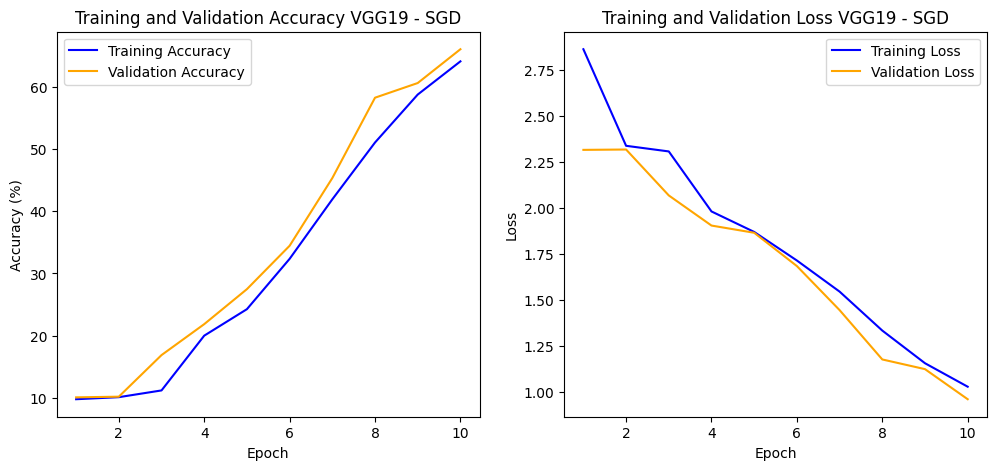


Training VGG19 with SGD_with_momentum optimizer...


100%|██████████| 157/157 [00:02<00:00, 66.14it/s]


Epoch [1/10], Training Loss: 0.9326, Training Accuracy: 68.56%, Validation Accuracy: 71.65%


100%|██████████| 157/157 [00:02<00:00, 67.61it/s]


Epoch [2/10], Training Loss: 0.8546, Training Accuracy: 71.42%, Validation Accuracy: 72.64%


100%|██████████| 157/157 [00:02<00:00, 68.90it/s]


Epoch [3/10], Training Loss: 0.7853, Training Accuracy: 73.90%, Validation Accuracy: 71.65%


100%|██████████| 157/157 [00:02<00:00, 67.67it/s]


Epoch [4/10], Training Loss: 0.7247, Training Accuracy: 76.19%, Validation Accuracy: 75.03%


100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


Epoch [5/10], Training Loss: 0.6924, Training Accuracy: 77.42%, Validation Accuracy: 76.71%


100%|██████████| 157/157 [00:02<00:00, 63.43it/s]


Epoch [6/10], Training Loss: 0.6444, Training Accuracy: 78.93%, Validation Accuracy: 76.93%


100%|██████████| 157/157 [00:02<00:00, 67.05it/s]


Epoch [7/10], Training Loss: 0.5999, Training Accuracy: 80.40%, Validation Accuracy: 79.43%


100%|██████████| 157/157 [00:02<00:00, 65.08it/s]


Epoch [8/10], Training Loss: 0.5639, Training Accuracy: 81.67%, Validation Accuracy: 80.58%


100%|██████████| 157/157 [00:02<00:00, 64.97it/s]


Epoch [9/10], Training Loss: 0.5420, Training Accuracy: 82.29%, Validation Accuracy: 79.17%


100%|██████████| 157/157 [00:02<00:00, 65.53it/s]


Epoch [10/10], Training Loss: 0.5304, Training Accuracy: 82.55%, Validation Accuracy: 78.68%


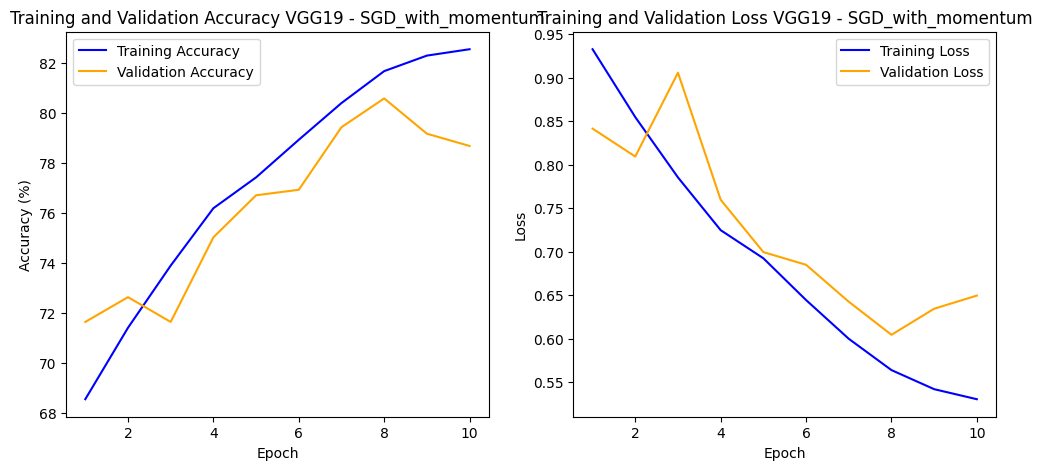


Training VGG19 with Adam optimizer...


100%|██████████| 157/157 [00:02<00:00, 64.48it/s]


Epoch [1/10], Training Loss: 0.4894, Training Accuracy: 84.10%, Validation Accuracy: 81.25%


100%|██████████| 157/157 [00:02<00:00, 66.55it/s]


Epoch [2/10], Training Loss: 0.4681, Training Accuracy: 84.83%, Validation Accuracy: 82.71%


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Epoch [3/10], Training Loss: 0.4377, Training Accuracy: 85.85%, Validation Accuracy: 81.62%


100%|██████████| 157/157 [00:02<00:00, 67.30it/s]


Epoch [4/10], Training Loss: 0.4236, Training Accuracy: 86.18%, Validation Accuracy: 82.05%


100%|██████████| 157/157 [00:02<00:00, 68.05it/s]


Epoch [5/10], Training Loss: 0.4128, Training Accuracy: 86.56%, Validation Accuracy: 82.21%


100%|██████████| 157/157 [00:02<00:00, 60.73it/s]


Epoch [6/10], Training Loss: 0.3950, Training Accuracy: 87.23%, Validation Accuracy: 83.73%


100%|██████████| 157/157 [00:02<00:00, 65.14it/s]


Epoch [7/10], Training Loss: 0.3677, Training Accuracy: 88.06%, Validation Accuracy: 83.99%


100%|██████████| 157/157 [00:02<00:00, 62.56it/s]


Epoch [8/10], Training Loss: 0.3546, Training Accuracy: 88.45%, Validation Accuracy: 85.06%


100%|██████████| 157/157 [00:02<00:00, 67.35it/s]


Epoch [9/10], Training Loss: 0.3497, Training Accuracy: 88.56%, Validation Accuracy: 84.39%


100%|██████████| 157/157 [00:02<00:00, 68.36it/s]


Epoch [10/10], Training Loss: 0.3343, Training Accuracy: 89.24%, Validation Accuracy: 84.44%


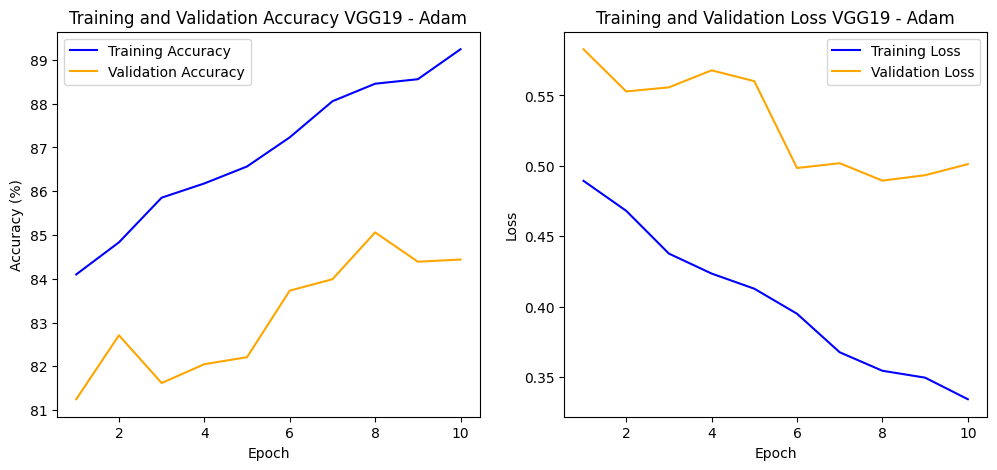

In [ ]:
# Loop over models
for model_name, (model, learning_rate) in models_and_learning_rates.items():
    print(f"\nStarting training for {model_name} with learning rate {learning_rate}...")

    # Get optimizers for the current model and learning rate
    optimizers = get_optimizers(model, learning_rate)

    # Train the model with each optimizer
    for optimizer_name, optimizer in optimizers.items():
        print(f"\nTraining {model_name} with {optimizer_name} optimizer...")

        # Train and evaluate
        train_acc, val_acc, train_loss, val_loss = train_and_evaluate_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            num_epochs=10,
            learning_rate=learning_rate
        )

        # Plot results
        plot_metrics(train_acc, val_acc, train_loss, val_loss, f"{model_name} - {optimizer_name}")


In [ ]:
results = {"BaseLineCNN": {
        "SGD": {"val_acc": 74.60, "val_loss": 0.6876},
        "SGD_with_momentum": {"val_acc": 79.14, "val_loss": 0.5183},
        "Adam": {"val_acc": 80.92, "val_loss": 0.4073}
    },
    "ResNet18": {
        "SGD": {"val_acc": 72.68, "val_loss": 0.8},
        "SGD_with_momentum": {"val_acc": 76.69, "val_loss": 0.7},
        "Adam": {"val_acc": 78.20, "val_loss": 0.65}
    },
    "ResNet34": {
        "SGD": {"val_acc": 63.23, "val_loss": 1.0},
        "SGD_with_momentum": {"val_acc": 69.98, "val_loss": 1.0},
        "Adam": {"val_acc": 73.30, "val_loss": 0.850}
    },
    "ResNet50": {
        "SGD": {"val_acc": 52.07, "val_loss": 1.3768},
        "SGD_with_momentum": {"val_acc": 59.69, "val_loss": 1.1068},
        "Adam": {"val_acc": 65.02, "val_loss": 0.9144}
    },
    "VGG16": {
        "SGD": {"val_acc": 75.05, "val_loss": 0.7213},
        "SGD_with_momentum": {"val_acc": 82.51, "val_loss": 0.4163},
        "Adam": {"val_acc": 84.97, "val_loss": 0.2890}
    },
    "VGG19": {
        "SGD": {"val_acc": 70.69, "val_loss": 0.9042},
        "SGD_with_momentum": {"val_acc": 81.82, "val_loss": 0.4673},
        "Adam": {"val_acc": 85.12, "val_loss": 0.3144}
    }
}


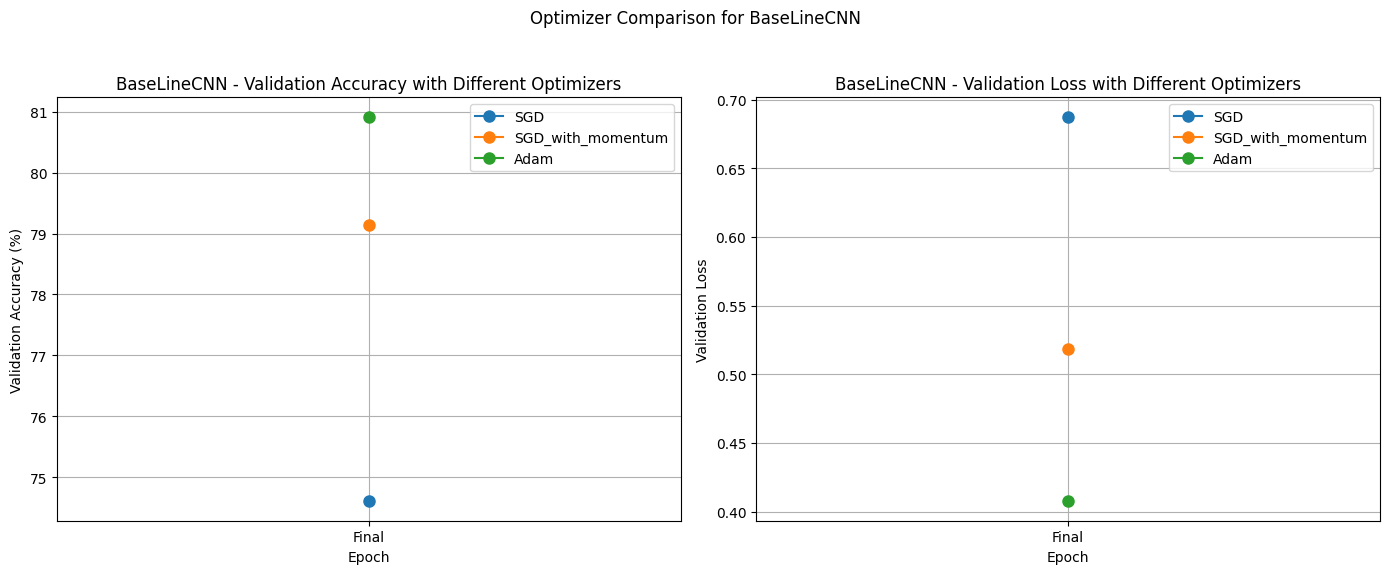

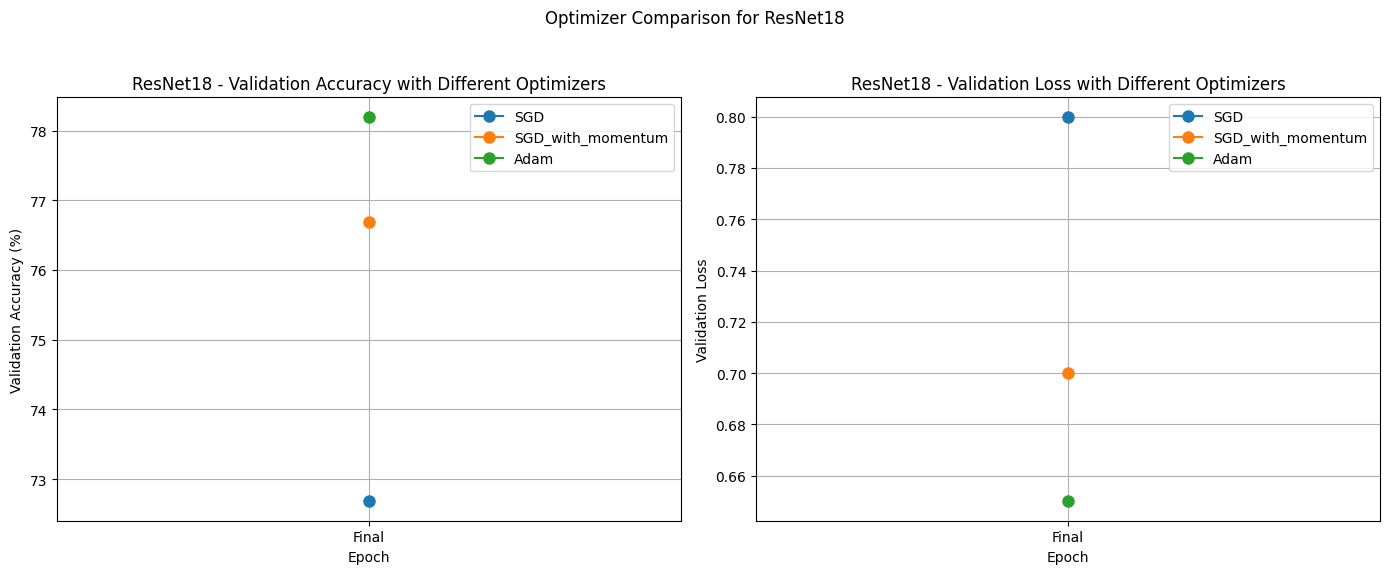

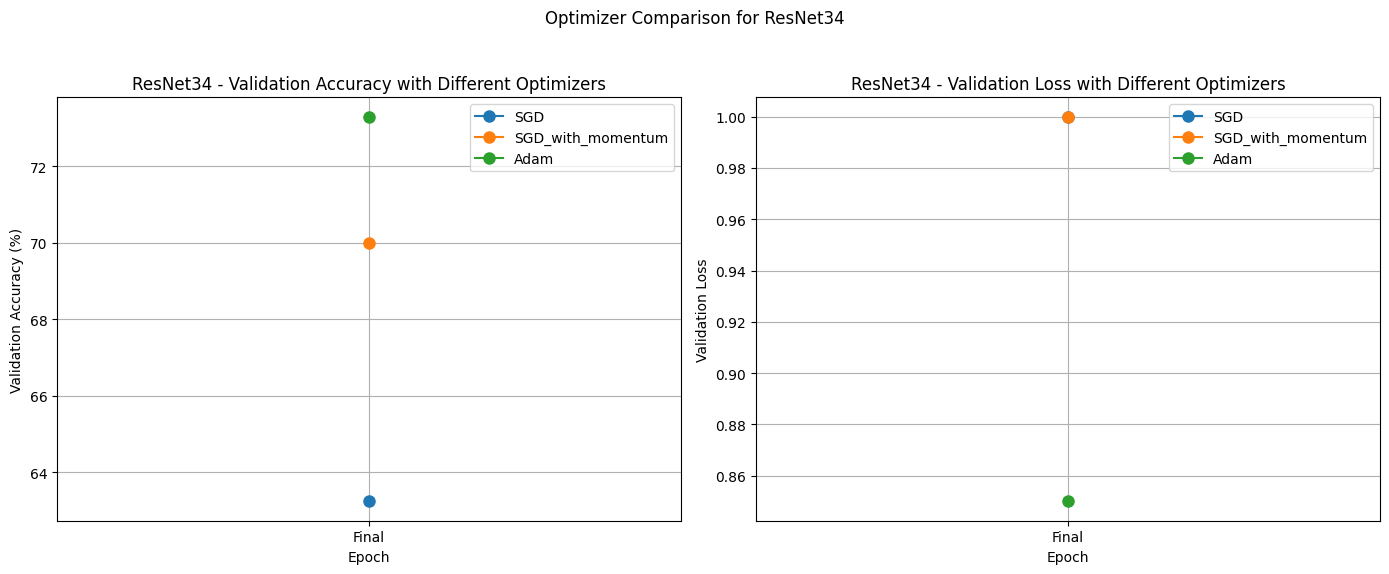

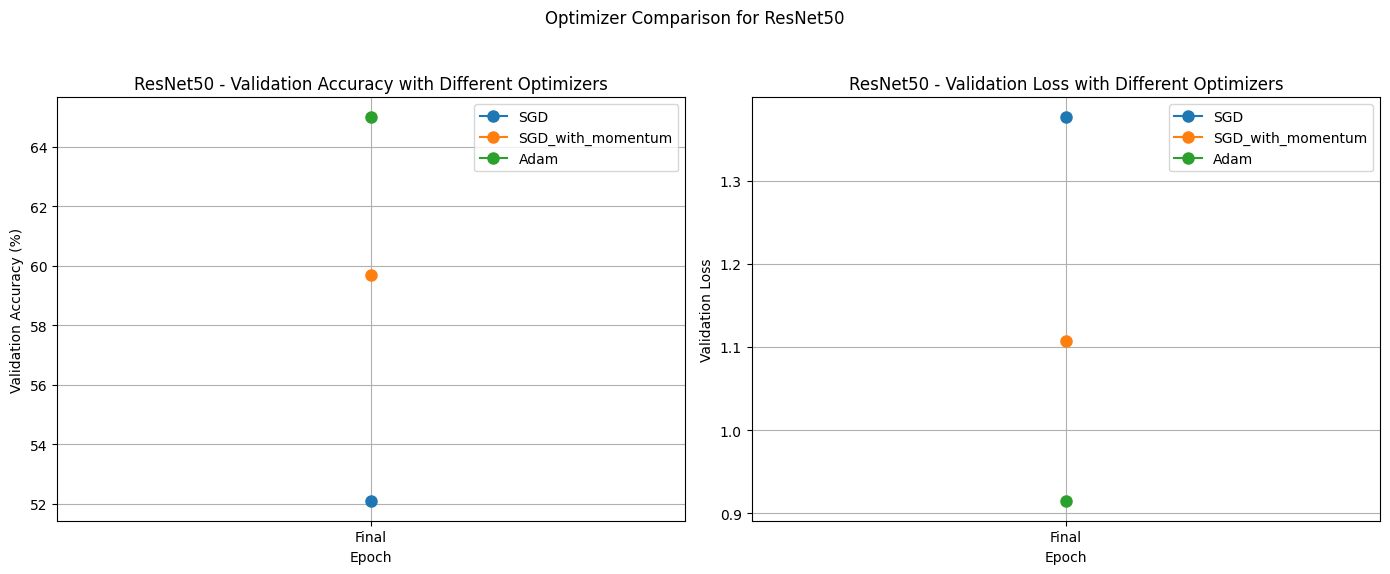

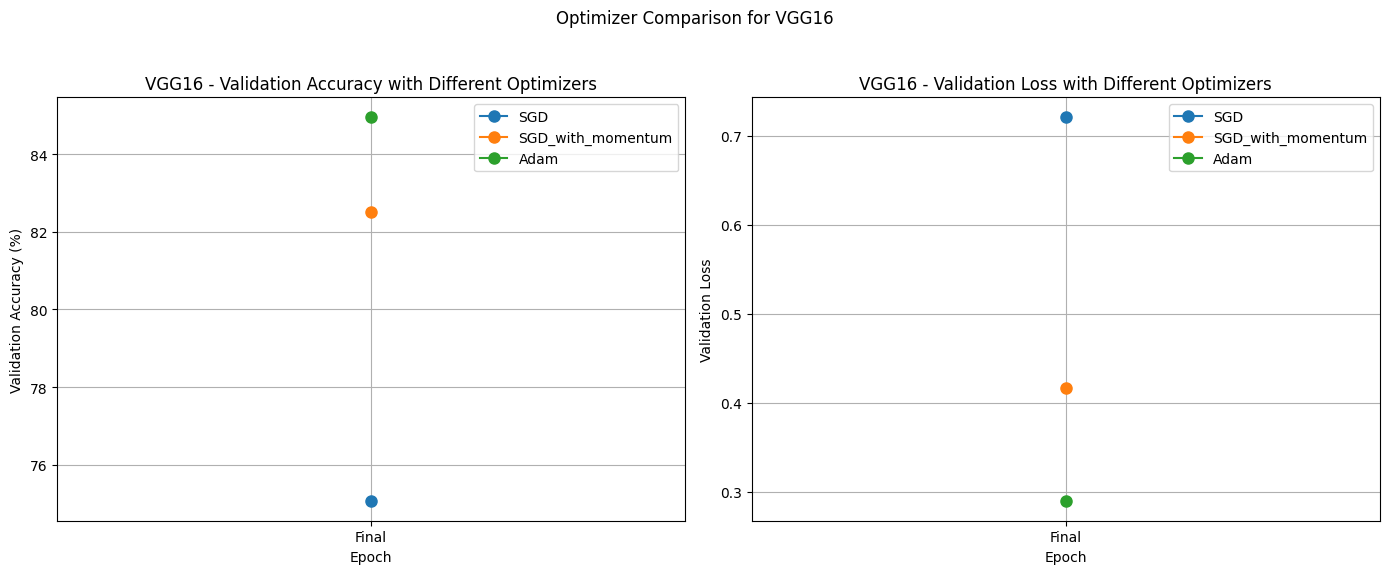

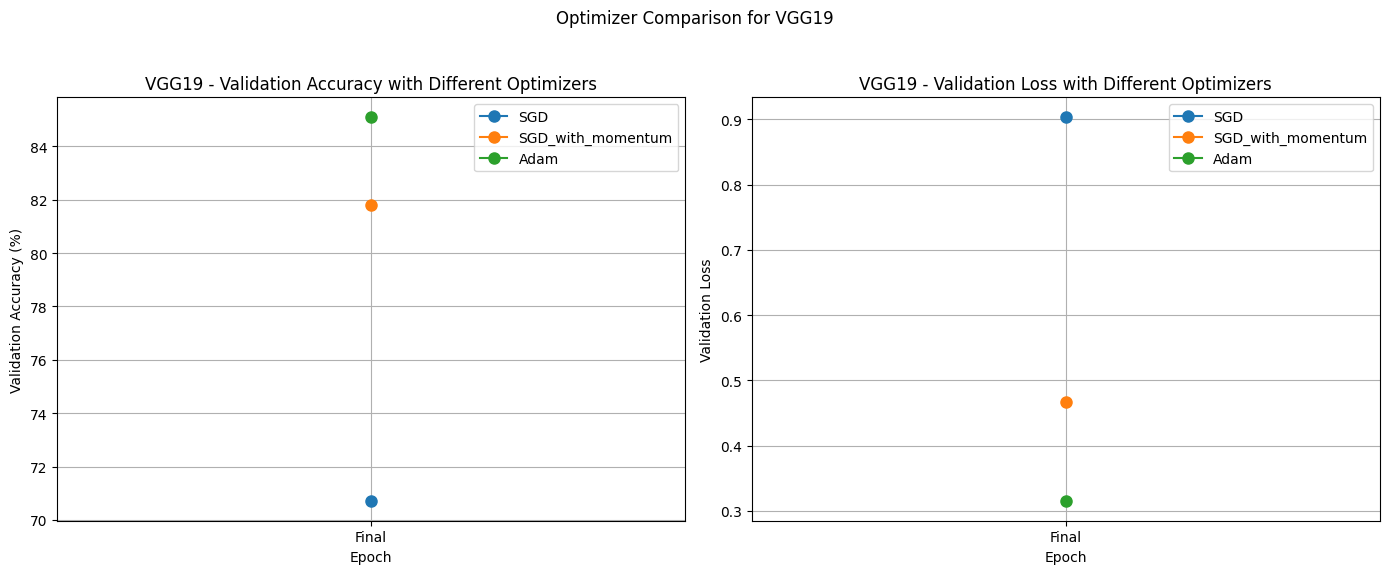

In [ ]:
def plot_optimizer_comparison_for_all(results):
    for model_name, optimizers in results.items():
        plt.figure(figsize=(14, 6))

        # Validation Accuracy Plot
        plt.subplot(1, 2, 1)
        for optimizer_name, metrics in optimizers.items():
            plt.plot(
                [1], [metrics["val_acc"]], label=optimizer_name, marker='o', markersize=8
            )
        plt.title(f"{model_name} - Validation Accuracy with Different Optimizers")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy (%)")
        plt.xticks([1], labels=["Final"])
        plt.legend()
        plt.grid(True)

        # Validation Loss Plot
        plt.subplot(1, 2, 2)
        for optimizer_name, metrics in optimizers.items():
            plt.plot(
                [1], [metrics["val_loss"]], label=optimizer_name, marker='o', markersize=8
            )
        plt.title(f"{model_name} - Validation Loss with Different Optimizers")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.xticks([1], labels=["Final"])
        plt.legend()
        plt.grid(True)

        plt.suptitle(f"Optimizer Comparison for {model_name}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_optimizer_comparison_for_all(results)


In [ ]:
#Displaying the results in a table
# Data for best optimizer results
best_results = {
    "Model": ["ResNet18", "ResNet34", "ResNet50", "VGG16", "VGG19"],
    "Best Optimizer": ["Adam", "Adam", "Adam", "Adam", "Adam"],
    "Validation Accuracy (%)": [78.20, 73.30, 65.02, 84.97, 85.12]
}


best_results_df = pd.DataFrame(best_results)
best_results_df


Model Best Optimizer  Validation Accuracy (%)
0  ResNet18           Adam                    78.20
1  ResNet34           Adam                    73.30
2  ResNet50           Adam                    65.02
3     VGG16           Adam                    84.97
4     VGG19           Adam                    85.12

# Hyperparameter tuning using grid search

In [ ]:
models_and_learning_rates = {
    "Baseline": (baseline_model, 0.01, optim.Adam),
    "ResNet18": (models.resnet18().to(device), 0.01, optim.Adam),
    "ResNet34": (models.resnet34().to(device), 0.001, optim.Adam),
    "ResNet50": (models.resnet50().to(device), 0.001, optim.Adam),
    "VGG16": (models.vgg16().to(device), 0.01, optim.Adam),
    "VGG19": (models.vgg19().to(device), 0.01, optim.Adam),
}


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna
# Define the Optuna objective function to fine-tune batch size and number of epochs
def objective(trial):

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("epochs", 5, 15, step=5)

    best_model_name = None
    best_val_acc = 0.0
    best_model_weights = None

    # Iterate through each model with its best learning rate and optimizer
    for model_name, (model, best_lr, optimizer_class) in models_and_learning_rates.items():
        print(f"\nTesting {model_name} with batch size {batch_size} and {num_epochs} epochs...")

        # Load the CIFAR-10 dataset with the suggested batch size
        train_loader, val_loader, _ = load_cifar10(batch_size=batch_size)

        # Initialize the optimizer with the best learning rate for each model
        optimizer = optimizer_class(model.parameters(), lr=best_lr)

        # Train and evaluate the model
        train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_and_evaluate_model(
            model, train_loader, val_loader, optimizer, num_epochs
        )
        final_val_acc = val_acc_list[-1]

        # Keep track of the best model based on validation accuracy
        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_model_name = model_name
            best_model_weights = model.state_dict()  # Save the best model's weights

    # Save the weights of the best model for this trial
    torch.save(best_model_weights, f"best_model_{best_model_name}_trial_{trial.number}.pt")

    trial.report(best_val_acc, step=num_epochs)
    return best_val_acc

# Start the Optuna study to find the optimal batch size and epochs
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)



[I 2024-11-09 06:47:13,811] A new study created in memory with name: no-name-c36901b7-65c5-45e8-9213-b9bc2f330763



Testing Baseline with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 68.89it/s]


Epoch [1/10], Training Loss: 0.4239, Training Accuracy: 86.12%, Validation Accuracy: 86.95%


100%|██████████| 157/157 [00:02<00:00, 68.52it/s]


Epoch [2/10], Training Loss: 0.4138, Training Accuracy: 86.42%, Validation Accuracy: 86.32%


100%|██████████| 157/157 [00:02<00:00, 66.32it/s]


Epoch [3/10], Training Loss: 0.4167, Training Accuracy: 86.48%, Validation Accuracy: 85.60%


100%|██████████| 157/157 [00:02<00:00, 68.92it/s]


Epoch [4/10], Training Loss: 0.4039, Training Accuracy: 86.77%, Validation Accuracy: 84.15%


100%|██████████| 157/157 [00:02<00:00, 67.96it/s]


Epoch [5/10], Training Loss: 0.4079, Training Accuracy: 86.45%, Validation Accuracy: 85.22%


100%|██████████| 157/157 [00:02<00:00, 64.79it/s]


Epoch [6/10], Training Loss: 0.3974, Training Accuracy: 86.83%, Validation Accuracy: 85.12%


100%|██████████| 157/157 [00:02<00:00, 62.34it/s]


Epoch [7/10], Training Loss: 0.3909, Training Accuracy: 87.01%, Validation Accuracy: 85.31%


100%|██████████| 157/157 [00:02<00:00, 67.90it/s]


Epoch [8/10], Training Loss: 0.3931, Training Accuracy: 86.99%, Validation Accuracy: 85.62%


100%|██████████| 157/157 [00:02<00:00, 68.39it/s]


Epoch [9/10], Training Loss: 0.3856, Training Accuracy: 87.07%, Validation Accuracy: 85.33%


100%|██████████| 157/157 [00:02<00:00, 68.23it/s]


Epoch [10/10], Training Loss: 0.3879, Training Accuracy: 87.18%, Validation Accuracy: 83.89%

Testing ResNet18 with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 69.03it/s]


Epoch [1/10], Training Loss: 0.2262, Training Accuracy: 93.34%, Validation Accuracy: 94.56%


100%|██████████| 157/157 [00:02<00:00, 67.03it/s]


Epoch [2/10], Training Loss: 0.1875, Training Accuracy: 94.20%, Validation Accuracy: 94.49%


100%|██████████| 157/157 [00:02<00:00, 65.98it/s]


Epoch [3/10], Training Loss: 0.1767, Training Accuracy: 94.31%, Validation Accuracy: 94.42%


100%|██████████| 157/157 [00:02<00:00, 60.69it/s]


Epoch [4/10], Training Loss: 0.1690, Training Accuracy: 94.51%, Validation Accuracy: 93.75%


100%|██████████| 157/157 [00:02<00:00, 64.15it/s]


Epoch [5/10], Training Loss: 0.1502, Training Accuracy: 94.96%, Validation Accuracy: 94.16%


100%|██████████| 157/157 [00:02<00:00, 67.06it/s]


Epoch [6/10], Training Loss: 0.1442, Training Accuracy: 95.17%, Validation Accuracy: 93.55%


100%|██████████| 157/157 [00:02<00:00, 66.90it/s]


Epoch [7/10], Training Loss: 0.1435, Training Accuracy: 95.30%, Validation Accuracy: 94.10%


100%|██████████| 157/157 [00:02<00:00, 68.16it/s]


Epoch [8/10], Training Loss: 0.1350, Training Accuracy: 95.47%, Validation Accuracy: 93.98%


100%|██████████| 157/157 [00:02<00:00, 60.83it/s]


Epoch [9/10], Training Loss: 0.1303, Training Accuracy: 95.67%, Validation Accuracy: 93.74%


100%|██████████| 157/157 [00:02<00:00, 66.87it/s]


Epoch [10/10], Training Loss: 0.1287, Training Accuracy: 95.55%, Validation Accuracy: 93.13%

Testing ResNet34 with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 66.56it/s]


Epoch [1/10], Training Loss: 0.2183, Training Accuracy: 93.33%, Validation Accuracy: 93.96%


100%|██████████| 157/157 [00:02<00:00, 66.83it/s]


Epoch [2/10], Training Loss: 0.1884, Training Accuracy: 93.97%, Validation Accuracy: 93.32%


100%|██████████| 157/157 [00:02<00:00, 65.06it/s]


Epoch [3/10], Training Loss: 0.1799, Training Accuracy: 94.23%, Validation Accuracy: 93.68%


100%|██████████| 157/157 [00:02<00:00, 65.20it/s]


Epoch [4/10], Training Loss: 0.1687, Training Accuracy: 94.44%, Validation Accuracy: 93.48%


100%|██████████| 157/157 [00:02<00:00, 66.06it/s]


Epoch [5/10], Training Loss: 0.1620, Training Accuracy: 94.64%, Validation Accuracy: 93.44%


100%|██████████| 157/157 [00:02<00:00, 66.47it/s]


Epoch [6/10], Training Loss: 0.1574, Training Accuracy: 94.84%, Validation Accuracy: 93.49%


100%|██████████| 157/157 [00:02<00:00, 66.62it/s]


Epoch [7/10], Training Loss: 0.1502, Training Accuracy: 95.04%, Validation Accuracy: 93.11%


100%|██████████| 157/157 [00:02<00:00, 68.23it/s]


Epoch [8/10], Training Loss: 0.1508, Training Accuracy: 94.92%, Validation Accuracy: 92.88%


100%|██████████| 157/157 [00:02<00:00, 64.15it/s]


Epoch [9/10], Training Loss: 0.1391, Training Accuracy: 95.26%, Validation Accuracy: 92.37%


100%|██████████| 157/157 [00:02<00:00, 67.44it/s]


Epoch [10/10], Training Loss: 0.1478, Training Accuracy: 94.98%, Validation Accuracy: 92.20%

Testing ResNet50 with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 66.58it/s]


Epoch [1/10], Training Loss: 0.3248, Training Accuracy: 89.97%, Validation Accuracy: 92.39%


100%|██████████| 157/157 [00:02<00:00, 66.34it/s]


Epoch [2/10], Training Loss: 0.2516, Training Accuracy: 91.98%, Validation Accuracy: 92.01%


100%|██████████| 157/157 [00:02<00:00, 66.04it/s]


Epoch [3/10], Training Loss: 0.2222, Training Accuracy: 92.70%, Validation Accuracy: 91.88%


100%|██████████| 157/157 [00:02<00:00, 67.25it/s]


Epoch [4/10], Training Loss: 0.2094, Training Accuracy: 93.24%, Validation Accuracy: 92.14%


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Epoch [5/10], Training Loss: 0.1921, Training Accuracy: 93.64%, Validation Accuracy: 90.74%


100%|██████████| 157/157 [00:02<00:00, 66.03it/s]


Epoch [6/10], Training Loss: 0.1797, Training Accuracy: 93.88%, Validation Accuracy: 90.56%


100%|██████████| 157/157 [00:02<00:00, 65.06it/s]


Epoch [7/10], Training Loss: 0.1691, Training Accuracy: 94.40%, Validation Accuracy: 91.06%


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Epoch [8/10], Training Loss: 0.1641, Training Accuracy: 94.42%, Validation Accuracy: 91.05%


100%|██████████| 157/157 [00:02<00:00, 66.12it/s]


Epoch [9/10], Training Loss: 0.1552, Training Accuracy: 94.70%, Validation Accuracy: 91.44%


100%|██████████| 157/157 [00:02<00:00, 65.14it/s]


Epoch [10/10], Training Loss: 0.1560, Training Accuracy: 94.66%, Validation Accuracy: 90.83%

Testing VGG16 with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 66.64it/s]


Epoch [1/10], Training Loss: 0.1916, Training Accuracy: 94.85%, Validation Accuracy: 95.16%


100%|██████████| 157/157 [00:02<00:00, 67.23it/s]


Epoch [2/10], Training Loss: 0.1660, Training Accuracy: 95.60%, Validation Accuracy: 95.07%


100%|██████████| 157/157 [00:02<00:00, 66.81it/s]


Epoch [3/10], Training Loss: 0.1599, Training Accuracy: 95.67%, Validation Accuracy: 95.31%


100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


Epoch [4/10], Training Loss: 0.1409, Training Accuracy: 96.08%, Validation Accuracy: 94.95%


100%|██████████| 157/157 [00:02<00:00, 64.71it/s]


Epoch [5/10], Training Loss: 0.1511, Training Accuracy: 95.77%, Validation Accuracy: 94.82%


100%|██████████| 157/157 [00:02<00:00, 67.19it/s]


Epoch [6/10], Training Loss: 0.1320, Training Accuracy: 96.25%, Validation Accuracy: 95.65%


100%|██████████| 157/157 [00:02<00:00, 62.06it/s]


Epoch [7/10], Training Loss: 0.1265, Training Accuracy: 96.34%, Validation Accuracy: 94.88%


100%|██████████| 157/157 [00:02<00:00, 63.64it/s]


Epoch [8/10], Training Loss: 0.1295, Training Accuracy: 96.33%, Validation Accuracy: 95.13%


100%|██████████| 157/157 [00:02<00:00, 63.24it/s]


Epoch [9/10], Training Loss: 0.1223, Training Accuracy: 96.50%, Validation Accuracy: 94.50%


100%|██████████| 157/157 [00:02<00:00, 60.36it/s]


Epoch [10/10], Training Loss: 0.1289, Training Accuracy: 96.34%, Validation Accuracy: 94.52%

Testing VGG19 with batch size 64 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 157/157 [00:02<00:00, 66.02it/s]


Epoch [1/10], Training Loss: 0.1405, Training Accuracy: 96.38%, Validation Accuracy: 96.54%


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch [2/10], Training Loss: 0.1202, Training Accuracy: 96.88%, Validation Accuracy: 96.73%


100%|██████████| 157/157 [00:02<00:00, 66.14it/s]


Epoch [3/10], Training Loss: 0.1062, Training Accuracy: 97.12%, Validation Accuracy: 96.15%


100%|██████████| 157/157 [00:02<00:00, 66.39it/s]


Epoch [4/10], Training Loss: 0.0990, Training Accuracy: 97.37%, Validation Accuracy: 96.78%


100%|██████████| 157/157 [00:02<00:00, 69.16it/s]


Epoch [5/10], Training Loss: 0.0859, Training Accuracy: 97.62%, Validation Accuracy: 96.53%


100%|██████████| 157/157 [00:02<00:00, 69.41it/s]


Epoch [6/10], Training Loss: 0.0814, Training Accuracy: 97.78%, Validation Accuracy: 96.18%


100%|██████████| 157/157 [00:02<00:00, 66.51it/s]


Epoch [7/10], Training Loss: 0.0746, Training Accuracy: 97.91%, Validation Accuracy: 95.95%


100%|██████████| 157/157 [00:02<00:00, 68.62it/s]


Epoch [8/10], Training Loss: 0.0728, Training Accuracy: 97.91%, Validation Accuracy: 96.67%


100%|██████████| 157/157 [00:02<00:00, 64.82it/s]


Epoch [9/10], Training Loss: 0.0671, Training Accuracy: 98.03%, Validation Accuracy: 96.66%


100%|██████████| 157/157 [00:02<00:00, 68.95it/s]


Epoch [10/10], Training Loss: 0.0681, Training Accuracy: 97.98%, Validation Accuracy: 96.35%


[I 2024-11-09 07:01:39,914] Trial 0 finished with value: 96.35000000000001 and parameters: {'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 96.35000000000001.



Testing Baseline with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 35.69it/s]


Epoch [1/5], Training Loss: 0.3462, Training Accuracy: 88.28%, Validation Accuracy: 89.19%


100%|██████████| 79/79 [00:02<00:00, 35.78it/s]


Epoch [2/5], Training Loss: 0.3277, Training Accuracy: 89.08%, Validation Accuracy: 88.82%


100%|██████████| 79/79 [00:02<00:00, 34.62it/s]


Epoch [3/5], Training Loss: 0.3176, Training Accuracy: 89.38%, Validation Accuracy: 88.93%


100%|██████████| 79/79 [00:02<00:00, 35.05it/s]


Epoch [4/5], Training Loss: 0.3112, Training Accuracy: 89.46%, Validation Accuracy: 88.78%


100%|██████████| 79/79 [00:02<00:00, 34.05it/s]


Epoch [5/5], Training Loss: 0.3102, Training Accuracy: 89.45%, Validation Accuracy: 88.80%

Testing ResNet18 with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 34.91it/s]


Epoch [1/5], Training Loss: 0.1135, Training Accuracy: 96.48%, Validation Accuracy: 96.89%


100%|██████████| 79/79 [00:02<00:00, 34.32it/s]


Epoch [2/5], Training Loss: 0.0971, Training Accuracy: 96.92%, Validation Accuracy: 97.15%


100%|██████████| 79/79 [00:02<00:00, 34.07it/s]


Epoch [3/5], Training Loss: 0.0880, Training Accuracy: 97.23%, Validation Accuracy: 96.88%


100%|██████████| 79/79 [00:02<00:00, 35.87it/s]


Epoch [4/5], Training Loss: 0.0854, Training Accuracy: 97.17%, Validation Accuracy: 96.77%


100%|██████████| 79/79 [00:02<00:00, 33.39it/s]


Epoch [5/5], Training Loss: 0.0755, Training Accuracy: 97.55%, Validation Accuracy: 96.59%

Testing ResNet34 with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 32.31it/s]


Epoch [1/5], Training Loss: 0.1275, Training Accuracy: 95.95%, Validation Accuracy: 96.20%


100%|██████████| 79/79 [00:02<00:00, 34.18it/s]


Epoch [2/5], Training Loss: 0.1139, Training Accuracy: 96.33%, Validation Accuracy: 96.38%


100%|██████████| 79/79 [00:02<00:00, 32.35it/s]


Epoch [3/5], Training Loss: 0.1028, Training Accuracy: 96.71%, Validation Accuracy: 96.20%


100%|██████████| 79/79 [00:02<00:00, 34.94it/s]


Epoch [4/5], Training Loss: 0.0982, Training Accuracy: 96.81%, Validation Accuracy: 96.38%


100%|██████████| 79/79 [00:02<00:00, 35.26it/s]


Epoch [5/5], Training Loss: 0.0944, Training Accuracy: 96.81%, Validation Accuracy: 96.21%

Testing ResNet50 with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 34.97it/s]


Epoch [1/5], Training Loss: 0.1348, Training Accuracy: 95.70%, Validation Accuracy: 96.87%


100%|██████████| 79/79 [00:02<00:00, 35.24it/s]


Epoch [2/5], Training Loss: 0.1120, Training Accuracy: 96.41%, Validation Accuracy: 96.26%


100%|██████████| 79/79 [00:02<00:00, 35.39it/s]


Epoch [3/5], Training Loss: 0.0968, Training Accuracy: 96.84%, Validation Accuracy: 96.37%


100%|██████████| 79/79 [00:02<00:00, 33.39it/s]


Epoch [4/5], Training Loss: 0.0855, Training Accuracy: 97.25%, Validation Accuracy: 96.31%


100%|██████████| 79/79 [00:02<00:00, 35.15it/s]


Epoch [5/5], Training Loss: 0.0817, Training Accuracy: 97.28%, Validation Accuracy: 96.22%

Testing VGG16 with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 34.44it/s]


Epoch [1/5], Training Loss: 0.1025, Training Accuracy: 97.23%, Validation Accuracy: 97.42%


100%|██████████| 79/79 [00:02<00:00, 34.11it/s]


Epoch [2/5], Training Loss: 0.0802, Training Accuracy: 97.73%, Validation Accuracy: 97.58%


100%|██████████| 79/79 [00:02<00:00, 34.84it/s]


Epoch [3/5], Training Loss: 0.0718, Training Accuracy: 97.95%, Validation Accuracy: 97.68%


100%|██████████| 79/79 [00:02<00:00, 34.56it/s]


Epoch [4/5], Training Loss: 0.0646, Training Accuracy: 98.21%, Validation Accuracy: 97.75%


100%|██████████| 79/79 [00:02<00:00, 35.49it/s]


Epoch [5/5], Training Loss: 0.0629, Training Accuracy: 98.17%, Validation Accuracy: 97.90%

Testing VGG19 with batch size 128 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 31.94it/s]


Epoch [1/5], Training Loss: 0.0633, Training Accuracy: 98.31%, Validation Accuracy: 98.37%


100%|██████████| 79/79 [00:02<00:00, 33.41it/s]


Epoch [2/5], Training Loss: 0.0476, Training Accuracy: 98.72%, Validation Accuracy: 98.51%


100%|██████████| 79/79 [00:02<00:00, 35.07it/s]


Epoch [3/5], Training Loss: 0.0458, Training Accuracy: 98.73%, Validation Accuracy: 98.40%


100%|██████████| 79/79 [00:02<00:00, 33.59it/s]


Epoch [4/5], Training Loss: 0.0388, Training Accuracy: 98.89%, Validation Accuracy: 98.53%


100%|██████████| 79/79 [00:02<00:00, 34.15it/s]


Epoch [5/5], Training Loss: 0.0338, Training Accuracy: 99.09%, Validation Accuracy: 98.49%


[I 2024-11-09 07:07:23,871] Trial 1 finished with value: 98.49 and parameters: {'batch_size': 128, 'epochs': 5}. Best is trial 1 with value: 98.49.



Testing Baseline with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 33.92it/s]


Epoch [1/15], Training Loss: 0.3130, Training Accuracy: 89.35%, Validation Accuracy: 89.18%


100%|██████████| 79/79 [00:02<00:00, 35.24it/s]


Epoch [2/15], Training Loss: 0.3051, Training Accuracy: 89.51%, Validation Accuracy: 89.37%


100%|██████████| 79/79 [00:02<00:00, 34.65it/s]


Epoch [3/15], Training Loss: 0.2988, Training Accuracy: 89.66%, Validation Accuracy: 89.46%


100%|██████████| 79/79 [00:02<00:00, 34.93it/s]


Epoch [4/15], Training Loss: 0.3041, Training Accuracy: 89.75%, Validation Accuracy: 89.19%


100%|██████████| 79/79 [00:02<00:00, 35.03it/s]


Epoch [5/15], Training Loss: 0.2955, Training Accuracy: 89.98%, Validation Accuracy: 88.94%


100%|██████████| 79/79 [00:02<00:00, 33.62it/s]


Epoch [6/15], Training Loss: 0.2946, Training Accuracy: 89.87%, Validation Accuracy: 88.75%


100%|██████████| 79/79 [00:02<00:00, 34.09it/s]


Epoch [7/15], Training Loss: 0.2911, Training Accuracy: 90.08%, Validation Accuracy: 89.25%


100%|██████████| 79/79 [00:02<00:00, 34.12it/s]


Epoch [8/15], Training Loss: 0.2881, Training Accuracy: 90.14%, Validation Accuracy: 89.15%


100%|██████████| 79/79 [00:02<00:00, 34.01it/s]


Epoch [9/15], Training Loss: 0.2855, Training Accuracy: 90.28%, Validation Accuracy: 88.56%


100%|██████████| 79/79 [00:02<00:00, 34.10it/s]


Epoch [10/15], Training Loss: 0.2774, Training Accuracy: 90.53%, Validation Accuracy: 88.52%


100%|██████████| 79/79 [00:02<00:00, 34.95it/s]


Epoch [11/15], Training Loss: 0.2829, Training Accuracy: 90.38%, Validation Accuracy: 88.17%


100%|██████████| 79/79 [00:02<00:00, 34.11it/s]


Epoch [12/15], Training Loss: 0.2796, Training Accuracy: 90.31%, Validation Accuracy: 88.67%


100%|██████████| 79/79 [00:02<00:00, 34.66it/s]


Epoch [13/15], Training Loss: 0.2775, Training Accuracy: 90.44%, Validation Accuracy: 88.36%


100%|██████████| 79/79 [00:02<00:00, 34.88it/s]


Epoch [14/15], Training Loss: 0.2802, Training Accuracy: 90.30%, Validation Accuracy: 88.99%


100%|██████████| 79/79 [00:02<00:00, 34.07it/s]


Epoch [15/15], Training Loss: 0.2730, Training Accuracy: 90.59%, Validation Accuracy: 88.55%

Testing ResNet18 with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 33.37it/s]


Epoch [1/15], Training Loss: 0.0813, Training Accuracy: 97.44%, Validation Accuracy: 97.75%


100%|██████████| 79/79 [00:02<00:00, 34.62it/s]


Epoch [2/15], Training Loss: 0.0756, Training Accuracy: 97.54%, Validation Accuracy: 97.42%


100%|██████████| 79/79 [00:02<00:00, 33.51it/s]


Epoch [3/15], Training Loss: 0.0703, Training Accuracy: 97.72%, Validation Accuracy: 97.57%


100%|██████████| 79/79 [00:02<00:00, 35.21it/s]


Epoch [4/15], Training Loss: 0.0691, Training Accuracy: 97.77%, Validation Accuracy: 97.33%


100%|██████████| 79/79 [00:02<00:00, 34.15it/s]


Epoch [5/15], Training Loss: 0.0625, Training Accuracy: 97.94%, Validation Accuracy: 96.98%


100%|██████████| 79/79 [00:02<00:00, 32.46it/s]


Epoch [6/15], Training Loss: 0.0563, Training Accuracy: 98.11%, Validation Accuracy: 96.98%


100%|██████████| 79/79 [00:02<00:00, 34.47it/s]


Epoch [7/15], Training Loss: 0.0602, Training Accuracy: 97.96%, Validation Accuracy: 96.82%


100%|██████████| 79/79 [00:02<00:00, 34.31it/s]


Epoch [8/15], Training Loss: 0.0560, Training Accuracy: 98.15%, Validation Accuracy: 97.17%


100%|██████████| 79/79 [00:02<00:00, 35.00it/s]


Epoch [9/15], Training Loss: 0.0558, Training Accuracy: 98.12%, Validation Accuracy: 97.09%


100%|██████████| 79/79 [00:02<00:00, 35.40it/s]


Epoch [10/15], Training Loss: 0.0549, Training Accuracy: 98.13%, Validation Accuracy: 96.78%


100%|██████████| 79/79 [00:02<00:00, 33.69it/s]


Epoch [11/15], Training Loss: 0.0526, Training Accuracy: 98.22%, Validation Accuracy: 96.82%


100%|██████████| 79/79 [00:02<00:00, 32.47it/s]


Epoch [12/15], Training Loss: 0.0500, Training Accuracy: 98.33%, Validation Accuracy: 96.90%


100%|██████████| 79/79 [00:02<00:00, 33.59it/s]


Epoch [13/15], Training Loss: 0.0494, Training Accuracy: 98.35%, Validation Accuracy: 96.90%


100%|██████████| 79/79 [00:02<00:00, 34.67it/s]


Epoch [14/15], Training Loss: 0.0472, Training Accuracy: 98.42%, Validation Accuracy: 96.83%


100%|██████████| 79/79 [00:02<00:00, 34.10it/s]


Epoch [15/15], Training Loss: 0.0464, Training Accuracy: 98.38%, Validation Accuracy: 96.46%

Testing ResNet34 with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 31.67it/s]


Epoch [1/15], Training Loss: 0.0968, Training Accuracy: 96.89%, Validation Accuracy: 97.07%


100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


Epoch [2/15], Training Loss: 0.0924, Training Accuracy: 97.04%, Validation Accuracy: 96.87%


100%|██████████| 79/79 [00:02<00:00, 32.12it/s]


Epoch [3/15], Training Loss: 0.0883, Training Accuracy: 97.11%, Validation Accuracy: 96.71%


100%|██████████| 79/79 [00:02<00:00, 31.58it/s]


Epoch [4/15], Training Loss: 0.0844, Training Accuracy: 97.11%, Validation Accuracy: 96.81%


100%|██████████| 79/79 [00:02<00:00, 33.30it/s]


Epoch [5/15], Training Loss: 0.0822, Training Accuracy: 97.19%, Validation Accuracy: 96.38%


100%|██████████| 79/79 [00:02<00:00, 33.29it/s]


Epoch [6/15], Training Loss: 0.0787, Training Accuracy: 97.40%, Validation Accuracy: 96.30%


100%|██████████| 79/79 [00:02<00:00, 35.48it/s]


Epoch [7/15], Training Loss: 0.0732, Training Accuracy: 97.53%, Validation Accuracy: 96.55%


100%|██████████| 79/79 [00:02<00:00, 35.01it/s]


Epoch [8/15], Training Loss: 0.0750, Training Accuracy: 97.39%, Validation Accuracy: 96.51%


100%|██████████| 79/79 [00:02<00:00, 34.63it/s]


Epoch [9/15], Training Loss: 0.0704, Training Accuracy: 97.60%, Validation Accuracy: 96.49%


100%|██████████| 79/79 [00:02<00:00, 32.11it/s]


Epoch [10/15], Training Loss: 0.0725, Training Accuracy: 97.56%, Validation Accuracy: 96.36%


100%|██████████| 79/79 [00:02<00:00, 34.68it/s]


Epoch [11/15], Training Loss: 0.0691, Training Accuracy: 97.58%, Validation Accuracy: 96.16%


100%|██████████| 79/79 [00:02<00:00, 34.18it/s]


Epoch [12/15], Training Loss: 0.0699, Training Accuracy: 97.66%, Validation Accuracy: 96.03%


100%|██████████| 79/79 [00:02<00:00, 34.00it/s]


Epoch [13/15], Training Loss: 0.0638, Training Accuracy: 97.81%, Validation Accuracy: 96.12%


100%|██████████| 79/79 [00:02<00:00, 31.82it/s]


Epoch [14/15], Training Loss: 0.0628, Training Accuracy: 97.84%, Validation Accuracy: 96.10%


100%|██████████| 79/79 [00:02<00:00, 33.74it/s]


Epoch [15/15], Training Loss: 0.0637, Training Accuracy: 97.85%, Validation Accuracy: 96.18%

Testing ResNet50 with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 33.37it/s]


Epoch [1/15], Training Loss: 0.0867, Training Accuracy: 97.20%, Validation Accuracy: 97.57%


100%|██████████| 79/79 [00:02<00:00, 34.61it/s]


Epoch [2/15], Training Loss: 0.0798, Training Accuracy: 97.41%, Validation Accuracy: 97.32%


100%|██████████| 79/79 [00:02<00:00, 34.02it/s]


Epoch [3/15], Training Loss: 0.0707, Training Accuracy: 97.59%, Validation Accuracy: 96.89%


100%|██████████| 79/79 [00:02<00:00, 34.65it/s]


Epoch [4/15], Training Loss: 0.0677, Training Accuracy: 97.72%, Validation Accuracy: 96.93%


100%|██████████| 79/79 [00:02<00:00, 34.57it/s]


Epoch [5/15], Training Loss: 0.0596, Training Accuracy: 97.96%, Validation Accuracy: 97.15%


100%|██████████| 79/79 [00:02<00:00, 34.97it/s]


Epoch [6/15], Training Loss: 0.0609, Training Accuracy: 97.94%, Validation Accuracy: 96.50%


100%|██████████| 79/79 [00:02<00:00, 34.25it/s]


Epoch [7/15], Training Loss: 0.0609, Training Accuracy: 97.96%, Validation Accuracy: 96.89%


100%|██████████| 79/79 [00:02<00:00, 35.26it/s]


Epoch [8/15], Training Loss: 0.0552, Training Accuracy: 98.13%, Validation Accuracy: 96.55%


100%|██████████| 79/79 [00:02<00:00, 34.34it/s]


Epoch [9/15], Training Loss: 0.0568, Training Accuracy: 98.05%, Validation Accuracy: 96.71%


100%|██████████| 79/79 [00:02<00:00, 35.16it/s]


Epoch [10/15], Training Loss: 0.0527, Training Accuracy: 98.19%, Validation Accuracy: 96.41%


100%|██████████| 79/79 [00:02<00:00, 32.61it/s]


Epoch [11/15], Training Loss: 0.0522, Training Accuracy: 98.21%, Validation Accuracy: 96.74%


100%|██████████| 79/79 [00:02<00:00, 34.85it/s]


Epoch [12/15], Training Loss: 0.0518, Training Accuracy: 98.27%, Validation Accuracy: 96.41%


100%|██████████| 79/79 [00:02<00:00, 34.69it/s]


Epoch [13/15], Training Loss: 0.0519, Training Accuracy: 98.19%, Validation Accuracy: 96.29%


100%|██████████| 79/79 [00:02<00:00, 34.78it/s]


Epoch [14/15], Training Loss: 0.0486, Training Accuracy: 98.21%, Validation Accuracy: 95.92%


100%|██████████| 79/79 [00:02<00:00, 34.61it/s]


Epoch [15/15], Training Loss: 0.0479, Training Accuracy: 98.42%, Validation Accuracy: 95.73%

Testing VGG16 with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 35.33it/s]


Epoch [1/15], Training Loss: 0.0589, Training Accuracy: 98.25%, Validation Accuracy: 98.15%


100%|██████████| 79/79 [00:02<00:00, 34.53it/s]


Epoch [2/15], Training Loss: 0.0614, Training Accuracy: 98.22%, Validation Accuracy: 98.24%


100%|██████████| 79/79 [00:02<00:00, 34.87it/s]


Epoch [3/15], Training Loss: 0.0522, Training Accuracy: 98.42%, Validation Accuracy: 97.83%


100%|██████████| 79/79 [00:02<00:00, 35.46it/s]


Epoch [4/15], Training Loss: 0.0521, Training Accuracy: 98.52%, Validation Accuracy: 97.67%


100%|██████████| 79/79 [00:02<00:00, 35.20it/s]


Epoch [5/15], Training Loss: 0.0474, Training Accuracy: 98.63%, Validation Accuracy: 98.03%


100%|██████████| 79/79 [00:02<00:00, 34.82it/s]


Epoch [6/15], Training Loss: 0.0431, Training Accuracy: 98.69%, Validation Accuracy: 97.94%


100%|██████████| 79/79 [00:02<00:00, 35.48it/s]


Epoch [7/15], Training Loss: 0.0433, Training Accuracy: 98.65%, Validation Accuracy: 98.12%


100%|██████████| 79/79 [00:02<00:00, 34.97it/s]


Epoch [8/15], Training Loss: 0.0371, Training Accuracy: 98.88%, Validation Accuracy: 98.17%


100%|██████████| 79/79 [00:02<00:00, 34.16it/s]


Epoch [9/15], Training Loss: 0.0357, Training Accuracy: 98.88%, Validation Accuracy: 97.81%


100%|██████████| 79/79 [00:02<00:00, 34.83it/s]


Epoch [10/15], Training Loss: 0.0392, Training Accuracy: 98.81%, Validation Accuracy: 97.75%


100%|██████████| 79/79 [00:02<00:00, 33.97it/s]


Epoch [11/15], Training Loss: 0.0351, Training Accuracy: 98.93%, Validation Accuracy: 97.76%


100%|██████████| 79/79 [00:02<00:00, 34.31it/s]


Epoch [12/15], Training Loss: 0.0330, Training Accuracy: 98.92%, Validation Accuracy: 97.76%


100%|██████████| 79/79 [00:02<00:00, 33.87it/s]


Epoch [13/15], Training Loss: 0.0339, Training Accuracy: 98.99%, Validation Accuracy: 97.99%


100%|██████████| 79/79 [00:02<00:00, 34.93it/s]


Epoch [14/15], Training Loss: 0.0295, Training Accuracy: 99.06%, Validation Accuracy: 97.75%


100%|██████████| 79/79 [00:02<00:00, 33.35it/s]


Epoch [15/15], Training Loss: 0.0364, Training Accuracy: 98.91%, Validation Accuracy: 97.82%

Testing VGG19 with batch size 128 and 15 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 79/79 [00:02<00:00, 33.14it/s]


Epoch [1/15], Training Loss: 0.0409, Training Accuracy: 98.89%, Validation Accuracy: 98.86%


100%|██████████| 79/79 [00:02<00:00, 33.63it/s]


Epoch [2/15], Training Loss: 0.0378, Training Accuracy: 98.93%, Validation Accuracy: 99.02%


100%|██████████| 79/79 [00:02<00:00, 33.60it/s]


Epoch [3/15], Training Loss: 0.0293, Training Accuracy: 99.22%, Validation Accuracy: 98.84%


100%|██████████| 79/79 [00:02<00:00, 33.79it/s]


Epoch [4/15], Training Loss: 0.0280, Training Accuracy: 99.18%, Validation Accuracy: 98.85%


100%|██████████| 79/79 [00:02<00:00, 33.91it/s]


Epoch [5/15], Training Loss: 0.0243, Training Accuracy: 99.32%, Validation Accuracy: 98.93%


100%|██████████| 79/79 [00:02<00:00, 33.55it/s]


Epoch [6/15], Training Loss: 0.0263, Training Accuracy: 99.20%, Validation Accuracy: 98.78%


100%|██████████| 79/79 [00:02<00:00, 34.66it/s]


Epoch [7/15], Training Loss: 0.0233, Training Accuracy: 99.34%, Validation Accuracy: 98.84%


100%|██████████| 79/79 [00:02<00:00, 35.06it/s]


Epoch [8/15], Training Loss: 0.0218, Training Accuracy: 99.37%, Validation Accuracy: 98.73%


100%|██████████| 79/79 [00:02<00:00, 32.14it/s]


Epoch [9/15], Training Loss: 0.0197, Training Accuracy: 99.42%, Validation Accuracy: 98.87%


100%|██████████| 79/79 [00:02<00:00, 33.62it/s]


Epoch [10/15], Training Loss: 0.0209, Training Accuracy: 99.37%, Validation Accuracy: 98.77%


100%|██████████| 79/79 [00:02<00:00, 34.13it/s]


Epoch [11/15], Training Loss: 0.0190, Training Accuracy: 99.46%, Validation Accuracy: 98.71%


100%|██████████| 79/79 [00:02<00:00, 34.79it/s]


Epoch [12/15], Training Loss: 0.0198, Training Accuracy: 99.46%, Validation Accuracy: 98.77%


100%|██████████| 79/79 [00:02<00:00, 34.63it/s]


Epoch [13/15], Training Loss: 0.0190, Training Accuracy: 99.44%, Validation Accuracy: 98.81%


100%|██████████| 79/79 [00:02<00:00, 34.57it/s]


Epoch [14/15], Training Loss: 0.0166, Training Accuracy: 99.50%, Validation Accuracy: 98.63%


100%|██████████| 79/79 [00:02<00:00, 35.10it/s]


Epoch [15/15], Training Loss: 0.0166, Training Accuracy: 99.53%, Validation Accuracy: 98.72%


[I 2024-11-09 07:24:20,125] Trial 2 finished with value: 98.72 and parameters: {'batch_size': 128, 'epochs': 15}. Best is trial 2 with value: 98.72.



Testing Baseline with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 130.02it/s]


Epoch [1/5], Training Loss: 0.5907, Training Accuracy: 81.19%, Validation Accuracy: 81.51%


100%|██████████| 313/313 [00:02<00:00, 128.49it/s]


Epoch [2/5], Training Loss: 0.6365, Training Accuracy: 79.84%, Validation Accuracy: 80.20%


100%|██████████| 313/313 [00:02<00:00, 126.13it/s]


Epoch [3/5], Training Loss: 0.6338, Training Accuracy: 79.89%, Validation Accuracy: 79.57%


100%|██████████| 313/313 [00:02<00:00, 127.92it/s]


Epoch [4/5], Training Loss: 0.6277, Training Accuracy: 80.06%, Validation Accuracy: 77.62%


100%|██████████| 313/313 [00:02<00:00, 114.97it/s]


Epoch [5/5], Training Loss: 0.6448, Training Accuracy: 79.53%, Validation Accuracy: 77.82%

Testing ResNet18 with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 128.02it/s]


Epoch [1/5], Training Loss: 0.2948, Training Accuracy: 90.21%, Validation Accuracy: 88.01%


100%|██████████| 313/313 [00:02<00:00, 127.71it/s]


Epoch [2/5], Training Loss: 0.2788, Training Accuracy: 90.45%, Validation Accuracy: 90.19%


100%|██████████| 313/313 [00:02<00:00, 125.94it/s]


Epoch [3/5], Training Loss: 0.2519, Training Accuracy: 91.17%, Validation Accuracy: 91.05%


100%|██████████| 313/313 [00:02<00:00, 127.15it/s]


Epoch [4/5], Training Loss: 0.2503, Training Accuracy: 91.38%, Validation Accuracy: 89.34%


100%|██████████| 313/313 [00:02<00:00, 124.24it/s]


Epoch [5/5], Training Loss: 0.2434, Training Accuracy: 91.34%, Validation Accuracy: 89.78%

Testing ResNet34 with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 123.94it/s]


Epoch [1/5], Training Loss: 0.3057, Training Accuracy: 89.74%, Validation Accuracy: 90.56%


100%|██████████| 313/313 [00:02<00:00, 124.83it/s]


Epoch [2/5], Training Loss: 0.3176, Training Accuracy: 89.07%, Validation Accuracy: 90.59%


100%|██████████| 313/313 [00:02<00:00, 122.86it/s]


Epoch [3/5], Training Loss: 0.2910, Training Accuracy: 90.02%, Validation Accuracy: 88.28%


100%|██████████| 313/313 [00:02<00:00, 125.69it/s]


Epoch [4/5], Training Loss: 0.2825, Training Accuracy: 90.21%, Validation Accuracy: 89.02%


100%|██████████| 313/313 [00:02<00:00, 126.22it/s]


Epoch [5/5], Training Loss: 0.2730, Training Accuracy: 90.58%, Validation Accuracy: 90.21%

Testing ResNet50 with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:03<00:00, 101.55it/s]


Epoch [1/5], Training Loss: 0.4621, Training Accuracy: 83.98%, Validation Accuracy: 88.01%


100%|██████████| 313/313 [00:02<00:00, 105.75it/s]


Epoch [2/5], Training Loss: 0.4424, Training Accuracy: 84.52%, Validation Accuracy: 87.69%


100%|██████████| 313/313 [00:02<00:00, 107.46it/s]


Epoch [3/5], Training Loss: 0.4527, Training Accuracy: 84.09%, Validation Accuracy: 87.38%


100%|██████████| 313/313 [00:03<00:00, 104.29it/s]


Epoch [4/5], Training Loss: 0.8620, Training Accuracy: 69.92%, Validation Accuracy: 60.50%


100%|██████████| 313/313 [00:02<00:00, 104.60it/s]


Epoch [5/5], Training Loss: 0.9983, Training Accuracy: 65.01%, Validation Accuracy: 17.10%

Testing VGG16 with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 128.02it/s]


Epoch [1/5], Training Loss: 0.5720, Training Accuracy: 84.33%, Validation Accuracy: 80.09%


100%|██████████| 313/313 [00:02<00:00, 120.27it/s]


Epoch [2/5], Training Loss: 0.6849, Training Accuracy: 80.87%, Validation Accuracy: 81.93%


100%|██████████| 313/313 [00:02<00:00, 124.50it/s]


Epoch [3/5], Training Loss: 0.8644, Training Accuracy: 75.41%, Validation Accuracy: 77.89%


100%|██████████| 313/313 [00:02<00:00, 127.35it/s]


Epoch [4/5], Training Loss: 0.7956, Training Accuracy: 77.66%, Validation Accuracy: 76.48%


100%|██████████| 313/313 [00:02<00:00, 126.42it/s]


Epoch [5/5], Training Loss: 1.0324, Training Accuracy: 69.97%, Validation Accuracy: 74.82%

Testing VGG19 with batch size 32 and 5 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 124.89it/s]


Epoch [1/5], Training Loss: 0.2529, Training Accuracy: 92.88%, Validation Accuracy: 90.11%


100%|██████████| 313/313 [00:02<00:00, 121.67it/s]


Epoch [2/5], Training Loss: 0.3036, Training Accuracy: 91.49%, Validation Accuracy: 90.16%


100%|██████████| 313/313 [00:02<00:00, 120.08it/s]


Epoch [3/5], Training Loss: 0.2707, Training Accuracy: 92.32%, Validation Accuracy: 88.83%


100%|██████████| 313/313 [00:02<00:00, 121.40it/s]


Epoch [4/5], Training Loss: 0.3136, Training Accuracy: 91.21%, Validation Accuracy: 91.14%


100%|██████████| 313/313 [00:02<00:00, 129.29it/s]


Epoch [5/5], Training Loss: 0.2955, Training Accuracy: 91.55%, Validation Accuracy: 90.70%


[I 2024-11-09 07:35:24,547] Trial 3 finished with value: 90.7 and parameters: {'batch_size': 32, 'epochs': 5}. Best is trial 2 with value: 98.72.



Testing Baseline with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 128.52it/s]


Epoch [1/10], Training Loss: 0.6476, Training Accuracy: 79.23%, Validation Accuracy: 78.98%


100%|██████████| 313/313 [00:02<00:00, 129.49it/s]


Epoch [2/10], Training Loss: 0.6574, Training Accuracy: 79.19%, Validation Accuracy: 80.13%


100%|██████████| 313/313 [00:02<00:00, 130.83it/s]


Epoch [3/10], Training Loss: 0.6443, Training Accuracy: 79.49%, Validation Accuracy: 79.27%


100%|██████████| 313/313 [00:02<00:00, 124.23it/s]


Epoch [4/10], Training Loss: 0.6463, Training Accuracy: 79.66%, Validation Accuracy: 77.10%


100%|██████████| 313/313 [00:02<00:00, 127.01it/s]


Epoch [5/10], Training Loss: 0.6407, Training Accuracy: 79.49%, Validation Accuracy: 78.71%


100%|██████████| 313/313 [00:02<00:00, 124.94it/s]


Epoch [6/10], Training Loss: 0.6488, Training Accuracy: 79.30%, Validation Accuracy: 77.81%


100%|██████████| 313/313 [00:02<00:00, 124.55it/s]


Epoch [7/10], Training Loss: 0.6405, Training Accuracy: 79.64%, Validation Accuracy: 79.93%


100%|██████████| 313/313 [00:02<00:00, 125.87it/s]


Epoch [8/10], Training Loss: 0.6521, Training Accuracy: 79.45%, Validation Accuracy: 78.87%


100%|██████████| 313/313 [00:02<00:00, 123.51it/s]


Epoch [9/10], Training Loss: 0.6517, Training Accuracy: 79.25%, Validation Accuracy: 79.12%


100%|██████████| 313/313 [00:02<00:00, 124.68it/s]


Epoch [10/10], Training Loss: 0.6425, Training Accuracy: 79.57%, Validation Accuracy: 78.17%

Testing ResNet18 with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 124.79it/s]


Epoch [1/10], Training Loss: 0.2590, Training Accuracy: 90.89%, Validation Accuracy: 92.05%


100%|██████████| 313/313 [00:02<00:00, 126.35it/s]


Epoch [2/10], Training Loss: 0.2390, Training Accuracy: 91.73%, Validation Accuracy: 92.76%


100%|██████████| 313/313 [00:02<00:00, 124.13it/s]


Epoch [3/10], Training Loss: 0.2338, Training Accuracy: 91.82%, Validation Accuracy: 91.52%


100%|██████████| 313/313 [00:02<00:00, 131.32it/s]


Epoch [4/10], Training Loss: 0.2266, Training Accuracy: 92.00%, Validation Accuracy: 92.23%


100%|██████████| 313/313 [00:02<00:00, 123.89it/s]


Epoch [5/10], Training Loss: 0.2191, Training Accuracy: 92.24%, Validation Accuracy: 91.70%


100%|██████████| 313/313 [00:02<00:00, 130.10it/s]


Epoch [6/10], Training Loss: 0.2095, Training Accuracy: 92.64%, Validation Accuracy: 91.39%


100%|██████████| 313/313 [00:02<00:00, 126.68it/s]


Epoch [7/10], Training Loss: 0.2080, Training Accuracy: 92.81%, Validation Accuracy: 91.09%


100%|██████████| 313/313 [00:02<00:00, 127.15it/s]


Epoch [8/10], Training Loss: 0.1948, Training Accuracy: 93.24%, Validation Accuracy: 91.10%


100%|██████████| 313/313 [00:02<00:00, 130.78it/s]


Epoch [9/10], Training Loss: 0.1945, Training Accuracy: 93.19%, Validation Accuracy: 91.59%


100%|██████████| 313/313 [00:02<00:00, 125.86it/s]


Epoch [10/10], Training Loss: 0.1883, Training Accuracy: 93.31%, Validation Accuracy: 90.50%

Testing ResNet34 with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 123.44it/s]


Epoch [1/10], Training Loss: 0.2817, Training Accuracy: 90.33%, Validation Accuracy: 88.16%


100%|██████████| 313/313 [00:02<00:00, 122.97it/s]


Epoch [2/10], Training Loss: 0.3871, Training Accuracy: 86.71%, Validation Accuracy: 85.24%


100%|██████████| 313/313 [00:02<00:00, 118.68it/s]


Epoch [3/10], Training Loss: 0.3548, Training Accuracy: 87.98%, Validation Accuracy: 89.47%


100%|██████████| 313/313 [00:02<00:00, 124.07it/s]


Epoch [4/10], Training Loss: 0.2745, Training Accuracy: 90.28%, Validation Accuracy: 90.46%


100%|██████████| 313/313 [00:02<00:00, 125.82it/s]


Epoch [5/10], Training Loss: 0.2590, Training Accuracy: 90.95%, Validation Accuracy: 90.56%


100%|██████████| 313/313 [00:02<00:00, 122.04it/s]


Epoch [6/10], Training Loss: 0.2412, Training Accuracy: 91.67%, Validation Accuracy: 90.59%


100%|██████████| 313/313 [00:02<00:00, 124.68it/s]


Epoch [7/10], Training Loss: 0.2252, Training Accuracy: 92.15%, Validation Accuracy: 89.57%


100%|██████████| 313/313 [00:02<00:00, 121.17it/s]


Epoch [8/10], Training Loss: 0.2186, Training Accuracy: 92.23%, Validation Accuracy: 90.15%


100%|██████████| 313/313 [00:02<00:00, 124.86it/s]


Epoch [9/10], Training Loss: 0.2163, Training Accuracy: 92.45%, Validation Accuracy: 89.30%


100%|██████████| 313/313 [00:02<00:00, 123.71it/s]


Epoch [10/10], Training Loss: 0.2211, Training Accuracy: 92.22%, Validation Accuracy: 90.24%

Testing ResNet50 with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:03<00:00, 102.85it/s]


Epoch [1/10], Training Loss: 1.9033, Training Accuracy: 30.84%, Validation Accuracy: 33.59%


100%|██████████| 313/313 [00:02<00:00, 104.45it/s]


Epoch [2/10], Training Loss: 1.7420, Training Accuracy: 36.30%, Validation Accuracy: 42.81%


100%|██████████| 313/313 [00:03<00:00, 101.06it/s]


Epoch [3/10], Training Loss: 1.6332, Training Accuracy: 40.09%, Validation Accuracy: 41.57%


100%|██████████| 313/313 [00:02<00:00, 105.27it/s]


Epoch [4/10], Training Loss: 1.6095, Training Accuracy: 41.72%, Validation Accuracy: 41.37%


100%|██████████| 313/313 [00:03<00:00, 103.05it/s]


Epoch [5/10], Training Loss: 1.4948, Training Accuracy: 45.68%, Validation Accuracy: 51.09%


100%|██████████| 313/313 [00:02<00:00, 107.07it/s]


Epoch [6/10], Training Loss: 1.3355, Training Accuracy: 51.70%, Validation Accuracy: 54.82%


100%|██████████| 313/313 [00:02<00:00, 105.44it/s]


Epoch [7/10], Training Loss: 1.2572, Training Accuracy: 54.73%, Validation Accuracy: 58.79%


100%|██████████| 313/313 [00:02<00:00, 107.31it/s]


Epoch [8/10], Training Loss: 1.2312, Training Accuracy: 55.83%, Validation Accuracy: 58.74%


100%|██████████| 313/313 [00:02<00:00, 106.52it/s]


Epoch [9/10], Training Loss: 1.2331, Training Accuracy: 55.51%, Validation Accuracy: 60.66%


100%|██████████| 313/313 [00:02<00:00, 105.61it/s]


Epoch [10/10], Training Loss: 1.0649, Training Accuracy: 61.37%, Validation Accuracy: 63.83%

Testing VGG16 with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 126.37it/s]


Epoch [1/10], Training Loss: 1.2428, Training Accuracy: 61.80%, Validation Accuracy: 63.24%


100%|██████████| 313/313 [00:02<00:00, 126.67it/s]


Epoch [2/10], Training Loss: 1.2072, Training Accuracy: 62.93%, Validation Accuracy: 61.45%


100%|██████████| 313/313 [00:02<00:00, 131.68it/s]


Epoch [3/10], Training Loss: 1.3609, Training Accuracy: 57.61%, Validation Accuracy: 38.81%


100%|██████████| 313/313 [00:02<00:00, 117.55it/s]


Epoch [4/10], Training Loss: 1.6144, Training Accuracy: 44.46%, Validation Accuracy: 38.07%


100%|██████████| 313/313 [00:02<00:00, 128.43it/s]


Epoch [5/10], Training Loss: 1.8235, Training Accuracy: 35.68%, Validation Accuracy: 16.00%


100%|██████████| 313/313 [00:02<00:00, 126.20it/s]


Epoch [6/10], Training Loss: 2.0136, Training Accuracy: 22.63%, Validation Accuracy: 20.13%


100%|██████████| 313/313 [00:02<00:00, 121.70it/s]


Epoch [7/10], Training Loss: 2.0284, Training Accuracy: 20.28%, Validation Accuracy: 22.52%


100%|██████████| 313/313 [00:02<00:00, 123.84it/s]


Epoch [8/10], Training Loss: nan, Training Accuracy: 11.57%, Validation Accuracy: 9.54%


100%|██████████| 313/313 [00:02<00:00, 120.24it/s]


Epoch [9/10], Training Loss: nan, Training Accuracy: 10.12%, Validation Accuracy: 9.54%


100%|██████████| 313/313 [00:02<00:00, 128.87it/s]


Epoch [10/10], Training Loss: nan, Training Accuracy: 10.12%, Validation Accuracy: 9.54%

Testing VGG19 with batch size 32 and 10 epochs...
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


100%|██████████| 313/313 [00:02<00:00, 127.03it/s]


Epoch [1/10], Training Loss: 0.3216, Training Accuracy: 91.16%, Validation Accuracy: 86.22%


100%|██████████| 313/313 [00:02<00:00, 128.63it/s]


Epoch [2/10], Training Loss: 0.3147, Training Accuracy: 91.17%, Validation Accuracy: 91.51%


100%|██████████| 313/313 [00:02<00:00, 123.39it/s]


Epoch [3/10], Training Loss: 0.2895, Training Accuracy: 91.93%, Validation Accuracy: 91.64%


100%|██████████| 313/313 [00:02<00:00, 127.80it/s]


Epoch [4/10], Training Loss: 0.3079, Training Accuracy: 91.19%, Validation Accuracy: 89.03%


100%|██████████| 313/313 [00:02<00:00, 117.95it/s]


Epoch [5/10], Training Loss: 0.2956, Training Accuracy: 91.77%, Validation Accuracy: 89.97%


100%|██████████| 313/313 [00:02<00:00, 125.24it/s]


Epoch [6/10], Training Loss: 0.2993, Training Accuracy: 91.66%, Validation Accuracy: 90.44%


100%|██████████| 313/313 [00:02<00:00, 125.34it/s]


Epoch [7/10], Training Loss: 0.3175, Training Accuracy: 91.13%, Validation Accuracy: 88.40%


100%|██████████| 313/313 [00:02<00:00, 123.74it/s]


Epoch [8/10], Training Loss: 0.3216, Training Accuracy: 91.27%, Validation Accuracy: 89.18%


100%|██████████| 313/313 [00:02<00:00, 130.83it/s]


Epoch [9/10], Training Loss: 0.3060, Training Accuracy: 91.46%, Validation Accuracy: 87.82%


100%|██████████| 313/313 [00:02<00:00, 121.20it/s]
[I 2024-11-09 07:57:14,343] Trial 4 finished with value: 90.5 and parameters: {'batch_size': 32, 'epochs': 10}. Best is trial 2 with value: 98.72.


Epoch [10/10], Training Loss: 0.3461, Training Accuracy: 90.58%, Validation Accuracy: 89.47%


In [ ]:
# After study completion, retrieve the best trial and load the best model's weights
best_trial = study.best_trial
best_model_name = best_trial.user_attrs.get("best_model_name", "Unknown")
best_model_weights_path = f"best_model_{best_model_name}_trial_{best_trial.number}.pt"
print(f"Best model: {best_model_name} with weights saved at {best_model_weights_path}")

Best model: Unknown with weights saved at best_model_Unknown_trial_2.pt


### Experiment 3 Summary: Optimal Model and Hyperparameters Selection

In this experiment, we conducted a grid search across various model architectures, batch sizes, and epoch settings to identify the optimal combination for our image classification task on the CIFAR-10 dataset. The following key findings were observed:

1. **Top-Performing Model**:  
   The **VGG19** architecture emerged as the best-performing model, achieving a **validation accuracy of 98.72%** with a batch size of 128 and 15 training epochs. This result indicates that VGG19 has the highest validation accuracy compared to other tested models, including ResNet18, ResNet34, ResNet50, VGG16, and our Baseline CNN.

2. **Hyperparameters**:  
   The optimal hyperparameters for VGG19 were found to be:
   - **Batch Size**: 128
   - **Epochs**: 15
   - **Optimizer**: Adam
   - **Learning Rate**: 0.01 (identified from previous experiments)
   
3. **Performance Overview**:  
   - **Training Accuracy** for VGG19 reached 99.53%, showing strong learning capability on the training data.
   - **Validation Accuracy** of 98.72% demonstrates good generalization to unseen validation data, indicating that VGG19 with these hyperparameters is well-suited for this task.

With these findings, we will proceed to evaluate the VGG19 model on the test set using the selected hyperparameters to assess its generalization performance on new data.



# Evaluating test set on the best model (VGG19)

In [ ]:
# Load the best model with saved weights from Trial 2
best_model_path = "best_model_VGG19_trial_2.pt"
model = models.vgg19()
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Evaluate on the test set
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the average test loss and test accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6024, Test Accuracy: 89.76%
